## Example notebook on Illustris-TNG: using the API

This notebook uses the group catalogues and the web API to download the star-formation and chemical enrichment histories of TNG-100 galaxies with logM* > 9.5.

It takes a long time to run for the full snapshot, and it's only meant to be run once. The data is saved on to an hdf5 file.

Using the API: https://www.illustris-project.org/data/docs/api/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import six
from os.path import isfile
import os, sys
import h5py
import requests
import math
import csv
import astropy
sys.path.append(os.environ['HOME'] + '/SummerWork/Dropbox/Illustris-TNG/')
import illustris_python as il


In [2]:
os.environ['HOME']

'/Users/tristanfraser'

In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=0.6774*100, Om0=0.2726)
c = 299792458.0
redshift=0
scale_factor = 1.0 / (1+redshift)
h = 0.6774
solar_Z = 0.0127

In [4]:
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"de46f69cfffbca16ffc078e126306229"}

In [5]:
basePath = os.environ['HOME']+'/SummerWork/Dropbox/Illustris-TNG/TNG100-1/output'
cutoutsPath = os.environ['HOME']+'/SummerWork/Dropbox/Illustris-TNG/TNG100-1/cutouts/'
snapNum=99

Define the resolution in lookbacktime to store the SFHs and ZHs.

In [6]:
Nt = 100 #number of bins in lookback time
sfh_t_boundary = np.linspace((1e-4),(13.8), num=Nt+1) #bin boundaries, in Gyr
sfh_t = np.zeros(Nt)
sfh_t = [ (sfh_t_boundary[i+1] + sfh_t_boundary[i])/2 for i in range(0,Nt)]

In [7]:
sfh_t

[0.0690995,
 0.20709850000000002,
 0.34509750000000006,
 0.48309650000000004,
 0.6210955,
 0.7590945,
 0.8970935000000001,
 1.0350925000000002,
 1.1730915,
 1.3110905000000002,
 1.4490895,
 1.5870885000000001,
 1.7250875000000003,
 1.8630865,
 2.0010855000000003,
 2.1390845,
 2.2770835000000007,
 2.4150825000000005,
 2.5530815000000002,
 2.6910805000000004,
 2.8290795000000006,
 2.9670785000000004,
 3.1050775,
 3.243076500000001,
 3.3810755000000006,
 3.5190745000000003,
 3.6570735000000005,
 3.7950725000000007,
 3.9330715000000005,
 4.071070499999999,
 4.2090695,
 4.347068500000001,
 4.4850674999999995,
 4.6230665,
 4.761065500000001,
 4.8990645,
 5.0370635,
 5.1750625,
 5.3130615,
 5.4510605000000005,
 5.5890595,
 5.7270585,
 5.865057500000001,
 6.0030565,
 6.1410555,
 6.279054500000001,
 6.4170535,
 6.5550525,
 6.693051500000001,
 6.8310505,
 6.969049500000001,
 7.1070485,
 7.2450475,
 7.383046500000001,
 7.5210455,
 7.6590445,
 7.797043500000001,
 7.9350425,
 8.0730415,
 8.2110405,

In [8]:
def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = cutoutsPath + r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

In [62]:
def get_sfh(id, radius=None, force_download=False):
    redshift=0
    
    #change this to check if cutout is already downloaded
    #parameters requested for each particle in the cutout
    p = {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime'}
    
    filename = cutoutsPath+'/cutout_'+str(id)+'.hdf5'
    url = baseUrl+"/TNG100-1/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
    sub = get(url) # get json response of subhalo properties

    if (not os.path.isfile(filename)) | (force_download):
        saved_filename = get(url +"/cutout.hdf5",p) # get and save HDF5 cutout file
        #print(saved_filename)
    else:
        saved_filename=filename
        if id%100 == 0: print('restoring previously saved file: ', saved_filename)
    
    with h5py.File(saved_filename) as g:
        a_formation = g['PartType4']['GFM_StellarFormationTime'][:]
        
        if radius:
            dx = g['PartType4']['Coordinates'][:,0] - sub['pos_x']
            dy = g['PartType4']['Coordinates'][:,1] - sub['pos_y']
            dz = g['PartType4']['Coordinates'][:,2] - sub['pos_z']
            rr = np.sqrt(dx**2 + dy**2 + dz**2)
            w = np.where((a_formation>0) & (rr < radius))#remove wind particles and cut to radius
        else:
            w = np.where((a_formation>0)) #remove wind particles

        metals = g['PartType4']['GFM_Metallicity'][:]
        metals = metals[w]
        mass = g['PartType4']['GFM_InitialMass'][:]
        #mass = g['PartType4']['Masses'][:]
        mass = mass[w]* 1e10 / h
        #print(np.shape(mass),'mass size')
        #print(mass)
        z_formation = 1.0/a_formation[w] - 1

        age = cosmo.lookback_time(z_formation).value 
        
        #plt.hist(age, weights=mass,bins=sfh_t_boundary)
        sfh, x= np.histogram(age, bins=sfh_t_boundary, weights=mass)
        z, x = np.histogram(age, bins=sfh_t_boundary, weights = mass*metals)
        
        zh = np.zeros(Nt)
        zh[sfh>0] = np.divide(z[sfh>0], sfh[sfh>0])
        #print(z[sfh>0],sfh[sfh>0],zh[sfh>0],np.shape(z[sfh>0]),np.shape(zh[sfh>0]),np.shape(sfh[sfh>0]))
        #print('mean metallicity is: '+str(np.mean(metals)))
        ##print('mean mass weighted metallicity is: ' + str(np.mean(metals*mass)))
        #print('mean zm', np.mean(z))

    return sfh, zh, z 

In [10]:
r = get(baseUrl)
print(r.keys())
[sim['name'] for sim in r['simulations']]

dict_keys(['simulations'])


['Illustris-1',
 'Illustris-1-Dark',
 'Illustris-2',
 'Illustris-2-Dark',
 'Illustris-3',
 'Illustris-3-Dark',
 'TNG100-1',
 'TNG100-1-Dark',
 'TNG100-2',
 'TNG100-2-Dark',
 'TNG100-3',
 'TNG100-3-Dark',
 'TNG300-3',
 'TNG300-2-Dark',
 'TNG300-2',
 'TNG300-1-Dark',
 'TNG300-1',
 'TNG300-3-Dark',
 'TNG50-1',
 'TNG50-1-Dark',
 'TNG50-2',
 'TNG50-2-Dark',
 'TNG50-3',
 'TNG50-3-Dark',
 'TNG50-4',
 'TNG50-4-Dark',
 'Illustris-1-Subbox0',
 'Illustris-1-Subbox1',
 'Illustris-1-Subbox2',
 'Illustris-1-Subbox3',
 'Illustris-2-Subbox0',
 'Illustris-2-Subbox1',
 'Illustris-2-Subbox2',
 'Illustris-2-Subbox3',
 'Illustris-3-Subbox0',
 'Illustris-3-Subbox1',
 'Illustris-3-Subbox2',
 'Illustris-3-Subbox3',
 'TNG100-1-Subbox0',
 'TNG100-1-Subbox1',
 'TNG100-2-Subbox0',
 'TNG100-2-Subbox1',
 'TNG100-3-Subbox0',
 'TNG100-3-Subbox1',
 'TNG300-3-Subbox1',
 'TNG300-3-Subbox2',
 'TNG300-3-Subbox0',
 'TNG300-2-Subbox1',
 'TNG300-2-Subbox2',
 'TNG300-2-Subbox0',
 'TNG300-1-Subbox1',
 'TNG300-1-Subbox2',
 'TNG

Get the stellar and halo mass of the galaxies in the snapshot.

In [11]:
SubhaloHalfmass_stars=np.array(il.groupcat.loadSubhalos(basePath,snapNum,
                                        fields="SubhaloHalfmassRadType"))[:,4]
Groups = np.array(il.groupcat.loadSubhalos(basePath,snapNum,
                                        fields="SubhaloGrNr")) # considered incorporating environment, but encountered issues
# in computing it, and shelved it for now.
BHSubhaloHalfmass_stars=np.array(il.groupcat.loadSubhalos(basePath,snapNum,
                                        fields="SubhaloHalfmassRadType"))[:,5]
Ms = np.array(il.groupcat.loadSubhalos(basePath,snapNum,
                                        fields="SubhaloMassType"))[:,4]* 1e10 / h
Mhalo = np.array(il.groupcat.loadSubhalos(basePath,snapNum,
                                        fields="SubhaloMass"))* 1e10 / h
HalosZ = np.array(il.groupcat.loadSubhalos(basePath,snapNum,
                                        fields="SubhaloGasMetallicity"))
Coord = np.array(il.groupcat.loadSubhalos(basePath,snapNum,
                                        fields="SubhaloPos")) * c/h
BHMs = np.array(il.groupcat.loadSubhalos(basePath,snapNum,
                                        fields="SubhaloBHMass"))* 1e10 / h
BHMdot = np.array(il.groupcat.loadSubhalos(basePath,snapNum,
                                        fields="SubhaloBHMdot"))* 1e10 / h * (h/(0.978*1e9)) # convert Gyr to yr..
FoFhalos = il.groupcat.loadHalos(basePath,snapNum,fields=['Group_M_Mean200','GroupFirstSub','GroupBHMass','GroupBHMdot'])


In [12]:
truths = FoFhalos['GroupFirstSub'] > -1  
# some more failed environment code...
#np.shape(Ms[FoFhalos['GroupFirstSub']][Ms[FoFhalos['GroupFirstSub']]>10**9.5])

In [13]:
TrimmedGroups = Groups[Ms>10**9.5]
#TrimmedGroups failed environment code

In [14]:
step1 = (FoFhalos['GroupFirstSub'])
step2  = FoFhalos['GroupFirstSub'][Ms[step1] > 10**9.5]
print(np.argwhere(step2 == -1))
#np.shape(step2) more environment code

[]


(982, 1)


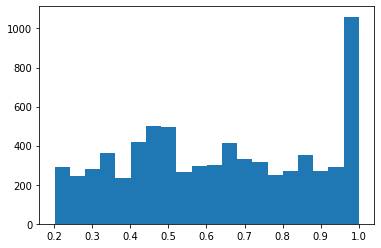

In [15]:
np.shape(Ms) # subhalo masses. So first, cut for 9.5
MsCut = Ms >10**9.5
Ms2 = Ms[MsCut]
GroupCut = Groups[MsCut]
centralC = np.zeros(np.size(np.unique(GroupCut)))
env = np.zeros(np.size(np.unique(GroupCut)))
#most massives:
for i in range(np.size(np.unique(GroupCut))):
    #print(i)
    centralC[i] = np.max(Ms2[np.argwhere(GroupCut == GroupCut[i] )[:,0]])
    env[i]= centralC[i]/np.sum(Ms2[np.argwhere(GroupCut == GroupCut[i] )[:,0]])
plt.hist(env,bins = 20) # tried determining environment, to limited success (using GroupFirstSub and GrNr)
#plt.hist(centralMs)
print(np.shape(np.argwhere(env == 1)))

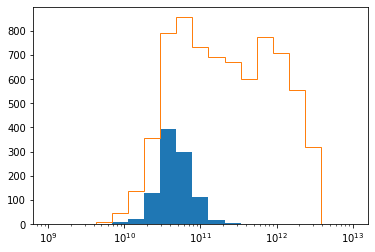

In [16]:
plt.hist(centralC[env ==1],bins = np.logspace(9,13,20))
plt.hist(centralC,histtype = 'step',bins = np.logspace(9,13,20))
# demonstrated lower env (=1) occurs more for lower mass
plt.xscale('log')

(12535,)
(2584, 1)


(array([ 37.,  53.,  42.,  26.,  33.,  35.,  53.,  72.,  91.,  97., 137.,
        173., 153., 200., 186., 160., 160., 117., 120., 110., 106.,  65.,
         59.,  49.,  29.,  33.,  26.,  18.,  33.,  10.,  14.,  15.,  10.,
         10.,   9.,   5.,   7.,   9.,   5.,   5.,   1.,   1.,   5.,   2.,
          1.,   2.,   0.,   0.,   0.]),
 array([ 9.5       ,  9.6122449 ,  9.7244898 ,  9.83673469,  9.94897959,
        10.06122449, 10.17346939, 10.28571429, 10.39795918, 10.51020408,
        10.62244898, 10.73469388, 10.84693878, 10.95918367, 11.07142857,
        11.18367347, 11.29591837, 11.40816327, 11.52040816, 11.63265306,
        11.74489796, 11.85714286, 11.96938776, 12.08163265, 12.19387755,
        12.30612245, 12.41836735, 12.53061224, 12.64285714, 12.75510204,
        12.86734694, 12.97959184, 13.09183673, 13.20408163, 13.31632653,
        13.42857143, 13.54081633, 13.65306122, 13.76530612, 13.87755102,
        13.98979592, 14.10204082, 14.21428571, 14.32653061, 14.43877551,
       

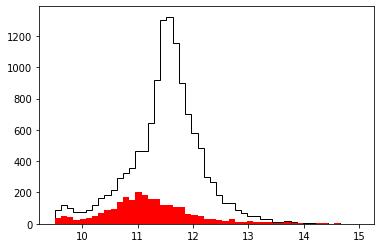

In [17]:
MhaloC = Mhalo[Ms>10**9.5]
print(np.shape(MhaloC))
env1 = np.argwhere(env <=0.5)
print(np.shape(env1))
#print(env1)
plt.hist(np.log10(MhaloC),bins =np.linspace(9.5,15, 50),histtype ='step',color = 'black')
plt.hist(np.log10(MhaloC[env1]),bins =np.linspace(9.5,15, 50),color= 'red')
# some more environment, time for < 0.5

Text(0.5, 1.0, 'centrals only')

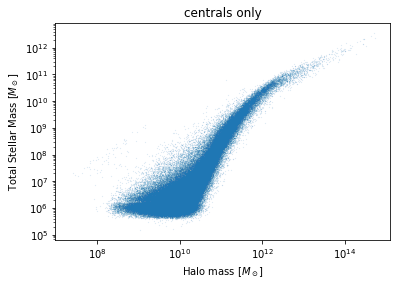

In [18]:
mass_halo = FoFhalos['Group_M_Mean200'] * 1e10 / h
mass_msun = Ms[FoFhalos['GroupFirstSub']]
mbh = FoFhalos['GroupBHMass']*1e10/h
mdot = FoFhalos['GroupBHMdot']*1e10/h * (h/0.978)
plt.plot(mass_halo,mass_msun,'.',ms =0.1)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Total Stellar Mass [$M_\odot$]')
plt.xlabel('Halo mass [$M_\odot$]')
plt.title('centrals only')
#plt.ylim(1e9,1e12)
#plt.xlim(1e11,1e15)

In [19]:
#m95 = mass_msun[mass_msun>10**9.5]
#np.shape(m95)

(7237,)
(7237,)


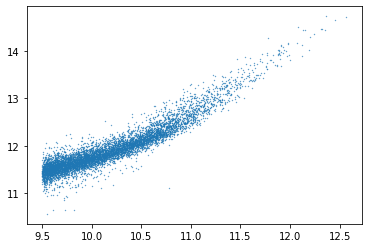

In [20]:
centralmask = (mass_msun>10**9.5) # extracting centrals
centralMs = mass_msun[centralmask]
centralMh = mass_halo[centralmask]
maskidx = np.argwhere(centralmask == True)[:,0]
print(np.shape(FoFhalos['GroupFirstSub'][maskidx]))
centralIDs = FoFhalos['GroupFirstSub'][maskidx]
plt.scatter(np.log10(centralMs),np.log10(centralMh),s = 0.1)
print(np.shape(centralMs))

In [21]:
np.max(np.log10(centralMs))

12.568857

(7237,)


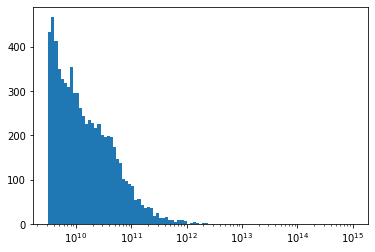

In [22]:
plt.hist(centralMs, bins = np.logspace(9.5,15,100))
plt.xscale('log')
print(np.shape(centralMs)) # these are identical to my implementation with IsPrimary, can be used if you want.

(array([6.60000e+01, 1.10000e+02, 1.78000e+02, 2.15000e+02, 2.49000e+02,
        3.81000e+02, 6.87000e+02, 3.80170e+05, 8.69154e+05, 7.67333e+05,
        6.03615e+05, 4.40635e+05, 3.43327e+05, 2.51208e+05, 1.86432e+05,
        1.39555e+05, 1.02091e+05, 7.45580e+04, 5.44540e+04, 4.10710e+04,
        3.04100e+04, 2.17570e+04, 1.59880e+04, 1.19760e+04, 9.08200e+03,
        6.93200e+03, 5.18100e+03, 3.90900e+03, 2.77900e+03, 2.10600e+03,
        1.60500e+03, 1.09200e+03, 8.75000e+02, 6.48000e+02, 3.77000e+02,
        3.13000e+02, 1.88000e+02, 1.47000e+02, 1.08000e+02, 6.40000e+01,
        6.50000e+01, 3.90000e+01, 1.90000e+01, 1.80000e+01, 1.90000e+01,
        1.00000e+01, 4.00000e+00, 2.00000e+00, 6.00000e+00, 3.00000e+00]),
 array([ 7.0879803,  7.2383833,  7.388787 ,  7.53919  ,  7.689593 ,
         7.8399963,  7.9903994,  8.140802 ,  8.291205 ,  8.441608 ,
         8.592012 ,  8.742415 ,  8.892818 ,  9.043221 ,  9.1936245,
         9.3440275,  9.4944315,  9.6448345,  9.795238 ,  9.94564

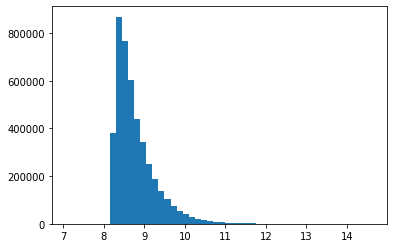

In [23]:
plt.hist(np.log10(Mhalo),bins = 50)

In [24]:
mask  =(Ms>10**9.5)
np.shape(mask)

(4371211,)

In [25]:
phot  = h5py.File("Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_099.hdf5","r")
bars = h5py.File("tng100-1_bars_099.hdf5","r")

astid = phot['subhaloIDs'][()]
bands = phot['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc'][()]
print(np.shape(bands))
print(np.shape(astid))
idx = astid[mask]#(np.argwhere(np.in1d(astid,SubID) == True))
bands = bands[idx]
#print(np.shape(bands))
U = bands[:,0,0]
G = bands[:,1,0]
R = bands[:,2,0]
I = bands[:,3,0]  # preparing the magnitude data. Documentation of supplemental catalog indicates I can pick any
Z = bands[:,4,0]  # index (reflecting angle of obs), and apply for all.

(4371211, 8, 12)
(4371211,)


In [26]:
# Move onto morphologies
stara = h5py.File("stellar_assembly.hdf5","r")
starcirc = h5py.File("stellar_circs.hdf5","r")
bars = h5py.File("tng100-1_bars_099.hdf5","r")

In [27]:
AngID= starcirc['Snapshot_99']['SubfindID'][()]#.keys()
print(np.shape(AngID)) # looked at angular momentum but ultimately discarded
#idx = AngID[mask]#(np.argwhere(np.in1d(AngID,SubID) == True))
#Angidx

(32910,)


In [28]:
morphg = h5py.File("sdss_morphs_g.hdf5 ","r")
morphoGID = morphg['subfind_id'][()]
print(np.shape(morphoGID))
morphoflag = morphg['flag'][()]
#maskIDX = morphoGID[mask]#np.argwhere(((morphoGID == SubID)))
#np.shape(maskIDX)

(12535,)


In [29]:
np.size(morphoflag[morphoflag == 1]) # flagging galaxies with poor sersic fit

1031

(12535,)


(array([ 13.,  36.,  43.,  94., 134., 211., 269., 313., 300., 310., 293.,
        288., 303., 286., 294., 269., 342., 288., 300., 306., 306., 301.,
        305., 293., 285., 285., 285., 241., 252., 208., 211., 176., 173.,
        214., 155., 143., 146., 108., 112., 102.,  96., 102.,  93.,  88.,
         91.,  75.,  73.,  75.,  81.,  63.,  68.,  76.,  48.,  57.,  48.,
         65.,  49.,  87.,  48.,  68.,  57.,  35.,  38.,  46.,  26.,  44.,
         44.,  41.,  29.,  36.,  32.,  35.,  35.,  36.,  25.,  31.,  21.,
         29.,  32.,  22.,  26.,  22.,  24.,  18.,  29.,  29.,  13.,  16.,
         14.,  12.,  14.,  12.,  22.,  21.,  13.,  16.,  16.,   8.,  17.]),
 array([0.        , 0.06060606, 0.12121212, 0.18181818, 0.24242424,
        0.3030303 , 0.36363636, 0.42424242, 0.48484848, 0.54545455,
        0.60606061, 0.66666667, 0.72727273, 0.78787879, 0.84848485,
        0.90909091, 0.96969697, 1.03030303, 1.09090909, 1.15151515,
        1.21212121, 1.27272727, 1.33333333, 1.39393939, 1.45

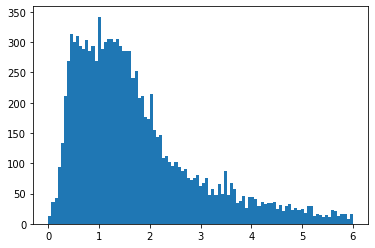

In [30]:
sersics = morphg['sersic_n'][()]
print(np.shape(sersics)) # experimental work with sersic index
plt.hist(sersics, bins = np.linspace(0,6,100))

(0, 6.1)

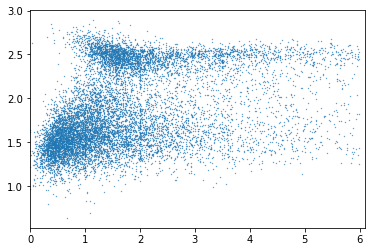

In [31]:
plt.scatter(sersics[sersics <=6],(U-R)[sersics<=6],s = 0.1) # experimental work with Sersic index
plt.xlim(0,6.1)

In [32]:
#select galaxies for which we want SFHs. Start with a simple mass cut
SubID=np.arange(Ms.shape[0])
print(np.shape(SubID))
mask=(Ms>10**9.5)
print(np.shape(mask))
SubhaloHalfmass_stars=SubhaloHalfmass_stars[mask]
BHSubhaloHalfmass_stars = BHSubhaloHalfmass_stars[mask]
SubID=SubID[mask]
Ms = Ms[mask]
BHMs = BHMs[mask]
BHMdot = BHMdot[mask]
Mh = Mhalo[mask]
HaloZ = HalosZ[mask]
Coords = Coord[mask]
#MBH = mbh[mask]
print(len(SubID))
print(np.shape(SubhaloHalfmass_stars))
Ng = len(SubID)


(4371211,)
(4371211,)
12535
(12535,)


In [33]:
Ngc = int(np.size(centralMh)) # number of centrals

0


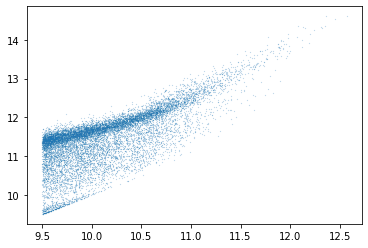

In [34]:
plt.scatter(np.log10(Ms),np.log10(Mh), s=0.01)
print(np.size(np.argwhere(Mh == 0)))

### Preparing the file and the datasets to write to

In [35]:
coutfile = "new_centrals_file.hdf5"
 # can optionally use a centrals file

In [36]:
cs1 = h5py.File(coutfile,"w")
#cs1.close() 

In [37]:
c_centralIDs = cs1.create_dataset("centralID",(Ngc,),dtype = np.dtype(float))

In [38]:
c_logMs = cs1.create_dataset("logMs", (Ngc,), dtype=np.dtype(float))
c_logMh = cs1.create_dataset("logMh", (Ngc,), dtype=np.dtype(float))

In [39]:
c_logMh[:] = np.log10(centralMh)
c_logMs[:] = np.log10(centralMs)
c_centralIDs[:] = centralIDs # this is ultimately optional, but I keep it here if you want to compare my 
# choice of centrals with this one. They are ultimately identical

In [40]:
cs1.close()

In [41]:
boutfile = "07_02_BHoutput_file_new.hdf5" # file names...
outfileF = "new_output_file.hdf5"

#outfile2 = "Users\tristanfraser\SummerWork\cutout_0.hdf5"
bf = h5py.File(boutfile, "w")
#f = h5py.File(outfile,"w")



In [52]:
outfileF = "rebinned_output_file.hdf5"

In [43]:
f_BHM = bf.create_dataset("MBH",(Ng,),dtype= np.dtype(float)) # Black hole mass
f_BHMdot = bf.create_dataset("BHMdot",(Ng,),dtype = np.dtype(float))
bf_subID = bf.create_dataset("subID", (Ng,), dtype=np.dtype(float))
bf_subID[:] = SubID # creating entries

In [44]:
f_BHM[:] = BHMs
f_BHMdot[:]= BHMdot # populating 
bf_subID[:] = SubID

In [45]:
bf.close() #closing

In [53]:
f = h5py.File(outfileF,"a") # open & repeat

In [54]:
f_Ang = f.create_dataset("AngMom", (Ng,), dtype=np.dtype(float)) # Angular Momentum
f_logMs = f.create_dataset("logMs", (Ng,), dtype=np.dtype(float)) #total stellar mass
f_logMh = f.create_dataset("logMh",(Ng,),dtype = np.dtype(float)) # Halo mass
f_HaloZ = f.create_dataset("HaloZ",(Ng,),dtype = np.dtype(float)) # Halo gas metallicity 
f_bands = f.create_dataset("bands",(Ng,5),dtype = np.dtype(float)) # Magnitudes

f_sfh_t = f.create_dataset("sfh_t", (Nt,), dtype=np.dtype(float)) #bins in lookback time
f_sfh_t_boundaries = f.create_dataset("sfh_t_boundaries", (Nt+1,), dtype=np.dtype(float)) #bin boundaries
f_sfh = f.create_dataset("sfh", (Ng,Nt),dtype=np.dtype(float)) #mass formed in each bin of lookback time [solar masses]
f_zh = f.create_dataset("zh", (Ng,Nt),dtype=np.dtype(float)) #mass-weighted metallicity of stars formed in each bin of lookback time
f_subID = f.create_dataset("subID", (Ng,), dtype=np.dtype(float)) # this is integer id (closer to an idx)
f_AUXID = f.create_dataset("True_subID", (Ng,), dtype=np.dtype(float)) # this is the actual subhalo id


In [50]:
f_logMs = f.create_dataset("logMs", (Ng,), dtype=np.dtype(float)) #total stellar mass
f_logMh = f.create_dataset("logMh",(Ng,),dtype = np.dtype(float)) # Halo mass
f_HaloZ = f.create_dataset("HaloZ",(Ng,),dtype = np.dtype(float)) # Halo gas metallicity 
f_bands = f.create_dataset("bands",(Ng,5),dtype = np.dtype(float)) # Magnitudes

f_sfh_t = f.create_dataset("sfh_t", (Nt,), dtype=np.dtype(float)) #bins in lookback time
f_sfh_t_boundaries = f.create_dataset("sfh_t_boundaries", (Nt+1,), dtype=np.dtype(float)) #bin boundaries
f_sfh = f.create_dataset("sfh", (Ng,Nt),dtype=np.dtype(float)) #mass formed in each bin of lookback time [solar masses]
f_zh = f.create_dataset("zh", (Ng,Nt),dtype=np.dtype(float)) #mass-weighted metallicity of stars formed in each bin of lookback time
f_subID = f.create_dataset("subID", (Ng,), dtype=np.dtype(float)) # this is integer id (closer to an idx)
f_AUXID = f.create_dataset("True_subID", (Ng,), dtype=np.dtype(float)) # this is the actual subhalo id


RuntimeError: Unable to create link (name already exists)

In [55]:
#_Ang[:] = AngM
f_logMs[:] = np.log10(Ms)
logMs= np.log10(Ms)
f_logMh[:] = np.log10(Mh) # storing halo ids.
f_HaloZ[:] = HaloZ
f_AUXID[:] = idx
f_bands[:] = bands[:,0:5,0]

f_sfh_t[:] = sfh_t
f_sfh_t_boundaries[:] = sfh_t_boundary
f_subID[:] = SubID


In [ ]:
f.close()

In [ ]:
zh

Write stellar masses and time bins

In [ ]:
sfh,zh,z = get_sfh(SubID[0])

In [ ]:
z

In [ ]:
sfh

In [ ]:
sfht

In [ ]:
z/sfh

In [ ]:
zh

In [ ]:
plt.plot(z)
plt.show()
plt.plot(sfh)

In [ ]:
plt.plot(zh)

In [64]:
#NB: running this for the full 12K galaxies takes a long time. In this example notebook, we do only 10
from tqdm import tqdm
for i in tqdm(range(0,len(SubID))):
    if i%100 == 0: print(zh,z)
    #sfh, zh = get_sfh(SubID[i], radius=2*SubhaloHalfmass_stars[i])
    #print(f_zh[0,:],zh)
    sfh, zh,z = get_sfh(SubID[i], force_download=True)
    #print(zh)
    f_sfh[i,:] = sfh
    f_zh[i,:] = zh
    #print(zh)
    f.flush()
#print(f_zh[0,:]*f_sfh[0,:])
f.close()


  0%|          | 0/12535 [00:00<?, ?it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.70919555e-02 0.00000000e+00 3.93000841e-02
 4.00558673e-02 3.75661477e-02 3.83226462e-02 3.80114838e-02
 3.62100601e-02 0.00000000e+00 3.60689051e-02 3.82565334e-02
 4.98849265e-02 0.00000000e+00 5.12815751e-02 4.80944999e-02
 3.74972746e-02 2.81512421e-02 2.10224688e-02 1.57377571e-02
 1.68046448e-02 2.09865104e-02 1.74501389e-02 1.42805437e-02
 1.75486971e-02 2.45016702e-02 2.33540181e-02 1.92371085e-02
 1.36156306e-02 1.16339596e-02 1.01124477e-02 8.57330672e-03
 8.05045478e-03 7.39241485e-03 9.06145014e-03 7.61214271e-03
 7.37319747e-03 7.483707

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  1%|          | 100/12535 [03:19<6:56:09,  2.01s/it]

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.03486011 0.         0.0365678  0.0357983  0.03361259 0.03710483
 0.03462157 0.03580781 0.03171592 0.03100621 0.0313603  0.0300411
 0.02569977 0.02582007 0.02598248 0.02855472 0.04593479 0.03893394
 0.04169223 0.04370821 0.0394854  0.03335751 0.02873754 0.02616472
 0.02698649 0.02763617 0.02494592 0.02473898 0.02550568 0.02760235
 0.03030878 0.03173688 0.03092353 0.0318248  0.02849001 0.03024828
 0.03415044 0.03759926 0.03689805 0.04028302 0.03729311 0.03574312
 0.02812184 0.02918782 0.03129689 0.0303092  0.02564314 0.02382038
 0.02910744 0.03059611 0.02734935 0.02421935 0.02649865 0.02722319
 0.02396446 0.01980115 0.01839481 0.01598524 0.01374737 0.01390406
 0.01580731 0.01569822 0.01582933 0.016477   0.02236697 0.02228788
 0.01962034 0.01646767 0.01471889 0.0125696  0.01061446 0.00927126
 0.00858443 0.00783266 0.00727086 0.00657464 0.00609167 0.00477203
 0.0068648  

  2%|▏         | 200/12535 [05:43<12:38:42,  3.69s/it]

[0.00940388 0.01003729 0.01046649 0.01043034 0.01040806 0.01076039
 0.01028711 0.00959414 0.00984375 0.00935496 0.00926669 0.00956065
 0.00949919 0.0082918  0.00854465 0.0082431  0.00795895 0.00778115
 0.00725587 0.00717423 0.00772807 0.00751885 0.0073991  0.00755136
 0.00721481 0.00704638 0.00742878 0.00769563 0.00791014 0.0082257
 0.00716631 0.00799147 0.00861964 0.00770058 0.00811047 0.0082322
 0.0092104  0.00862444 0.00747282 0.00945978 0.01060208 0.00981449
 0.01011333 0.01036284 0.01022484 0.01063956 0.0104838  0.01015554
 0.00967631 0.01009746 0.00956686 0.01082117 0.01006917 0.00957661
 0.01020274 0.0105346  0.00928597 0.00857244 0.01142572 0.01376383
 0.01598048 0.01823427 0.01699865 0.01723018 0.01909319 0.0194276
 0.01845474 0.040177   0.0383876  0.04405266 0.03064531 0.02367098
 0.02820797 0.02552573 0.02407539 0.03022388 0.03080625 0.03157812
 0.02932687 0.02518879 0.01844074 0.01663943 0.01703938 0.01700041
 0.01835085 0.01849926 0.01913891 0.0193552  0.01414617 0.0091408

  2%|▏         | 300/12535 [08:23<3:57:03,  1.16s/it] 

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.35662961e-02 3.39157134e-02
 2.93747019e-02 3.03557627e-02 2.78034806e-02 2.28086375e-02
 3.04125976e-02 2.90163495e-02 3.47980335e-02 3.50375175e-02
 3.30703929e-02 3.18284631e-02 2.95448732e-02 3.19565497e-02
 2.69378871e-02 2.49552857e-02 2.38465052e-02 3.59304398e-02
 3.66887264e-02 4.37916033e-02 3.89037803e-02 3.40605117e-02
 3.54468338e-02 3.99605408e-02 4.20770943e-02 4.13260944e-02
 3.85165513e-02 3.70381847e-02 3.07432432e-02 2.55918987e-02
 2.08454896e-02 1.77806765e-02 1.62574761e-02 1.13432305e-02
 9.54501517e-03 1.46019151e-02 1.52943078e-02 1.52358040e-02
 1.16273891e-02 1.07615422e-02 1.23653188e-02 1.43948132e-02
 1.58516616e-02 1.56600419e-02 1.26231182e-02 1.36433039e-02
 1.21284639e-02 1.271139

  3%|▎         | 400/12535 [11:19<5:59:25,  1.78s/it] 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.04669465
 0.05149247 0.05415776 0.06036575 0.06417916 0.06498969 0.06702667
 0.07012431 0.070892   0.0665391  0.06509878 0.06358051 0.06074319
 0.05515156 0.05069644 0.04412854 0.04189308 0.03762035 0.0327062
 0.03219896 0.02973467 0.02910488 0.0297283  0.02805926 0.02581921
 0.02579457 0.02609956 0.02552225 0.02764262 0.02669718 0.02522735
 0.02793025 0.03030779 0.02868854 0.02510736 0.0228975  0.02284797
 0.02339271 0.02075438 0.01755268 0.01826522 0.01811316 0.01563938
 0.01462887 0.01366927 0.0142622  0.01148401 0.0097084  0.00864045
 0.0073376  0.00640262 0.006039   0.00729783

  4%|▍         | 500/12535 [14:20<5:26:41,  1.63s/it] 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.02144968
 0.04240853 0.0368488  0.02732233 0.02201611 0.02741004 0.03332256
 0.04121632 0.04553771 0.05573015 0.05884963 0.04640461 0.03844357
 0.03663993 0.03433798 0.02723019 0.0178675  0.01511464 0.01395606
 0.01260324 0.01217327 0.01176492 0.00943741 0.00774013 0.00702572
 0.00642467 0.00

  5%|▍         | 600/12535 [17:02<9:20:18,  2.82s/it] 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00431528 0.         0.         0.
 0.         0.03076419 0.         0.         0.         0.
 0.0116154  0.00822207 0.         0.         0.         0.
 0.01139596 0.00659045 0.00568736 0.00865472 0.00764895 0.01323602
 0.00957333 0.00810502 0.00661579 0.         0.         0.00692638
 0.00621474 0.00729012 0.00881753 0.00886148 0.00969964 0.01291158
 0.01301583 0.01150595 0.01089619 0.01188103 0.01125121 0.01123807
 0.01140251 0.01159448 0.0107785  0.01044733 0.0127657  0.01385865
 0.01478789 0.0131431  0.01302207 0.01426132 0.01240668 0.01305449
 0.01587458 0.01236527 0.00997982 0.01028726 0.0108235  0.01014811
 0.00954459 0.00857865 0.00694975 0.0095126  0.03222737 0.04033341
 0.04128541 0.02941268 0.02203437 0.01461203 0.01164824 0.0128251
 0.01270078 0.01351987 0.015331   0.01237043 0.00930305 0.00531539
 0.00469047 0.00500842 0.00466232 0.

  6%|▌         | 700/12535 [20:02<5:23:02,  1.64s/it] 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00778458 0.00717988 0.00829435 0.0074642  0.00737924 0.0075192
 0.0067569  0.00775689 0.00790709 0.0151962  0.01740768 0.01944708
 0.02039681 0.02305564 0.02328419 0.02183807 0.0234122  0.02221988
 0.02221907 0.02461633 0.02605442 0.03406086 0.03167109 0.03135539
 0.03173564 0.0334486  0.03755724 0.03555796 0.03137847 0.02726374
 0.02602127 0.02501903 0.02352194 0.0211495  0.0189986  0.01909328
 0.02429123 0.0348644  0.02499483 0.02182888 0.02043762 0.01542836
 0.01422495 0.01489215 0.01345535 0.01147095 0.00476449 0.00

  6%|▋         | 800/12535 [23:06<3:52:59,  1.19s/it] 

[0.02619405 0.02774554 0.02939861 0.02756435 0.02564408 0.02960045
 0.03168662 0.03532203 0.03443609 0.03213245 0.03461084 0.03088491
 0.02648163 0.02472158 0.02167556 0.02020743 0.01821361 0.01848709
 0.02052297 0.02054158 0.01777424 0.0168029  0.01545615 0.01632158
 0.01943455 0.0167587  0.02164835 0.04130011 0.04426345 0.04690129
 0.03414313 0.02919052 0.02546137 0.01860818 0.02101308 0.01910814
 0.01765816 0.01602565 0.01385437 0.01541892 0.01483444 0.01830825
 0.01500973 0.02129434 0.02458316 0.01912397 0.0139229  0.01144093
 0.01287371 0.01411475 0.01921251 0.02018335 0.02472864 0.02253162
 0.0171132  0.01680967 0.01667451 0.01197174 0.00917314 0.01271631
 0.01458683 0.00947605 0.01129422 0.01214921 0.00879615 0.00910428
 0.0095802  0.00897542 0.00884744 0.00712503 0.00671638 0.00530944
 0.0047602  0.00507665 0.00435942 0.00377094 0.00428513 0.00495252
 0.00631545 0.00622781 0.0048639  0.0045348  0.00442738 0.00354849
 0.00290708 0.00253489 0.00247462 0.00257684 0.00197991 0.0023

  7%|▋         | 900/12535 [25:50<4:08:57,  1.28s/it] 

[0.03022818 0.02611446 0.02728365 0.02399831 0.02471973 0.02643041
 0.02345721 0.02402343 0.02682303 0.02746598 0.02580053 0.02711742
 0.03021903 0.02769444 0.03040004 0.02999692 0.02855138 0.03460437
 0.03696931 0.04021686 0.03503641 0.03763038 0.03581915 0.03282966
 0.03162865 0.02604249 0.02199746 0.01820401 0.01499946 0.01224056
 0.0100947  0.00979026 0.00894515 0.00898877 0.01015646 0.01293156
 0.01392632 0.01668116 0.01152703 0.01091996 0.01059815 0.01370551
 0.01690065 0.01173055 0.01073151 0.01004693 0.0091696  0.00843236
 0.00874352 0.00848127 0.00635894 0.00538905 0.00659608 0.00829414
 0.00838155 0.01016649 0.01300945 0.01162542 0.00970665 0.00784114
 0.00748101 0.01083692 0.01430775 0.01205588 0.01573419 0.01802234
 0.01840433 0.01489909 0.01468326 0.01016505 0.01076503 0.00916631
 0.00760379 0.00694284 0.00647265 0.00577843 0.00726175 0.00735546
 0.00781611 0.00684857 0.00547328 0.00552671 0.00576236 0.00683795
 0.00530716 0.00598868 0.00655101 0.00494206 0.00286172 0.0022

  8%|▊         | 1000/12535 [28:28<3:48:30,  1.19s/it]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.22815461e-02
 1.92241520e-02 1.88576039e-02 2.55799275e-02 2.42055394e-02
 2.03001071e-02 1.94634926e-02 1.56382658e-02 1.10118436e-02
 1.03877848e-02 1.25686144e-02 1.13349874e-02 1.06032752e-02
 1.02143707e-02 1.43343098e-02 1.37553373e-02 1.14239659e-02
 1.09706558e-02 1.05007580e-02 9.05300584e-03 1.09329736e-02
 1.08276801e-02 8.68627708e-03 1.08405417e-02 1.08612627e-02
 9.24721174e-03 9.020539

  9%|▉         | 1100/12535 [31:24<13:23:12,  4.21s/it]

[0.01061584 0.01107846 0.0124761  0.01287735 0.01375394 0.01475833
 0.01385743 0.01400201 0.01403138 0.01498511 0.01466789 0.01589089
 0.01351163 0.0122774  0.01141666 0.01098925 0.01092484 0.01089113
 0.01074617 0.01113934 0.01109115 0.01090829 0.01095252 0.01109471
 0.01102027 0.01124764 0.0129802  0.0152324  0.01556298 0.01557673
 0.01485916 0.01411907 0.01394081 0.01254896 0.01230611 0.01156113
 0.01075581 0.00983384 0.00920812 0.0087687  0.00833153 0.00832628
 0.00925636 0.0105543  0.01124017 0.01116099 0.01022212 0.01024172
 0.01046127 0.0110254  0.01173639 0.01210451 0.01218122 0.01271596
 0.01249926 0.01263695 0.01421996 0.01164024 0.01255416 0.0129223
 0.0128802  0.01290041 0.01498802 0.01861956 0.01613835 0.01489051
 0.01482061 0.01261854 0.0121485  0.01200791 0.01282944 0.0144306
 0.02950222 0.01840651 0.02141405 0.02410765 0.02249216 0.02472511
 0.02107326 0.02657685 0.02637476 0.02209052 0.02274985 0.02194229
 0.01915007 0.02073254 0.0220962  0.02209798 0.01700757 0.015366

 10%|▉         | 1200/12535 [34:17<3:56:50,  1.25s/it] 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.0284797  0.02844048 0.02149263 0.02502732
 0.02539525 0.0216222  0.02025014 0.02038337 0.01816027 0.01801603
 0.02262075 0.02088851 0.0209869  0.01543926 0.01758353 0.01829836
 0.01422205 0.01411989 0.01469839 0.01469169 0.01133295 0.00902491
 0.00796738 0.00875684 0.00796746 0.00644898 0.0068619  0.00684514
 0.00741962 0.00616034 0.00488342 0.00347634 0.00298578 0.00324749
 0.00232386 0.00171037 0.00225179 0.00162929 0.00154981 0.00100028


 10%|█         | 1300/12535 [37:51<4:35:35,  1.47s/it] 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.04401994 0.04150534 0.0411879  0.04161618 0.0406555
 0.03942689 0.03561165 0.03644964 0.03571064 0.0333638  0.03252927
 0.0312429  0.03109289 0.0272844  0.0243625  0.02617897 0.02281966
 0.02687561 0.03547145 0.03776743 0.04562706 0.04267238 0.03996167
 0.03600194 0.04288896 0.03639206 0.03731708 0.034624   0.03440474
 0.02877895 0.02730814 0.03710006 0.03483086 0.03611031 0.03734973
 0.03375313 0.0290635  0.02704688 0.0290827  0.03444788 0.04255086
 0.04551974 0.04423015 0.04772073 0.04217069 0.03798554 0.03319743
 0.0280863  0.02275116 0.02963135 0.03204    0.02879678 0.02832465
 0.02594071 0.02176739 0.02227056 0.02534917 0.02010065 0.01862442
 0.02081363 0.02018693 0.01736061 0.01650803 0.01571956 0.01566889
 0.01427599 0.01470006 0.01388883 0.01336925 0.01114481 0.00931891
 0.00885797 0.00711983 0.00572715 0.00485818 0.00396075 0.00369036
 0.00361102 

 11%|█         | 1400/12535 [40:47<3:59:10,  1.29s/it] 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.02023447 0.01939976 0.02097906 0.0214819  0.01727087 0.01678883
 0.01535825 0.01414042 0.01183553 0.01282549 0.01307343 0.01531986
 0.01546104 0.01446333 0.01391427 0.01277757 0.0091877  0.01002059
 0.00940115 0.01040201 0.01099039 0.008567   0.01739466 0.01190701
 0.01443601 0.01369269 0.01097141 0.01076005 0.00707783 0.00894708
 0.01076284 0.00892551 0.01015577 0.01031309 0.01083789 0.00919099
 0.00672716 0.00926897 0.01266572 0.01422163 0.01277757 0.01537405
 0.01170483 0.00913924 0.01061287 0.00888817 0.00838188 0.00847992
 0.00674624 0.00803951 0.00974766 0.0101531  0.00800219 0.00784026
 0.00614475 0.00530841 0.00500865 0.00527462 0.00491183 0.00347903
 0.00390249 0.00603279 0.00505812 0.00514665 0.00454545 0.00472894
 0.00503842 0.00432562 0.00352886 0.00385798 0.00370604 0.00302076
 0.00125887 0.00173

 12%|█▏        | 1500/12535 [44:32<4:54:24,  1.60s/it] 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00699272 0.00809929
 0.00797396 0.00541014 0.00498343 0.00830318 0.00535379 0.00346299
 0.00372094 0.         0.00398538 0.00672164 0.01201942 0.03467334
 0.03508547 0.03801608 0.0358181  0.03914852 0.0356301  0.03333527
 0.02969754 0.02415211 0.02373654 0.02426005 0.02158926 0.02013692
 0.01928139 0.03443724 0.02947053 0.02192237 0.01888173 0.01520196
 0.01119859 0.00829845 0.00715917 0.00702073 0.00619206 0.00380747


 13%|█▎        | 1600/12535 [47:24<4:26:18,  1.46s/it] 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.0639572  0.06143161
 0.05412496 0.05990141 0.06222023 0.0581067  0.06873652 0.07043257
 0.07139742 0.06044444 0.04310758 0.03632749 0.0309475  0.02865663
 0.02592497 0.02375314 0.02491195 0.02889745 0.02889693 0.02382963
 0.02029532 0.01750635 0.0177134  0.01772843 0.01748573 0.01748356
 0.01912747 0.0174217  0.01801731 0.01625912 0.02029665 0.02172885
 0.01966996 0.02916173 0.02618202 0.02326532 0.0182863  0.02043753
 0.02367681 0.02279226 0.02381285 0.02758381 0.02367486 0.02351172
 0.02042671 0.01790477 0.0166175  0.01424601 0.01657615 0.02061827
 0.01817177 0.02040773 0.01915439 0.01788633 0.01659766 0.01466007
 0.01350299 0.0112491  0.01045546 0.01144168 0.01096429 0.0129117
 0.00943391 0.00981046 0.00824903 0.00865482 0.01043146 0.00815545
 0.00894015 0.00647336 0.00712425 0.00724746 0.00679679 0.00691716
 0.00663849 

 14%|█▎        | 1700/12535 [50:47<5:49:19,  1.93s/it] 

[0.03010418 0.03103732 0.03448006 0.03768047 0.03426168 0.02960013
 0.0276372  0.02606131 0.02132387 0.02309041 0.02091715 0.02367115
 0.02159715 0.01947926 0.0195724  0.01932433 0.02080458 0.02453445
 0.02016972 0.01873659 0.02211144 0.02111245 0.02376162 0.01879838
 0.01751929 0.01781455 0.01305677 0.01523376 0.01586703 0.01464052
 0.01289339 0.01073074 0.01258055 0.01996902 0.01711107 0.01754121
 0.01438133 0.0167443  0.02014189 0.01893964 0.01643433 0.01376224
 0.014597   0.01301049 0.01290029 0.0111874  0.01351783 0.01599035
 0.01584612 0.0147578  0.01248244 0.01035367 0.01287603 0.01336196
 0.01177297 0.0124765  0.0139532  0.01367511 0.01125306 0.01280954
 0.00988852 0.01482004 0.01285841 0.01207269 0.01120599 0.01694731
 0.01335142 0.0139329  0.00997977 0.00998859 0.01104542 0.01012875
 0.01021533 0.01028441 0.0090641  0.00939192 0.00804775 0.00827455
 0.00645803 0.00942059 0.0084116  0.00571343 0.00685367 0.00555763
 0.00412944 0.00419534 0.00440555 0.00492252 0.00292901 0.0015

 14%|█▍        | 1800/12535 [54:11<5:01:37,  1.69s/it] 

[0.04344127 0.04656109 0.05211971 0.05503106 0.04939837 0.04135336
 0.03336466 0.03210774 0.02798601 0.02493591 0.02254666 0.02145955
 0.0218501  0.02571349 0.02723004 0.02577034 0.02331884 0.02205365
 0.0229655  0.02418532 0.02592986 0.0251176  0.02197984 0.0258337
 0.02427316 0.02599082 0.02263037 0.02133235 0.01978407 0.01914582
 0.01708179 0.02238855 0.02164721 0.02761016 0.0252789  0.02438883
 0.02404028 0.02629806 0.02559769 0.02906122 0.03047973 0.03059623
 0.0355368  0.03177592 0.03366677 0.02799847 0.02277802 0.02423867
 0.01711336 0.01827729 0.01651808 0.01682631 0.01417726 0.01566621
 0.0143679  0.0135276  0.01752344 0.01829137 0.01615132 0.02518114
 0.02572765 0.01780367 0.01647856 0.01521169 0.01254801 0.01297533
 0.01292599 0.01667132 0.01532197 0.01174151 0.01350118 0.01167269
 0.01193002 0.0150972  0.01217738 0.01064475 0.01201407 0.01021713
 0.00724325 0.00914266 0.00779228 0.0069125  0.00862376 0.00757487
 0.00826989 0.00942787 0.00746356 0.00596183 0.00519843 0.00510

 15%|█▌        | 1900/12535 [57:19<4:30:59,  1.53s/it] 

[0.04264666 0.04858637 0.03511442 0.01684717 0.01149979 0.01029167
 0.0089409  0.00896603 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ] [5

 16%|█▌        | 2000/12535 [1:00:54<4:38:48,  1.59s/it] 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.05592154 0.06160012
 0.06055091 0.05926684 0.05609244 0.05796498 0.06682451 0.06298115
 0.05943809 0.05414906 0.04894666 0.04070774 0.039099   0.04284542
 0.04037277 0.04012251 0.04363704 0.04767433 0.05126683 0.05281157
 0.04631364 0.03867188 0.03460512 0.03484843 0.03433464 0.03357935
 0.02892556 0.0295869  0.03320901 0.03086113 0.02503499 0.0223589
 0.02416163 0.0256568  0.02705179 0.02777194 0.02751407 0.02674341
 0.02633454 0.02310001 0.02403326 0.0237394  0.02619892 0.02868682
 0.02948047 0.0281764  0.02392869 0.02306634 0.02641778 0.02145668
 0.0239724  0.0213028  0.01848833 0.01629858 0.01080699 0.00967483
 0.01103245 0.01202601 0.01014793 0.0075121  0.00820882 0.0080977
 0.00715445 0.00659152 0.0064

 17%|█▋        | 2100/12535 [1:04:19<5:07:02,  1.77s/it] 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.04619065
 0.04789459 0.05395004 0.05692066 0.05755587 0.05771502 0.05286585
 0.05141723 0.05062313 0.04869526 0.05085934 0.05746502 0.05738635
 0.05604035 0.04974085 0.04177758 0.0370725  0.03950012 0.0433472
 0.04449553 0.04594698 0.04287366 0.03499729 0.03382221 0.03763415
 0.03716185 0.04089253 0.04691419 0.04307991 0.03815446 0.02960796
 0.02591681 0.02375428 0.02409822 0.02761666 0.03120554 0.03079824
 0.03309319 0.02813191 0.02893131 0.0281259  0.03045563 0.02997355
 0.02526482 0.02486801 0.02353932 0.02416014 0.02453579 0.02478663
 0.02578272 0.02520869 0.02881265 0.0271507  0.02549323 0.02143566
 0.02043848 0.02305461 0.02405609 0.01942871 0.01493288 0.01430557
 0.01424719 0.01318638 0.01176096 0.01290247 0.01292892 0.01093025
 0.01077422 0.0103614  0.00930314 0.01011017 0.0093871  0.00775805
 0.00968161 0.00644854 0.00703063 0.00707847 0.00484291 0.00409131
 0.0

 18%|█▊        | 2200/12535 [1:07:14<3:46:40,  1.32s/it]

[0.0321679  0.03345812 0.0316581  0.03268097 0.03140852 0.02730349
 0.02759556 0.02842755 0.02718436 0.02945804 0.02887372 0.03122726
 0.02839588 0.02719396 0.02914182 0.02939328 0.02806427 0.0262574
 0.03049434 0.02787528 0.02483215 0.02295784 0.02097451 0.0187757
 0.01751915 0.01669831 0.01502331 0.01445569 0.01460283 0.01281802
 0.01217332 0.01284568 0.01172705 0.0112562  0.01560055 0.01417679
 0.01228886 0.01250259 0.01176037 0.01191159 0.01761946 0.01405056
 0.01437902 0.01786201 0.01632857 0.017193   0.0150412  0.01333294
 0.01319646 0.01293193 0.01064617 0.00990502 0.00836962 0.00748466
 0.00831709 0.00760244 0.00784786 0.00732157 0.007428   0.00817734
 0.00773719 0.00685137 0.00691058 0.00660235 0.00615373 0.00643112
 0.00470421 0.00484339 0.00529183 0.00632247 0.00553945 0.00512225
 0.0046147  0.0051163  0.00515903 0.00478844 0.00389642 0.00400635
 0.00523098 0.00573861 0.00431965 0.00315628 0.00352596 0.00324143
 0.00348088 0.00466433 0.00373699 0.00376474 0.00365065 0.002442

 18%|█▊        | 2300/12535 [1:10:24<3:51:24,  1.36s/it] 

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.79831770e-02 4.85521667e-02
 4.45766263e-02 4.08844166e-02 3.46967317e-02 3.35952006e-02
 3.78618650e-02 3.33427452e-02 2.82957498e-02 2.58766823e-02
 3.11351717e-02 2.98156179e-02 2.60262713e-02 2.43200678e-02
 2.69293226e-02 2.64115557e-02 2.46350449e-02 2.42195278e-02
 2.44190563e-02 2.05386281e-02 2.04861276e-02 1.80479903e-02
 1.65370461e-02 1.78552419e-02 1.98133681e-02 1.81313921e-02
 1.96704492e-02 1.50898984e-02 1.84786133e-02 2.39175819e-02
 2.06642393e-02 1.95045024e-02 1.51920067e-02 1.61308423e-02
 1.51317222e-02 1.23754302e-02 1.41747957e-02 1.30333491e-02
 8.15384183e-03 6.165718

 19%|█▉        | 2400/12535 [1:13:49<7:27:28,  2.65s/it] 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00592767 0.00536086 0.
 0.00535259 0.00555241 0.00622367 0.00617883 0.00591124 0.00541079
 0.00635706 0.00584973 0.00647136 0.00658357 0.00876969 0.00891993
 0.00831669 0.00778602 0.00861364 0.00874254 0.01116538 0.00745425
 0.00759752 0.05488205 0.04046126 0.03491683 0.02950931 0.02425914
 0.01674337 0.01480321 0.01783577 0.02244937 0.02144931 0.02206249
 0.02362503 0.02672302 0.02882931 0.03127597 0.02900642 0.02731968
 0.02849494 0.02247896 0.01926816 0.01905033 0.01894856 0.01661278
 0.01655491 0.01798812 0.02021803 0.02154484 0.02268129 0.01946076
 0.01742389 0.01577954 0.0150371  0.01504806 0.0159985  0.01356175
 0.01009524 0.00861507 0.00894707 0.0070393

 20%|█▉        | 2500/12535 [1:16:48<3:37:17,  1.30s/it] 

[0.03325632 0.03131842 0.03485675 0.03468518 0.03313169 0.03533209
 0.         0.03497981 0.         0.         0.03849943 0.
 0.03764468 0.03725138 0.03478559 0.03750452 0.0396075  0.03694376
 0.03568561 0.03191206 0.03718606 0.03773586 0.03582072 0.03353164
 0.03022148 0.03457456 0.03526139 0.03547259 0.03250473 0.03186669
 0.03178269 0.03794843 0.03776453 0.04053561 0.0398114  0.03256314
 0.0316257  0.02719161 0.02892585 0.02734574 0.02433077 0.02704651
 0.02463872 0.02210118 0.01838257 0.02773647 0.02445395 0.02100259
 0.01799466 0.01775581 0.01693074 0.01893965 0.02015892 0.02113034
 0.0219607  0.02213823 0.02384621 0.02921894 0.02399258 0.02133767
 0.01827903 0.01773352 0.01833241 0.01611237 0.01344956 0.01320187
 0.01248959 0.01160315 0.00967897 0.00948083 0.00892038 0.00877556
 0.01148576 0.00981386 0.00804381 0.00795685 0.00739625 0.00798286
 0.00848451 0.00804519 0.00935145 0.00912664 0.00706378 0.00633724
 0.00669798 0.00595437 0.00518442 0.00425362 0.00628719 0.00524342
 0.

 21%|██        | 2600/12535 [1:19:38<6:30:04,  2.36s/it]

[0.01807708 0.01795384 0.01803365 0.01855319 0.02522303 0.02670039
 0.02479576 0.02751392 0.02754554 0.02878059 0.02810974 0.02682075
 0.02662684 0.03279663 0.03373383 0.03325949 0.03635767 0.03607332
 0.03547106 0.03245948 0.03096016 0.03150517 0.03187019 0.03171292
 0.03017678 0.02977816 0.0294136  0.0281342  0.02768471 0.02066347
 0.01605402 0.01695653 0.01745906 0.0153801  0.01174692 0.01069551
 0.00995496 0.00964681 0.00941586 0.00936468 0.00950416 0.00931978
 0.01007618 0.01079126 0.01067366 0.01171952 0.01180937 0.01187935
 0.01166897 0.01216863 0.01214241 0.01187676 0.01369643 0.01392373
 0.01170917 0.01115191 0.01215301 0.01629278 0.0179909  0.02118398
 0.02074654 0.01675696 0.01694257 0.01990068 0.01942176 0.01809032
 0.02015915 0.02357795 0.02619986 0.02852148 0.02789971 0.02697867
 0.0254203  0.02618999 0.02637364 0.02325804 0.01838066 0.01921558
 0.01915507 0.01939492 0.02331502 0.02766608 0.02288898 0.02289495
 0.02097456 0.01711555 0.01682461 0.01807013 0.0149496  0.0127

 22%|██▏       | 2700/12535 [1:22:23<3:25:41,  1.25s/it]

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.03533198 0.03718184 0.03918244
 0.         0.03927885 0.03862426 0.04011403 0.0482458  0.05297539
 0.06010484 0.05365728 0.04573813 0.04038555 0.04526991 0.06271272
 0.07233924 0.06219938 0.05747745 0.05269029 0.04394892 0.03644959
 0.02747005 0.02457079 0.02875784 0.03675468 0.03870908 0.04728099
 0.04980284 0.0462372  0.0453888  0.04355463 0.03388264 0.02816575
 0.02332332 0.02145373 0.02102998 0.01717294 0.01396344 0.01396011
 0.01459408 0.01485743 0.01428001 0.0130609  0.00945452 0.00863318
 0.01233325 0.01122973 0.00637621 0.00527562 0.0024

 22%|██▏       | 2800/12535 [1:25:20<5:44:42,  2.12s/it]

[0.02058675 0.02487743 0.02375156 0.02276478 0.02363324 0.02377575
 0.02403666 0.02508822 0.02811657 0.03681923 0.03841009 0.04133828
 0.04054993 0.03836296 0.03732334 0.0329827  0.02776623 0.02904367
 0.03818979 0.03771093 0.03498261 0.03417183 0.03193919 0.0264897
 0.02237189 0.02134723 0.02031306 0.02002458 0.01950474 0.01687258
 0.01700398 0.02024109 0.02089932 0.01964442 0.02121435 0.02142129
 0.02150617 0.02184231 0.02202293 0.02018838 0.02625889 0.03223036
 0.03296703 0.02890645 0.02619676 0.02390898 0.0197293  0.01624686
 0.0166563  0.01998499 0.02493347 0.02459652 0.02119772 0.02155404
 0.01909109 0.01689403 0.01693124 0.01720984 0.01630558 0.01860533
 0.0158171  0.01411019 0.01494835 0.01539171 0.01346311 0.01168211
 0.01176881 0.01299168 0.01198509 0.01201119 0.0098064  0.01122695
 0.01159119 0.01148213 0.0115995  0.00931948 0.01202196 0.01094359
 0.01018449 0.0090749  0.00939308 0.00828339 0.00727944 0.0062474
 0.00547808 0.00563677 0.006063   0.00615949 0.00510445 0.004565

 23%|██▎       | 2900/12535 [1:28:16<3:27:47,  1.29s/it] 

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.53025794e-02 3.72281931e-02 4.19247337e-02
 4.59896736e-02 4.56131734e-02 4.40880172e-02 4.99734208e-02
 5.33004627e-02 5.77367879e-02 5.43800853e-02 4.67119291e-02
 4.18765284e-02 3.53528522e-02 3.82238589e-02 4.34552059e-02
 4.22522910e-02 4.25956063e-02 3.94564010e-02 4.26746607e-02
 4.58893031e-02 4.52447794e-02 4.11547832e-02 3.56511101e-02
 3.47755402e-02 3.88023183e-02 3.74105386e-02 4.02807370e-02
 4.39279750e-02 5.66028468e-02 5.88231981e-02 5.61008304e-02
 5.60096987e-02 5.10565154e-02 4.72610258e-02 4.30614203e-02
 4.09332328e-02 3.59157622e-02 3.36676463e-02 3.50385457e-02
 3.95867229e-02 4.59092334e-02 5.50887883e-02 5.69470190e-02
 5.08871675e-02 4.51745726e-02 3.91612761e-02 3.12554166e-02
 2.78371368e-02 2.71496437e-02 3.03352810e-02 3.70150246e-02
 4.66633886e-02 4.29703295e-02 3.78451981e-02 3.46534587e-02
 3.64346243e-02 3.33770066e-02 3.37166339e-02 3.46588902e-02
 3.21844518e-02 3.542404

 24%|██▍       | 3000/12535 [1:31:30<6:38:17,  2.51s/it] 

[1.58231501e-02 1.53070567e-02 1.55163147e-02 1.34508470e-02
 1.45843057e-02 1.36264525e-02 1.33200446e-02 1.16185015e-02
 1.09457569e-02 9.17273294e-03 1.37940440e-02 1.59299131e-02
 1.38426386e-02 1.64691620e-02 1.53182112e-02 1.73282698e-02
 1.64153967e-02 1.08742546e-02 1.23955319e-02 1.23730833e-02
 1.15995472e-02 1.43238558e-02 1.59003846e-02 1.22996951e-02
 1.49897421e-02 1.02632120e-02 1.31835425e-02 1.61914900e-02
 1.78735182e-02 1.66870169e-02 1.58937946e-02 1.36441588e-02
 1.41970180e-02 1.60450339e-02 1.25171142e-02 1.13220848e-02
 1.31890140e-02 1.32288150e-02 1.39404349e-02 1.17942961e-02
 1.66113023e-02 1.57900658e-02 1.72681846e-02 1.26652224e-02
 1.24587007e-02 9.78007540e-03 9.07451194e-03 8.76235031e-03
 1.15623362e-02 1.50028104e-02 1.32269971e-02 1.21870413e-02
 1.12212999e-02 1.23738619e-02 1.08200386e-02 9.51549504e-03
 9.31854546e-03 9.06045735e-03 8.78251344e-03 1.07445717e-02
 7.89825805e-03 8.46423302e-03 1.02836238e-02 1.01639926e-02
 9.32863820e-03 7.540854

 25%|██▍       | 3100/12535 [1:34:38<6:07:26,  2.34s/it]

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00299554
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01162246 0.01258294
 0.01673329 0.01688362 0.01719558 0.01661852 0.01561382 0.01402288
 0.01295322 0.01154381 0.01115537 0.00971845 0.00940038 0.0083879
 0.0066875  0.00610077 0.00572151 0.00658143 0.00652276 0.00737746
 0.01459293 0.03235852 0.03025717 0.03218816 0.0363575  0.03831517
 0.035649   0.03735292 0.0404062  0.03926585 0.03745592 0.0356489
 0.02953458 0.02421494 0.01750332 0.01468573 0.0151084  0.01489719
 0.0142167  0.01226648 0.01340558 0.01416308 0.01195096 0.01082136
 0.00810556 0.00656637 0.00546716 0.00455249 

 26%|██▌       | 3200/12535 [1:37:30<4:22:46,  1.69s/it]

[0.0270513  0.02432231 0.02587084 0.02794319 0.02633159 0.0268108
 0.02864618 0.02867513 0.02558346 0.02393506 0.02164466 0.02300522
 0.02005611 0.01996256 0.01952094 0.01983694 0.01870711 0.01938538
 0.02085395 0.02335124 0.0228687  0.02131072 0.02157948 0.02235576
 0.0219148  0.02189363 0.02579645 0.0261034  0.02417173 0.02110641
 0.01741256 0.01452529 0.01281129 0.01085729 0.0102894  0.01003743
 0.01145039 0.01102098 0.0098975  0.0105244  0.00968603 0.00948919
 0.00850198 0.01369083 0.01228899 0.01376215 0.01576805 0.01451922
 0.0165944  0.0156156  0.02029287 0.03200034 0.02715479 0.0221157
 0.02882488 0.0205542  0.03582985 0.03136538 0.02366995 0.02374578
 0.01726819 0.01392176 0.0122287  0.010592   0.00990238 0.00735553
 0.01099486 0.00950363 0.01072403 0.01166539 0.0104224  0.00777542
 0.00657429 0.00696476 0.01015899 0.00673316 0.00838517 0.00801957
 0.00778395 0.0077082  0.00667475 0.00987489 0.00904624 0.00760322
 0.00690311 0.00604389 0.00461069 0.00519587 0.00422224 0.002361

 26%|██▋       | 3300/12535 [1:40:41<4:02:27,  1.58s/it] 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02791498 0.02654456 0.02683667
 0.02477961 0.         0.02851117 0.         0.03117319 0.03523517
 0.03427597 0.         0.03755793 0.04134421 0.04134204 0.04143884
 0.03304413 0.03017397 0.02709296 0.03151767 0.03375351 0.02747662
 0.03377272 0.02874925 0.03109209 0.03021273 0.03684318 0.03589875
 0.03174508 0.03275464 0.0429732  0.03694668 0.0292691  0.02078801
 0.03376076 0.03133522 0.0324658  0.0264115  0.02621021 0.01968743
 0.01440167 0.01307668 0.01009906 0.0143069  0.01279084 0.01410588
 0.01192495 0.01491394 0.01247099 0.01158025 0.01070125 0.00819685
 0.00958839 0.00952228 0.007589   0.00723668 0.00766646 0.00965868
 0.00841917 0.00798229 0.01069201 0.01195455 0.00868503 0.00702771
 0.00614197 0.00516492 0.00459118 0.00497589 0.00570948 0.00440682
 0.00344258 0.00312

 27%|██▋       | 3400/12535 [1:44:23<7:51:35,  3.10s/it] 

[0.01980241 0.01903129 0.02341077 0.03246251 0.02926256 0.03090257
 0.03207024 0.02884764 0.02799904 0.02667308 0.02474383 0.02316461
 0.02119068 0.019115   0.02024567 0.02168893 0.02329361 0.0225039
 0.02416559 0.0243067  0.02258296 0.02469908 0.0220478  0.02174428
 0.0224115  0.01925772 0.01771821 0.02010841 0.02219446 0.02929637
 0.03431216 0.03466034 0.03729139 0.0375093  0.04238118 0.0311068
 0.03818642 0.03121824 0.03438926 0.03117681 0.02808287 0.02388165
 0.02068218 0.016856   0.01697602 0.01680095 0.01709246 0.01837455
 0.02054767 0.02010393 0.02005037 0.01932149 0.01331428 0.02041212
 0.02945915 0.03109677 0.03998655 0.03742358 0.03970387 0.03512608
 0.0295526  0.02313918 0.0220606  0.0201166  0.02100981 0.02173772
 0.02192274 0.02739737 0.02995366 0.02877902 0.02583308 0.0270892
 0.02515412 0.02102499 0.01858146 0.0146007  0.01510818 0.01323761
 0.01431727 0.01421269 0.01312346 0.01072201 0.01115207 0.01035584
 0.00911849 0.00702678 0.00703176 0.00571981 0.00408895 0.0049082

 28%|██▊       | 3500/12535 [1:47:55<3:40:57,  1.47s/it] 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.03083476 0.
 0.03521828 0.03387575 0.0367015  0.03654369 0.03951407 0.04124755
 0.04546082 0.05095085 0.05546034 0.05990822 0.05730333 0.05625758
 0.06435806 0.06595454 0.06164782 0.05928095 0.05757387 0.05568366
 0.0589525  0.06031005 0.0607046  0.05614557 0.05409531 0.04669312
 0.05024342 0.05098646 0.04856447 0.04556097 0.03992408 0.03153231
 0.02751941 0.0258024  0.02649756 0.03540774 0.03090672 0.02599189
 0.02076162 0.0181564  0.01729166 0.01800378 0.01669849 0.01587444
 0.01539512 0.01495735 0.01380027 0.01441775 0.01442479 0.01657822
 0.01605724 0.01310575 0.01391059 0.01588761 0.01352489 0.01116316
 0.00863551 0.00962233 0.00848839 0.00779084 0.00541485 0.00432721
 0.00471075 0.00410762 0.00354387 0.00327025 0.00494003 0.00388584
 0.00402729 0.00318543 0.00

 29%|██▊       | 3600/12535 [1:51:15<5:19:27,  2.15s/it] 

[0.01623109 0.01608278 0.01533271 0.01477698 0.01666864 0.01853364
 0.0176036  0.0206459  0.02191976 0.02127757 0.02031531 0.02091668
 0.02118834 0.02264296 0.02324845 0.02228333 0.02432978 0.02351495
 0.02131829 0.02205094 0.02454126 0.02362588 0.02097046 0.01812413
 0.01702334 0.01655412 0.01791709 0.01886388 0.01878318 0.0190579
 0.01847616 0.01758549 0.01826994 0.01565046 0.01541528 0.01590111
 0.01808076 0.01654175 0.01898347 0.01899906 0.02382006 0.02199104
 0.02289236 0.0244438  0.0191444  0.01697314 0.01591779 0.01593427
 0.01934023 0.01765396 0.01830226 0.01875359 0.01954397 0.01870771
 0.01799841 0.0173089  0.01854904 0.01811312 0.01810129 0.01669316
 0.01828434 0.02074795 0.02228902 0.02461528 0.02938794 0.03091806
 0.01798381 0.01487304 0.01640466 0.01159559 0.00836973 0.00914427
 0.00885562 0.01116965 0.01153419 0.00997823 0.01054323 0.01056636
 0.00912693 0.0086207  0.00627628 0.00509588 0.00530289 0.0040311
 0.00429587 0.00534188 0.00545414 0.00435135 0.00302554 0.004661

 30%|██▉       | 3700/12535 [1:54:39<7:00:25,  2.86s/it]

[0.0305941  0.03252169 0.02913894 0.02435481 0.0306911  0.03525542
 0.04070863 0.0386414  0.03459288 0.0317428  0.03532773 0.03890286
 0.03914674 0.03366527 0.02723065 0.02383783 0.02492555 0.02514672
 0.0252255  0.03084701 0.03113342 0.02856533 0.02451232 0.02314444
 0.02038708 0.01768946 0.01574778 0.01449172 0.0171505  0.01773901
 0.01825755 0.02115202 0.02171011 0.02153376 0.01764877 0.01734145
 0.0196422  0.01585902 0.01746624 0.01444368 0.01590119 0.01973011
 0.01759626 0.0191307  0.02245249 0.02784904 0.0223192  0.02103062
 0.01681637 0.01482856 0.01405375 0.01377695 0.01266178 0.02186872
 0.02046415 0.02253544 0.02263366 0.02642831 0.02488842 0.02085969
 0.02104893 0.01883582 0.0207242  0.02295456 0.02155772 0.01797075
 0.01430737 0.01252158 0.01368067 0.01212746 0.01178422 0.01109816
 0.01046832 0.01195635 0.00976576 0.01073795 0.01036706 0.0107256
 0.010583   0.0080591  0.00678237 0.00540457 0.00664656 0.00676578
 0.00589033 0.00630181 0.0060797  0.00499803 0.00471054 0.00488

 30%|███       | 3800/12535 [1:57:43<5:08:09,  2.12s/it]

[0.03368602 0.03106003 0.03346283 0.03321425 0.0362907  0.03808938
 0.0328475  0.03019159 0.02885388 0.02680496 0.03303552 0.03632136
 0.03512037 0.03598795 0.03292707 0.03068518 0.02898346 0.02815795
 0.0258623  0.02391913 0.02282424 0.0278458  0.0322534  0.03039424
 0.03028278 0.02695793 0.02437272 0.02424606 0.03350827 0.03874786
 0.03550813 0.03540402 0.0225657  0.02615206 0.02933492 0.03451481
 0.03216014 0.02932112 0.03542816 0.03069921 0.0370177  0.03772086
 0.03336762 0.03144726 0.0253367  0.02399737 0.02402167 0.02484736
 0.02790428 0.01949058 0.01647532 0.01547267 0.0115464  0.01054934
 0.0106314  0.00965906 0.0101122  0.01357783 0.01320469 0.01344259
 0.0153683  0.01353417 0.01264421 0.01107521 0.01498395 0.01188608
 0.01074321 0.00787795 0.00828711 0.00855207 0.00849571 0.00833249
 0.00756897 0.00735776 0.00755946 0.00703459 0.00690258 0.00598473
 0.00724726 0.00574326 0.00597041 0.00743002 0.0075485  0.00737042
 0.00886147 0.0083835  0.00723256 0.00352735 0.00444222 0.0036

 31%|███       | 3900/12535 [2:00:49<5:38:47,  2.35s/it]

[0.01534822 0.01503252 0.01547791 0.01581597 0.01618229 0.01658052
 0.01638152 0.0162432  0.01551209 0.01527835 0.01604502 0.01620843
 0.01658277 0.01683772 0.01509044 0.01636576 0.01996177 0.02211287
 0.03059464 0.02997932 0.03119899 0.02570112 0.02585367 0.02783981
 0.02936844 0.03008799 0.03195275 0.03128907 0.02676571 0.02550279
 0.02678038 0.03162356 0.03151662 0.02782395 0.02740645 0.0229979
 0.02184224 0.0215962  0.0223409  0.02102536 0.02086433 0.02163162
 0.02206871 0.02194031 0.02115738 0.02047177 0.02133035 0.01994065
 0.02059158 0.02027049 0.02105049 0.02149401 0.0195289  0.02037447
 0.01939383 0.0197142  0.01826299 0.01740592 0.01834598 0.02067685
 0.01924182 0.0165155  0.01403583 0.01391128 0.01375312 0.01207511
 0.01356879 0.01390671 0.01468183 0.02108694 0.02365822 0.02012044
 0.01884419 0.01637594 0.01763246 0.02064761 0.02223843 0.02186321
 0.02099554 0.01819693 0.01797538 0.01711217 0.01791221 0.01597895
 0.01851389 0.01862916 0.01245582 0.01304185 0.01259296 0.01052

 32%|███▏      | 4000/12535 [2:03:52<3:25:54,  1.45s/it]

[1.88660640e-02 2.26783175e-02 2.13912670e-02 2.20057610e-02
 2.58402620e-02 2.94888075e-02 2.79036220e-02 2.08374653e-02
 2.10175831e-02 2.10597031e-02 1.98197179e-02 1.93477217e-02
 2.21272185e-02 1.89774986e-02 1.90804768e-02 2.00953986e-02
 1.96738038e-02 2.40821689e-02 1.81677788e-02 2.04783566e-02
 2.76369732e-02 2.28700154e-02 2.05097497e-02 2.14619413e-02
 2.22349223e-02 1.95736997e-02 1.89838130e-02 1.78125743e-02
 1.74308885e-02 1.72814447e-02 1.61225665e-02 1.65800098e-02
 1.87860206e-02 2.05094982e-02 2.21968349e-02 2.33542603e-02
 2.00257991e-02 2.35178042e-02 2.49591153e-02 1.85960475e-02
 1.60598680e-02 1.48061085e-02 1.42438989e-02 1.50173809e-02
 1.49772232e-02 1.40765039e-02 1.19661139e-02 1.02109937e-02
 9.53635387e-03 1.03748934e-02 1.17032891e-02 1.23784933e-02
 9.84256342e-03 9.95068811e-03 9.59294755e-03 8.62617698e-03
 9.62609425e-03 9.56328306e-03 1.14937956e-02 1.33101484e-02
 1.03104049e-02 1.14398161e-02 1.01903537e-02 1.06773144e-02
 1.14657599e-02 1.081345

 33%|███▎      | 4100/12535 [2:06:55<3:04:37,  1.31s/it]

[0.03203435 0.03195453 0.         0.         0.03153519 0.03634382
 0.03388898 0.02842034 0.03103769 0.03102041 0.02964653 0.03040258
 0.02971395 0.02880695 0.02870824 0.02606685 0.02338233 0.0306358
 0.03095537 0.04922394 0.04324497 0.04234249 0.04299271 0.04346873
 0.0404901  0.04572801 0.03895543 0.02831698 0.02584171 0.02089124
 0.01608794 0.01553373 0.01377438 0.01667246 0.01925016 0.02517832
 0.02257222 0.02390219 0.02288336 0.02193335 0.02479865 0.0224812
 0.02179627 0.01813469 0.01790588 0.01763161 0.01891445 0.01747645
 0.01649024 0.01500844 0.01572668 0.01345383 0.01398115 0.01314554
 0.01206229 0.01395895 0.01225816 0.01442315 0.01802607 0.0143969
 0.01247157 0.01101599 0.01475988 0.01151864 0.01258584 0.01072317
 0.0130119  0.0108502  0.00991923 0.00882213 0.00840444 0.00726979
 0.00611926 0.00681075 0.00711269 0.00817144 0.00864737 0.00709411
 0.00764291 0.00617197 0.00433742 0.00484153 0.00331823 0.00257117
 0.00378608 0.00472575 0.00333144 0.00380331 0.0030818  0.0026558

 34%|███▎      | 4200/12535 [2:09:58<3:18:20,  1.43s/it]

[0.01866456 0.01724333 0.01636473 0.012852   0.01527696 0.01633765
 0.01481302 0.01380175 0.0144485  0.01384039 0.         0.01478539
 0.         0.01467605 0.01662361 0.01616323 0.0154137  0.01492455
 0.01439973 0.01561027 0.01643071 0.01933894 0.01673506 0.01933704
 0.01967256 0.02136612 0.02070504 0.02130557 0.02086544 0.01972565
 0.02308383 0.02041504 0.02227954 0.02431558 0.02162681 0.02426676
 0.02402164 0.02328002 0.02612055 0.02933495 0.0386594  0.04554546
 0.04413423 0.03525377 0.02825694 0.02206646 0.01934019 0.02244859
 0.02003623 0.01681329 0.02204652 0.03046473 0.03110619 0.03880789
 0.03979202 0.03883107 0.02783993 0.02418522 0.02367405 0.0204435
 0.01755711 0.0297612  0.02762333 0.02833234 0.02585933 0.01847672
 0.01402956 0.01238218 0.01169056 0.01090596 0.01309365 0.01376969
 0.01626292 0.01555452 0.01553615 0.01326835 0.01299367 0.01381175
 0.01137956 0.01008047 0.00992178 0.00746954 0.0067927  0.00784019
 0.00818215 0.00748485 0.00767309 0.00740714 0.00524412 0.00595

 34%|███▍      | 4300/12535 [2:13:40<6:11:09,  2.70s/it] 

[0.01777224 0.01812985 0.01784893 0.01447213 0.02154115 0.02313101
 0.         0.02180113 0.02323738 0.02534753 0.03495521 0.03758856
 0.03508199 0.04001361 0.04089971 0.03724464 0.03436946 0.04016263
 0.03966327 0.0382982  0.03862562 0.04475216 0.05229703 0.05184034
 0.04941402 0.04348051 0.04425989 0.05285507 0.05329553 0.0479072
 0.04069103 0.03296545 0.02661068 0.02259042 0.02424989 0.03114294
 0.03071412 0.03098831 0.0353507  0.05304471 0.05632023 0.05374655
 0.04685678 0.04113524 0.04085578 0.03682011 0.03556033 0.03555438
 0.03179254 0.03395751 0.03237432 0.02228543 0.01811306 0.02358351
 0.02427274 0.03058924 0.02443567 0.02067407 0.01639105 0.02298723
 0.02212619 0.01545187 0.01547282 0.02086005 0.02356438 0.01969469
 0.018737   0.0168507  0.01807871 0.01640537 0.01517829 0.01194994
 0.01524469 0.01219329 0.01299446 0.01341687 0.01203365 0.01209788
 0.01372318 0.01104081 0.01180401 0.01141541 0.00899519 0.00879433
 0.00791376 0.00805982 0.00588735 0.00713001 0.00812977 0.00920

 35%|███▌      | 4400/12535 [2:17:05<4:20:26,  1.92s/it]

[0.01115261 0.01122425 0.01123028 0.01098951 0.01057276 0.01072135
 0.01046035 0.00979956 0.01069286 0.01123668 0.0108141  0.01012491
 0.00960231 0.00983654 0.00976207 0.00920602 0.00947292 0.00919061
 0.00947885 0.00923836 0.00896642 0.00841667 0.00827667 0.00863576
 0.00857361 0.00847984 0.00878449 0.00787355 0.00760753 0.00756915
 0.00736353 0.00725616 0.00722805 0.00769316 0.00789857 0.00755904
 0.00738878 0.00700931 0.00897354 0.01525155 0.01583541 0.01445631
 0.01349317 0.0135719  0.01204266 0.01376807 0.01470701 0.01570857
 0.01536633 0.01552084 0.01888387 0.02146971 0.02355443 0.02453259
 0.02574096 0.02585959 0.02666869 0.02781123 0.02595395 0.02140662
 0.02006978 0.0202496  0.01812401 0.01253361 0.01281233 0.01693592
 0.0243268  0.02289259 0.02251514 0.02213827 0.02058795 0.01858462
 0.01686082 0.01561883 0.01540601 0.01414861 0.01418565 0.0152525
 0.01416969 0.01532573 0.01645403 0.01648353 0.01503248 0.01490146
 0.01287869 0.01030282 0.02304185 0.03073385 0.02204897 0.02217

 36%|███▌      | 4500/12535 [2:20:17<4:47:27,  2.15s/it]

[0.         0.         0.         0.         0.00574209 0.
 0.         0.         0.         0.00466958 0.0044172  0.00485728
 0.00333086 0.         0.00505505 0.00376365 0.         0.
 0.         0.00336807 0.         0.         0.         0.
 0.         0.         0.00913249 0.         0.00538451 0.00558922
 0.00233065 0.00576826 0.00478118 0.00477268 0.00474166 0.0055871
 0.00655349 0.00619955 0.00598581 0.00586116 0.00536802 0.00487427
 0.00469044 0.00471193 0.00543793 0.00494767 0.00695953 0.0073179
 0.00880493 0.00739158 0.00694859 0.00747164 0.00672187 0.0072307
 0.01065104 0.01225587 0.01099395 0.00968408 0.01044798 0.0098447
 0.00912385 0.01104997 0.01088933 0.01267139 0.01189249 0.01326726
 0.02664876 0.03116449 0.02897174 0.03390615 0.04347841 0.04122727
 0.02828985 0.0209814  0.02040749 0.01765929 0.01328883 0.01160798
 0.01113741 0.01116514 0.01302293 0.01366981 0.01330069 0.0109871
 0.00793793 0.00855542 0.00836232 0.00678519 0.00546716 0.00545177
 0.00547533 0.00481225 0

 37%|███▋      | 4600/12535 [2:23:21<4:07:10,  1.87s/it]

[0.01184002 0.01211016 0.01148783 0.01099024 0.01140263 0.01847308
 0.02969101 0.03493417 0.03357334 0.03814749 0.03584318 0.0349451
 0.03407286 0.03056859 0.0305608  0.02839676 0.02864881 0.03628463
 0.03110394 0.03546524 0.03670759 0.0264798  0.01966223 0.0196858
 0.02441348 0.0261788  0.02953468 0.02971172 0.02872304 0.03239128
 0.0294422  0.03246685 0.03408866 0.03412793 0.02976669 0.02751308
 0.02730065 0.02870592 0.02944162 0.03464959 0.03437624 0.03244619
 0.03108229 0.03178052 0.02925445 0.02639709 0.02435892 0.0255565
 0.02408951 0.02230458 0.02367724 0.02537212 0.02125623 0.01585119
 0.01342716 0.01044877 0.00958662 0.00957372 0.00944984 0.01017096
 0.01060837 0.01069656 0.0259574  0.02621383 0.0230922  0.02232445
 0.02255929 0.02439721 0.02813221 0.02182992 0.0194705  0.01895551
 0.02146265 0.02270837 0.02262909 0.02379098 0.02699136 0.0280465
 0.02752286 0.02541105 0.02181037 0.01943008 0.02004272 0.02080193
 0.02020748 0.01993204 0.02401327 0.02090261 0.01891587 0.01617276

 37%|███▋      | 4700/12535 [2:26:37<3:49:14,  1.76s/it]

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00292779
 0.00458084 0.         0.00489356 0.         0.01259804 0.00869989
 0.00826044 0.00735358 0.00871664 0.00889354 0.01186055 0.01280091
 0.01268598 0.01183544 0.01348679 0.01397346 0.01416968 0.02197977
 0.0281586  0.02855284 0.02228368 0.0229406  0.02254129 0.01995187
 0.01844994 0.01749924 0.01605818 0.01483962 0.0113666  0.00901887
 0.01031886 0.01234154 0.01630202 0.02363084 0.02171231 0.02209668
 0.02359812 0.02905617 0.02690177 0.02480505 0.02464543 0.03157546
 0.02319227 0.02216924 0.02008039 0.01631408 0.01383394 0.01374464
 0.01381392 0.01049549 0.00906315 0.0075756

 38%|███▊      | 4800/12535 [2:30:34<4:25:48,  2.06s/it]

[0.02470182 0.02475811 0.02376717 0.02393565 0.02396486 0.
 0.02547405 0.02892429 0.02647761 0.02667574 0.         0.02962788
 0.02983628 0.03033411 0.02456751 0.         0.0284577  0.01423697
 0.02416102 0.02042521 0.01786843 0.02313914 0.02474596 0.02332639
 0.02023765 0.02280593 0.02145809 0.02137171 0.02052808 0.02093206
 0.02472172 0.027795   0.03346388 0.03419754 0.03654758 0.03602759
 0.03840225 0.03293145 0.03204969 0.03426877 0.03456489 0.03153234
 0.03268128 0.03057943 0.02573549 0.02504835 0.03204421 0.02271328
 0.02256364 0.0268477  0.03143192 0.04052295 0.03395361 0.03245489
 0.0256968  0.01648184 0.02429912 0.02242963 0.02015065 0.01976394
 0.01904475 0.01946015 0.01731578 0.01479666 0.01160702 0.01555263
 0.01429867 0.01509524 0.01195173 0.01292199 0.01273854 0.01212688
 0.01162535 0.01088782 0.0095256  0.01005809 0.00894848 0.00809418
 0.00697129 0.00735712 0.00523887 0.00796909 0.00956099 0.00831618
 0.00516271 0.00505954 0.00543242 0.00436267 0.00567908 0.00508344
 0.

 39%|███▉      | 4900/12535 [2:34:22<3:23:46,  1.60s/it] 

[0.00781469 0.00715064 0.01022866 0.00957365 0.00894189 0.00769031
 0.00721848 0.00798671 0.00821758 0.00908202 0.00879477 0.00847214
 0.00854616 0.00863073 0.00828148 0.00836079 0.00832163 0.00895277
 0.00879128 0.00965827 0.01182022 0.01139052 0.01028922 0.00928202
 0.00837261 0.01005551 0.01001617 0.00879829 0.00790505 0.00910211
 0.0207375  0.01646762 0.01340888 0.02054623 0.02645707 0.02906217
 0.02003096 0.01664249 0.01559203 0.01419442 0.01304615 0.01491307
 0.01899346 0.02130834 0.01740395 0.01587223 0.01473636 0.0185668
 0.01954889 0.01812839 0.01317002 0.0114363  0.01590372 0.02221265
 0.02927997 0.03340115 0.03038291 0.02288336 0.01919648 0.01762859
 0.01967734 0.01970598 0.02125505 0.01814688 0.01686393 0.01673834
 0.01451591 0.01188911 0.01088028 0.01293035 0.01238621 0.01365995
 0.01246511 0.01311947 0.01227873 0.01099043 0.01228538 0.01151573
 0.00992814 0.00917952 0.00803298 0.00740149 0.00654706 0.00659343
 0.00614763 0.00547691 0.00460819 0.00383545 0.0038327  0.00340

 40%|███▉      | 5000/12535 [2:37:49<3:39:53,  1.75s/it]

[0.02676842 0.0251832  0.01969249 0.01845393 0.01961278 0.01794372
 0.01612451 0.01499666 0.014902   0.01412641 0.01598979 0.01974529
 0.01804921 0.0178418  0.01537326 0.01453936 0.01274014 0.01216974
 0.0106236  0.01317095 0.01176187 0.01315982 0.01201947 0.01196679
 0.01166421 0.01024604 0.01140163 0.00951999 0.00964219 0.00979393
 0.01245469 0.01224478 0.0149235  0.01448227 0.01196967 0.01740741
 0.01556985 0.01189083 0.0125364  0.01292667 0.01794202 0.01469066
 0.02514025 0.01652844 0.01591725 0.01194676 0.01524735 0.01496183
 0.01009021 0.01139071 0.01275913 0.00893492 0.00882959 0.01038393
 0.00966155 0.01060703 0.01391941 0.02014312 0.01562472 0.0133106
 0.01205501 0.01146657 0.00822419 0.00761771 0.01156142 0.00800301
 0.00805174 0.00735244 0.00654694 0.00543613 0.00484225 0.00420132
 0.00464293 0.0047307  0.0052731  0.00427001 0.00447472 0.0054261
 0.00449662 0.00325986 0.00459611 0.0044834  0.0028716  0.0028214
 0.00471143 0.00297414 0.00336572 0.00219386 0.00203747 0.0016431

 41%|████      | 5100/12535 [2:41:02<4:26:03,  2.15s/it]

[0.02303377 0.02354578 0.02623424 0.03010902 0.03177045 0.03098525
 0.03153196 0.0325128  0.03279056 0.03354987 0.03295281 0.03113126
 0.02832703 0.02505472 0.02540053 0.0285314  0.03377018 0.03536732
 0.04313438 0.03682958 0.03372532 0.03126759 0.02975938 0.02686163
 0.02418586 0.02185689 0.01976248 0.02081066 0.02006868 0.01676145
 0.02348135 0.02512561 0.02710275 0.04007045 0.03348014 0.02651623
 0.02555128 0.0216391  0.01944822 0.01657493 0.01814688 0.01764446
 0.02253223 0.02026465 0.01593865 0.0152447  0.01387557 0.01208507
 0.01315277 0.0131375  0.01267792 0.01203355 0.01231058 0.01175678
 0.01309847 0.01197979 0.01158548 0.01166703 0.00940479 0.01160747
 0.01396409 0.01210151 0.01313134 0.01279664 0.01048807 0.00885127
 0.00854394 0.00966126 0.01094694 0.00947376 0.01245901 0.0111853
 0.00894849 0.0091792  0.00742546 0.00812177 0.00726378 0.00600268
 0.00453431 0.00607569 0.00631426 0.00549823 0.00441579 0.00530123
 0.00603927 0.00498317 0.00464955 0.00468455 0.00318975 0.00445

 41%|████▏     | 5200/12535 [2:44:26<4:39:40,  2.29s/it]

[0.         0.01337535 0.00738662 0.0053648  0.0056175  0.00505473
 0.00972063 0.00786745 0.00579671 0.00496187 0.00347504 0.0018202
 0.00408924 0.00209777 0.00193311 0.00166408 0.00174901 0.00115459
 0.00112086 0.00078271 0.00087383 0.         0.         0.00297712
 0.00185124 0.         0.00259886 0.         0.00192333 0.00107193
 0.00080082 0.00256828 0.00223446 0.00312365 0.00095478 0.00592153
 0.00636012 0.00656514 0.00645681 0.00639082 0.00668266 0.00736923
 0.00823259 0.00735409 0.01142796 0.00827191 0.00980714 0.00805872
 0.00776628 0.0095028  0.01317962 0.01254429 0.01527047 0.01576666
 0.0149024  0.01401158 0.01123897 0.01281677 0.02142945 0.02412642
 0.02244112 0.02852939 0.02855399 0.02593798 0.02552197 0.02271456
 0.02441311 0.02450162 0.02273026 0.02308773 0.01956705 0.01839445
 0.01982856 0.01895385 0.02154772 0.02239173 0.02160102 0.02421039
 0.02314934 0.02624198 0.02719481 0.02593878 0.02567974 0.02309489
 0.02005064 0.01904537 0.00785778 0.00690182 0.00582691 0.00428

 42%|████▏     | 5300/12535 [2:47:46<4:50:36,  2.41s/it]

[0.01501878 0.016072   0.02097429 0.028966   0.02527398 0.02212964
 0.01842576 0.0173439  0.01732907 0.01732383 0.01775868 0.01599417
 0.01618516 0.018761   0.01914598 0.02245113 0.0231007  0.02527937
 0.02237427 0.01998213 0.01913807 0.0209304  0.02595485 0.02885749
 0.02621349 0.02403845 0.02086734 0.01842706 0.02175056 0.02015163
 0.02514402 0.01979356 0.01706855 0.01880982 0.01904248 0.01911504
 0.01959496 0.01936008 0.01691997 0.01549868 0.01495866 0.01857162
 0.02107327 0.02115783 0.0207518  0.01570946 0.0136282  0.01229299
 0.01028196 0.01222019 0.01461522 0.01482516 0.02012027 0.02049051
 0.01834105 0.01491309 0.01574435 0.01611656 0.01216257 0.01315989
 0.01397229 0.01506154 0.01591895 0.0140457  0.01613899 0.01685397
 0.01328107 0.01104839 0.01016937 0.00999957 0.00991389 0.00894869
 0.01107587 0.01215704 0.01348917 0.0128283  0.00969236 0.00825884
 0.00732205 0.00781291 0.00859458 0.0081478  0.00695313 0.00649043
 0.00712255 0.00414585 0.00357129 0.00207156 0.00272421 0.0018

 43%|████▎     | 5400/12535 [2:50:55<5:31:10,  2.78s/it]

[0.03511053 0.03708083 0.03317693 0.03092846 0.02917098 0.02773424
 0.02706138 0.02543847 0.02355019 0.0223246  0.02167026 0.02176425
 0.02104192 0.0198301  0.01981195 0.02036867 0.01971513 0.0200995
 0.02011397 0.02059402 0.01945025 0.01927394 0.02008092 0.02265959
 0.0246739  0.02778446 0.02430123 0.02322711 0.02218036 0.01896753
 0.02092896 0.02316343 0.02114437 0.02054958 0.01877162 0.0205188
 0.0223776  0.01846224 0.01683715 0.01641781 0.01484559 0.01683764
 0.0168634  0.01753236 0.01733119 0.01542252 0.01676008 0.01847892
 0.01840143 0.02017212 0.02263501 0.02480919 0.02302457 0.02110693
 0.01720161 0.02133889 0.02901041 0.02631369 0.02127112 0.01645585
 0.01697205 0.01838368 0.01723223 0.01619069 0.0149694  0.01265195
 0.01196505 0.01217812 0.01183505 0.012312   0.01313336 0.01524778
 0.01557153 0.01353243 0.01119098 0.00921239 0.00978038 0.00897618
 0.00801747 0.00651871 0.0062229  0.00538024 0.00552155 0.00564777
 0.00618796 0.00548656 0.00613708 0.00499996 0.00400097 0.003610

 44%|████▍     | 5500/12535 [2:54:22<3:06:27,  1.59s/it]

[0.0141048  0.01561413 0.01717256 0.0183979  0.02115924 0.02367251
 0.02097591 0.02058166 0.0245491  0.02017232 0.02619557 0.01503076
 0.02828358 0.03446434 0.03801592 0.0287548  0.03639415 0.0346223
 0.02880713 0.02294224 0.02499156 0.0191839  0.01895945 0.01781113
 0.01509336 0.01305188 0.01425242 0.01647938 0.01783315 0.01661017
 0.01595608 0.01535699 0.01485261 0.01508789 0.01635102 0.01467694
 0.01316616 0.01739043 0.01411849 0.01584148 0.01164772 0.01329208
 0.01855288 0.02083746 0.02314988 0.02024136 0.02358842 0.02262277
 0.02049622 0.0159017  0.01359319 0.00978467 0.00969352 0.01220492
 0.01063083 0.01020061 0.01211357 0.01081568 0.00870291 0.01214831
 0.00978761 0.01015444 0.01052252 0.01363926 0.0095973  0.00897156
 0.01052943 0.00976103 0.00831206 0.00792712 0.00601866 0.0067088
 0.0054516  0.00672072 0.00625765 0.00766438 0.00633909 0.00793514
 0.00828459 0.00585959 0.00324774 0.00393213 0.0023987  0.00160914
 0.00203867 0.00196904 0.00145667 0.00229658 0.00114407 0.001791

 45%|████▍     | 5600/12535 [2:57:46<3:31:45,  1.83s/it]

[0.01626284 0.01731923 0.01788286 0.02117882 0.02405947 0.0233932
 0.02337492 0.0260223  0.02421839 0.02276809 0.02659029 0.02904367
 0.02976828 0.02929812 0.02462667 0.02269299 0.02583699 0.03242113
 0.04283547 0.04535983 0.0490203  0.04469903 0.03718047 0.03398297
 0.02964127 0.02424506 0.02211232 0.02194752 0.02238674 0.02177061
 0.01957646 0.02172097 0.02199726 0.02324873 0.02459976 0.02293553
 0.02244096 0.02586523 0.024098   0.02526935 0.02400369 0.02633306
 0.02616928 0.02273982 0.01984936 0.01880462 0.0160833  0.01815778
 0.01752941 0.01890544 0.01772509 0.01661137 0.01890397 0.0191708
 0.01700514 0.01754794 0.01950136 0.0184479  0.01941923 0.01968174
 0.0214871  0.0213438  0.01599563 0.01651187 0.01454598 0.0193513
 0.01990024 0.02087716 0.02151184 0.02071121 0.02351452 0.02047325
 0.01956538 0.01854599 0.01822297 0.01641099 0.01508606 0.01624799
 0.01585958 0.01377362 0.01454169 0.01332083 0.01233359 0.01414424
 0.01227471 0.00994955 0.00892213 0.00778155 0.0071223  0.0078600

 45%|████▌     | 5700/12535 [3:00:51<2:54:59,  1.54s/it]

[0.00346001 0.         0.00578301 0.         0.         0.
 0.02538721 0.03208447 0.03218922 0.0334345  0.03334689 0.03245414
 0.0340286  0.03468765 0.03187951 0.03050128 0.0299659  0.02850899
 0.0296054  0.02881982 0.03819162 0.03743133 0.03216987 0.02608459
 0.02710795 0.02545485 0.02294564 0.02396755 0.0213452  0.02108886
 0.02757356 0.02620722 0.02580954 0.0393822  0.03848308 0.03817347
 0.03355484 0.02720305 0.02300717 0.02064297 0.02023448 0.01977141
 0.02050465 0.02278148 0.02361528 0.0292232  0.0289094  0.02698365
 0.02435865 0.02726363 0.02589394 0.02625193 0.02929661 0.02674484
 0.02483747 0.02542146 0.0290478  0.02588246 0.02754433 0.02601543
 0.02329067 0.02292464 0.02838858 0.04387078 0.05903855 0.05092647
 0.0436546  0.04030651 0.02869046 0.01905152 0.01569141 0.0152955
 0.01304371 0.011935   0.01075582 0.01013602 0.01035338 0.01110714
 0.0113426  0.01004543 0.00910034 0.00541188 0.00478976 0.00383578
 0.00374734 0.00329627 0.00368101 0.00392097 0.0034048  0.00332029
 0.0

 46%|████▋     | 5800/12535 [3:03:57<2:55:55,  1.57s/it]

[0.0065174  0.00417908 0.         0.         0.         0.
 0.         0.         0.         0.         0.00321121 0.
 0.         0.03098686 0.02637549 0.0224539  0.01953849 0.01606243
 0.0170438  0.01686295 0.01961903 0.01991456 0.01978917 0.0214174
 0.02063715 0.01966683 0.02494428 0.02540966 0.0271622  0.02450033
 0.02937012 0.02646804 0.03209687 0.03202133 0.02936376 0.03307731
 0.02922842 0.02880561 0.03068941 0.03247045 0.0392872  0.04106551
 0.03932182 0.04115593 0.03804003 0.03861677 0.03778618 0.0343963
 0.03123243 0.02953894 0.02524336 0.02430134 0.02795773 0.02797667
 0.02446153 0.02429732 0.02220591 0.02137128 0.02169127 0.02145133
 0.02295117 0.02428147 0.02372026 0.02803732 0.029507   0.02668846
 0.02281135 0.01980113 0.02141221 0.0206475  0.02115661 0.02291171
 0.0208307  0.02075943 0.02309646 0.0225253  0.02139426 0.01908366
 0.01806874 0.01451724 0.01712328 0.01904059 0.02121155 0.02645094
 0.02729591 0.01508293 0.00773782 0.00729194 0.00774526 0.00882663
 0.00599085 0

 47%|████▋     | 5900/12535 [3:07:08<4:12:22,  2.28s/it]

[0.02446397 0.02705449 0.02743904 0.02670381 0.0231628  0.02535321
 0.02799777 0.02777774 0.02897033 0.02766011 0.02337861 0.02156644
 0.02144186 0.02019324 0.02009454 0.01864438 0.02278431 0.02049202
 0.01826202 0.0193842  0.02114496 0.02111315 0.02151212 0.0211202
 0.01881575 0.02132519 0.02192099 0.02104547 0.01941199 0.02059202
 0.02034191 0.01843293 0.02009886 0.02258777 0.02469719 0.02620492
 0.02901624 0.03033872 0.02660682 0.0263477  0.03062696 0.03640996
 0.04167222 0.03534332 0.03002921 0.02257376 0.02335449 0.02456195
 0.02254056 0.01752944 0.0187489  0.01656301 0.01779918 0.01806642
 0.01495841 0.01580505 0.01464261 0.0165514  0.01676578 0.01557621
 0.01397836 0.01677945 0.01767656 0.01841658 0.02129895 0.02174881
 0.01870041 0.01499077 0.01152212 0.01049479 0.01234307 0.01052399
 0.01250994 0.01306416 0.01143135 0.009636   0.00806409 0.00690892
 0.00698408 0.00724134 0.00721926 0.00581239 0.00513977 0.00412334
 0.00338574 0.00322999 0.00298302 0.00267865 0.00180547 0.00199

 48%|████▊     | 6000/12535 [3:10:53<3:12:07,  1.76s/it]

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00708144 0.         0.         0.
 0.         0.00448899 0.00608202 0.00655866 0.0036802  0.00560788
 0.02543955 0.01853099 0.01900739 0.01612929 0.02025473 0.03039929
 0.03133653 0.02802348 0.02147641 0.01577322 0.01633658 0.01708616
 0.01544289 0.01428972 0.0143239  0.01384254 0.01854838 0.01695568
 0.01540693 0.0158613  0.01423708 0.01189207 0.01069626 0.00980444
 0.01017181 0.01139023 0.00942881 0.010505   0.01099513 0.01491943
 0.01878704 0.0216456  0.02144662 0.02052357 0.02214341 0.02315434
 0.02444295 0.0277425  0.02764549 0.034585   0.03326849 0.02974799
 0.02680188 0.02663637 0.0256947  0.02791301 0.02838861 0.031896
 0.03095209 0.02611963 0.02303897 0.02284329 0.02239031 0.01896304
 0.01706969 0.01639522 0.01726789 0.01677858 0.01585542 0.01775619
 0.01805415 0.01547903 0.01386452 0.01284125 0.01120638 0.0098753
 0.00957276 0.00711577

 49%|████▊     | 6100/12535 [3:14:42<3:45:39,  2.10s/it]

[0.01224892 0.01167489 0.01282495 0.01191756 0.         0.01227881
 0.01031101 0.         0.01963758 0.         0.01886575 0.01739219
 0.01548032 0.0156811  0.01497278 0.01614169 0.01672776 0.01543151
 0.01534876 0.00898905 0.01437852 0.02901543 0.03651174 0.03315305
 0.03633291 0.04072491 0.03506476 0.0306519  0.02670646 0.0241687
 0.02464724 0.02716029 0.02564198 0.02372573 0.02326588 0.02222864
 0.02588349 0.02512788 0.02459362 0.02302174 0.01890883 0.0165791
 0.01608526 0.01544002 0.01486048 0.01511603 0.01452264 0.01776074
 0.02183552 0.0245879  0.03406262 0.03420565 0.03252066 0.02845569
 0.01940006 0.01894246 0.01705662 0.01646869 0.01511338 0.0141137
 0.01298236 0.01332732 0.01589236 0.01725599 0.01980694 0.0185084
 0.01687666 0.0186479  0.01949849 0.0193717  0.01850685 0.01617622
 0.01590836 0.01642562 0.01644225 0.01815945 0.01784281 0.01792189
 0.0177795  0.01669912 0.01659296 0.01575728 0.01316345 0.01130855
 0.00939319 0.00732747 0.00689921 0.00691206 0.00655535 0.00589588

 49%|████▉     | 6200/12535 [3:18:00<2:19:18,  1.32s/it]

[2.68703904e-02 2.53088940e-02 2.09864918e-02 2.42883544e-02
 2.40689777e-02 2.90912949e-02 2.40061320e-02 2.69603170e-02
 2.40802914e-02 2.19884831e-02 2.67638527e-02 2.87242495e-02
 2.54812185e-02 2.64034048e-02 3.80554944e-02 3.61615717e-02
 4.43002321e-02 4.60086316e-02 4.74056676e-02 3.67341638e-02
 3.47632878e-02 3.54525968e-02 3.06476597e-02 2.53251940e-02
 2.48333942e-02 2.14312598e-02 1.85336992e-02 2.02875789e-02
 1.77786574e-02 1.42668709e-02 1.19675016e-02 1.08172148e-02
 8.87043774e-03 1.02773942e-02 1.12142628e-02 1.41162630e-02
 1.51163237e-02 1.86093710e-02 2.60611828e-02 2.33741477e-02
 2.26873718e-02 1.95553731e-02 2.25434750e-02 1.95090063e-02
 1.77954659e-02 1.24503486e-02 1.33009227e-02 1.42399212e-02
 1.24829048e-02 1.08377757e-02 7.52084889e-03 7.06258137e-03
 5.78856468e-03 6.20822236e-03 7.65062822e-03 8.32203776e-03
 7.42554991e-03 9.70455818e-03 8.93739518e-03 8.67970474e-03
 8.63418635e-03 9.12556238e-03 9.19020642e-03 7.66951637e-03
 7.77753070e-03 5.169260

 50%|█████     | 6300/12535 [3:21:56<4:06:27,  2.37s/it]

[2.36876979e-02 2.50534825e-02 2.18094643e-02 2.20147409e-02
 2.16097310e-02 2.14191657e-02 1.93579681e-02 1.80407893e-02
 1.81266665e-02 1.67357232e-02 2.23729685e-02 2.46849824e-02
 2.31459271e-02 2.52961759e-02 2.12837532e-02 1.89616866e-02
 2.08216235e-02 2.39493903e-02 2.01643221e-02 2.21352410e-02
 2.16509495e-02 2.25739367e-02 2.31145713e-02 2.32686065e-02
 2.18500774e-02 2.19042078e-02 1.80586409e-02 1.92089994e-02
 1.99143291e-02 2.05079056e-02 2.12621540e-02 2.14352924e-02
 2.21130792e-02 2.52961088e-02 2.40221415e-02 2.12458484e-02
 2.33463850e-02 1.98044106e-02 2.05471236e-02 1.97778940e-02
 1.88009683e-02 1.70328412e-02 2.10669767e-02 2.16561146e-02
 2.01830491e-02 1.73942763e-02 1.48294223e-02 1.53554585e-02
 1.45533727e-02 1.56152910e-02 1.39201721e-02 1.60548892e-02
 1.82037316e-02 2.33368315e-02 2.48315576e-02 2.28338540e-02
 2.10960843e-02 2.10459772e-02 1.98465455e-02 1.83190834e-02
 1.35633610e-02 9.92363412e-03 8.09636246e-03 8.61305557e-03
 7.98949786e-03 7.084268

 51%|█████     | 6400/12535 [3:25:29<3:24:46,  2.00s/it]

[0.03119695 0.02185959 0.01767357 0.01444758 0.01195512 0.01189063
 0.01018889 0.00918318 0.009484   0.01038134 0.00897329 0.00843158
 0.00988709 0.00835732 0.01023802 0.01575723 0.01509726 0.01757816
 0.01675234 0.0209729  0.02191292 0.02020603 0.01689058 0.01368599
 0.01338956 0.01266783 0.01090877 0.00981844 0.0175814  0.00939911
 0.00815897 0.01010063 0.01338671 0.01427115 0.0134371  0.01159212
 0.01164286 0.01139773 0.01406161 0.01316861 0.01067723 0.01071035
 0.01410916 0.01707874 0.01705312 0.01619751 0.01239706 0.01345739
 0.00936487 0.00976055 0.01222943 0.00859291 0.00642888 0.00646433
 0.00569687 0.00467595 0.00518196 0.00531879 0.00814252 0.00771377
 0.00671496 0.00619163 0.00525685 0.00483145 0.0046322  0.00562301
 0.00569758 0.00476587 0.00683786 0.00641747 0.00791136 0.00639286
 0.00653883 0.0051427  0.00370012 0.00590349 0.00375207 0.00611106
 0.00621132 0.00505043 0.0037089  0.00249309 0.00340719 0.00277431
 0.00230162 0.00226592 0.00275953 0.00219413 0.00209845 0.0019

 52%|█████▏    | 6500/12535 [3:28:41<4:00:19,  2.39s/it]

[0.01587901 0.01554355 0.0149108  0.01516756 0.01488569 0.01470915
 0.01612119 0.01691557 0.01730214 0.01706959 0.0171946  0.01695049
 0.01589518 0.01516658 0.01468669 0.01455433 0.01385641 0.01306463
 0.01283867 0.01196614 0.01773845 0.0200281  0.02064529 0.01821532
 0.01971422 0.02176911 0.02209293 0.02173181 0.01944055 0.01815607
 0.01725133 0.01681576 0.01708919 0.01514795 0.01467256 0.01383397
 0.0128569  0.01396783 0.01547797 0.01484361 0.01742104 0.0198341
 0.02149376 0.01949317 0.01781743 0.01638538 0.01621423 0.01724643
 0.01782147 0.01659886 0.01788113 0.01679404 0.0178023  0.02015074
 0.01852414 0.02063117 0.0219009  0.02240501 0.02423514 0.02380668
 0.02102021 0.01761881 0.01408537 0.01394172 0.01521171 0.01722538
 0.01608625 0.01883803 0.02012308 0.01973573 0.02033828 0.02157405
 0.01838736 0.01790952 0.01684274 0.01778037 0.01608879 0.01454176
 0.01336439 0.01375722 0.01384827 0.01362473 0.01250459 0.01360191
 0.01392708 0.00774869 0.0043985  0.00444564 0.0051279  0.00463

 53%|█████▎    | 6600/12535 [3:32:02<3:42:10,  2.25s/it]

[0.02014233 0.02163187 0.02197095 0.02408578 0.02416427 0.0230272
 0.01937306 0.02084363 0.02345083 0.02683395 0.02779225 0.02462362
 0.02632162 0.02491502 0.02710494 0.03684622 0.03458797 0.03457206
 0.02516356 0.02822452 0.02573516 0.02363929 0.02043744 0.02004108
 0.02453885 0.02578839 0.02544849 0.02456653 0.02400137 0.02315104
 0.02394631 0.02134226 0.02121194 0.02099009 0.02497796 0.02312847
 0.02159612 0.02252483 0.02247131 0.01628111 0.01805456 0.02436292
 0.02676468 0.02881295 0.02791152 0.02338463 0.0205992  0.02029077
 0.01755214 0.01321268 0.01015475 0.00976356 0.01228129 0.0143041
 0.01705057 0.02459614 0.02800588 0.03302201 0.02880083 0.02204155
 0.02227975 0.0244334  0.0193364  0.01734214 0.01732141 0.01503169
 0.01577601 0.01904578 0.01828432 0.01230987 0.00849109 0.00745931
 0.00721928 0.00696152 0.00618382 0.00677297 0.00564272 0.00579016
 0.00624536 0.00566574 0.00563434 0.00431313 0.00525307 0.00510173
 0.00417543 0.00423419 0.00412855 0.00366239 0.00421842 0.003070

 53%|█████▎    | 6700/12535 [3:35:24<2:39:52,  1.64s/it]

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00623776 0.00646095 0.00818758
 0.         0.0066772  0.         0.00967074 0.00777613 0.
 0.         0.         0.01252044 0.01142329 0.01431577 0.01269328
 0.0121844  0.01264257 0.01315921 0.01294791 0.01344499 0.01355368
 0.01392733 0.0141908  0.01441394 0.01424994 0.0138168  0.01439584
 0.01436136 0.01500238 0.01439316 0.01409446 0.01478448 0.01374694
 0.01322815 0.01324962 0.01274497 0.01281244 0.01256177 0.01261261
 0.0130478  0.01295105 0.01413677 0.01708188 0.01840598 0.01753002
 0.02030813 0.01882479 0.0229669  0.02177374 0.02337074 0.02328717
 0.02488389 0.02586046 0.02674983 0.02832512 0.03505751 0.03508915
 0.03039831 0.02587283 0.024346   0.02272122 0.02138886 0.01980693
 0.02234239 0.02291159 0.02300988 0.02060889 0.0110963  0.01006458
 0.00878696 0.00847072 0.00788956 0.00669888 0.00789939 0.00646092
 0.00512171 0.00360

 54%|█████▍    | 6800/12535 [3:39:03<2:14:40,  1.41s/it]

[0.02007482 0.0204656  0.02328714 0.02313462 0.02425506 0.02377408
 0.02762916 0.03291923 0.03830612 0.03438545 0.03587586 0.03140435
 0.02695517 0.02395939 0.02248809 0.02161049 0.02154234 0.02367386
 0.02674875 0.02698292 0.02886702 0.02444551 0.02802829 0.02708467
 0.03089727 0.03037758 0.03244833 0.03392437 0.02842199 0.02546548
 0.02345738 0.02303615 0.02256075 0.02135149 0.01912467 0.02102752
 0.03068676 0.02943842 0.02883387 0.02590391 0.02497118 0.03236464
 0.0352496  0.03233667 0.02866846 0.03531818 0.03962038 0.04516628
 0.04054864 0.03787801 0.02825369 0.02152495 0.01881248 0.02070005
 0.02012122 0.02258728 0.02262643 0.02119284 0.02412928 0.023521
 0.02431229 0.02313593 0.02001045 0.0210736  0.0208224  0.01708867
 0.0216187  0.02104759 0.01837383 0.01652963 0.01359983 0.01008069
 0.00927888 0.00897603 0.00980947 0.00816088 0.00928735 0.00844207
 0.00742587 0.00686721 0.00663307 0.0071209  0.00636542 0.00808402
 0.00609488 0.00582398 0.00490817 0.00369554 0.00290394 0.002678

 55%|█████▌    | 6900/12535 [3:42:14<2:23:05,  1.52s/it]

[0.01944235 0.01904212 0.02167827 0.02290357 0.02101165 0.01785961
 0.02016727 0.02010394 0.01840166 0.01876689 0.02093031 0.02523319
 0.03091151 0.03135487 0.03192316 0.03283395 0.02906503 0.02764846
 0.02441217 0.02607271 0.02694434 0.02984569 0.02719227 0.0226226
 0.02106629 0.01891571 0.02651948 0.02820833 0.0274502  0.02578069
 0.02697689 0.02551552 0.02245527 0.02151542 0.02657113 0.02818784
 0.02834507 0.0256943  0.02625615 0.02500919 0.02247203 0.02250237
 0.02380017 0.02261097 0.02072508 0.01845922 0.022499   0.02039056
 0.02178076 0.0212348  0.0233398  0.02230032 0.02287219 0.02022831
 0.01791508 0.01718977 0.01716903 0.01612507 0.0153418  0.01393244
 0.0139128  0.01260229 0.01125588 0.01044779 0.01001383 0.01098124
 0.01094431 0.01245194 0.01295789 0.01196465 0.01155609 0.01256692
 0.01195251 0.01359478 0.01187949 0.01408128 0.01395022 0.01334007
 0.01070605 0.01096812 0.00865238 0.00931816 0.01022018 0.0115178
 0.00811935 0.00586942 0.00543319 0.00417459 0.00357216 0.003637

 56%|█████▌    | 7000/12535 [3:45:26<2:30:44,  1.63s/it]

[0.         0.         0.         0.         0.         0.
 0.         0.         0.00810688 0.         0.00890941 0.00932621
 0.00837744 0.00869733 0.00864659 0.00955508 0.008255   0.00819956
 0.01025458 0.00911914 0.00898889 0.00946085 0.00893404 0.00872893
 0.00907336 0.00966421 0.01022775 0.00940131 0.00893941 0.00950727
 0.0091581  0.00809299 0.00918729 0.01014964 0.01141127 0.01044046
 0.01016453 0.00988504 0.00927488 0.00875603 0.00820245 0.00715311
 0.00722077 0.00736855 0.00679745 0.00621503 0.00574769 0.00551678
 0.00685205 0.00626908 0.00605076 0.00587078 0.00605546 0.00665998
 0.00646638 0.00927765 0.01853351 0.01897904 0.0205935  0.02630129
 0.02401786 0.02853861 0.02896501 0.02450597 0.02671087 0.02805165
 0.03652702 0.04140884 0.04415089 0.04399316 0.0342926  0.0297527
 0.03045772 0.02971335 0.02733214 0.02681258 0.02655109 0.03073373
 0.02749665 0.0217496  0.02269964 0.02147177 0.02461127 0.02400224
 0.0235768  0.02377141 0.02290829 0.0215007  0.018724   0.01503122
 0.0

 57%|█████▋    | 7100/12535 [3:48:45<2:16:14,  1.50s/it]

[0.02652507 0.02823084 0.02598456 0.02376784 0.02551221 0.02404697
 0.02325299 0.02580562 0.02305186 0.0243348  0.02182508 0.02507995
 0.02544191 0.03495251 0.03159653 0.02849561 0.03112365 0.026622
 0.02526477 0.02381323 0.02586623 0.02563782 0.02778885 0.02455247
 0.02635722 0.02181537 0.02427005 0.02561021 0.02532244 0.02116475
 0.02091511 0.02520899 0.0205934  0.01825232 0.01758871 0.02011184
 0.01719529 0.01700368 0.01938146 0.02182433 0.02375325 0.02363946
 0.02530445 0.02739787 0.03409352 0.03681086 0.03930156 0.035918
 0.03331515 0.03219511 0.03224834 0.02977639 0.02391021 0.01859319
 0.01576199 0.01373891 0.01063527 0.0096477  0.01131273 0.01234565
 0.01309006 0.01213647 0.01373418 0.01378107 0.02025232 0.01614819
 0.01841114 0.01688223 0.01838467 0.0164399  0.01853795 0.01698766
 0.01249429 0.01302599 0.01671558 0.01675154 0.01579359 0.01363754
 0.01236865 0.01220531 0.01138398 0.0099379  0.00918334 0.00823669
 0.00744901 0.00709813 0.00793422 0.00781805 0.00604147 0.00560758

 57%|█████▋    | 7200/12535 [3:51:24<2:19:46,  1.57s/it]

[0.00799105 0.00820115 0.00898813 0.00891817 0.00877133 0.00857507
 0.00841334 0.00932256 0.0107802  0.01073174 0.0126571  0.01313942
 0.01454178 0.02627882 0.02485948 0.02149484 0.02137209 0.02085922
 0.02302082 0.03592766 0.03827224 0.04194654 0.03293287 0.02880314
 0.02659612 0.02602742 0.03277121 0.03763281 0.03365675 0.03059769
 0.02275751 0.02091374 0.01943588 0.01980078 0.0182863  0.01894638
 0.01623045 0.01586998 0.01585768 0.01716202 0.01582511 0.02121965
 0.02141973 0.02245357 0.03159834 0.03177418 0.02742164 0.02685113
 0.02843706 0.02356581 0.02384321 0.02097217 0.02069842 0.02070648
 0.02269478 0.02244563 0.02324601 0.023985   0.0235098  0.01970266
 0.01941535 0.01893405 0.0182129  0.01886365 0.01903354 0.0185395
 0.01943264 0.01696884 0.02048125 0.02516445 0.03013217 0.03459533
 0.02889691 0.01970796 0.01655128 0.00807035 0.00682193 0.00880289
 0.00865723 0.00747087 0.00777749 0.00742676 0.00629705 0.0066079
 0.00632432 0.00473601 0.0044075  0.00351947 0.00349421 0.003594

 58%|█████▊    | 7300/12535 [3:54:20<2:01:44,  1.40s/it]

[1.44339725e-02 1.28686521e-02 1.42759094e-02 1.47829195e-02
 1.37735326e-02 1.12284645e-02 1.49999531e-02 1.67113710e-02
 1.31977182e-02 1.32499728e-02 1.13208350e-02 1.30540701e-02
 1.18724834e-02 1.09415781e-02 1.50932195e-02 1.53202433e-02
 1.34738255e-02 1.31625254e-02 1.08055556e-02 1.64301638e-02
 1.61532965e-02 2.08583884e-02 2.49890517e-02 2.63126027e-02
 3.32421474e-02 3.26776505e-02 2.99427751e-02 2.49408036e-02
 1.85072385e-02 1.59161817e-02 1.49967950e-02 1.57736354e-02
 1.90714691e-02 1.79349631e-02 1.61255151e-02 1.20551372e-02
 9.47810616e-03 8.56103096e-03 8.39030556e-03 1.16323642e-02
 1.07331946e-02 1.29838632e-02 1.41978739e-02 1.39346635e-02
 1.44801000e-02 1.38360234e-02 9.54065938e-03 7.61640444e-03
 7.92281236e-03 7.31485384e-03 8.14395770e-03 7.38819735e-03
 8.60911421e-03 7.09155994e-03 9.58794542e-03 8.13973788e-03
 7.65699893e-03 9.74837597e-03 6.97920891e-03 7.71674374e-03
 6.38388796e-03 5.60600124e-03 4.12172452e-03 7.19161518e-03
 8.42467044e-03 5.342234

 59%|█████▉    | 7400/12535 [3:57:16<2:17:37,  1.61s/it]

[0.03038118 0.03006509 0.02948172 0.02723713 0.02890268 0.02898205
 0.02581723 0.02810193 0.02883052 0.02858832 0.02814497 0.03005246
 0.02828636 0.02430343 0.02207735 0.01959203 0.01714737 0.01683449
 0.01706873 0.01666917 0.01620322 0.01450563 0.0151523  0.01606609
 0.01494137 0.01606403 0.01780387 0.01801411 0.01485677 0.01431532
 0.01288072 0.01311558 0.01363731 0.01531355 0.01498719 0.01603539
 0.01629569 0.01748436 0.02032187 0.01923515 0.0154558  0.01516849
 0.01684749 0.01441973 0.01122777 0.02083362 0.01536261 0.01339781
 0.01435023 0.01648312 0.01554849 0.01480634 0.01373046 0.01263422
 0.01216626 0.01822547 0.02188533 0.0156204  0.01513547 0.01353456
 0.01460169 0.01459198 0.01542786 0.01279629 0.01170681 0.01089242
 0.00915047 0.00903796 0.00820421 0.01040718 0.01064985 0.00764347
 0.01275836 0.01253561 0.01213474 0.01100624 0.00998461 0.00965393
 0.00829148 0.00778585 0.00715762 0.00812344 0.00915025 0.00786604
 0.0084698  0.00587953 0.00539117 0.00519644 0.0047395  0.0048

 60%|█████▉    | 7500/12535 [4:00:17<2:57:03,  2.11s/it]

[0.02760485 0.02800044 0.02434022 0.02204552 0.022207   0.02312868
 0.02219351 0.02099034 0.02005365 0.02067597 0.02375968 0.02490354
 0.0310696  0.03565863 0.03943586 0.03857129 0.03880279 0.03808958
 0.03785738 0.03495163 0.03238659 0.03119447 0.03039469 0.03459308
 0.03088839 0.02967256 0.0302984  0.02606737 0.02576846 0.02817389
 0.02989119 0.03289712 0.03573685 0.03910201 0.03979975 0.03742968
 0.03393445 0.03116162 0.02713807 0.0257216  0.0276831  0.03018405
 0.03248125 0.02914823 0.02418247 0.02178295 0.02196464 0.02176097
 0.02328623 0.02515474 0.02811829 0.03321472 0.03309838 0.03639362
 0.03780005 0.03691229 0.02874656 0.02418253 0.0250889  0.0232935
 0.02297569 0.02511673 0.02497385 0.02243335 0.0206547  0.01825502
 0.01690849 0.0156831  0.01526007 0.01445792 0.01571641 0.01534768
 0.01508813 0.0168527  0.01541328 0.01470254 0.01476868 0.01520449
 0.01529929 0.01440453 0.01146781 0.00976326 0.00781401 0.00629809
 0.00441211 0.00400463 0.00462008 0.00423192 0.00416273 0.00394

 61%|██████    | 7600/12535 [4:03:24<2:16:04,  1.65s/it]

[0.01122126 0.01088591 0.0149945  0.01566982 0.01302074 0.01198207
 0.01286914 0.01201403 0.01359942 0.01404561 0.01188241 0.01272384
 0.00983663 0.0134715  0.01027211 0.00717151 0.00770459 0.00851698
 0.01141436 0.00893132 0.01174407 0.01248538 0.01715746 0.01278045
 0.01427571 0.01404607 0.01459784 0.01347063 0.01297369 0.01205579
 0.01449067 0.01168367 0.01181622 0.01099201 0.01216686 0.01302831
 0.01492878 0.01266691 0.01236973 0.01133068 0.008407   0.00623867
 0.00660545 0.00858921 0.01064503 0.01008726 0.00871381 0.00795273
 0.00765276 0.00596342 0.00570153 0.00489008 0.00695456 0.01357803
 0.00819492 0.00838298 0.00881036 0.00885537 0.00960522 0.00793506
 0.00488627 0.00541868 0.00659188 0.00653894 0.00469361 0.00449435
 0.00382387 0.00204413 0.00461055 0.0039721  0.00433372 0.0032323
 0.00264589 0.00348733 0.00378644 0.00347076 0.00286701 0.00225674
 0.00632906 0.00508939 0.00296519 0.00277486 0.00476147 0.00301009
 0.00364053 0.00404868 0.00345438 0.00385955 0.00279055 0.00311

 61%|██████▏   | 7700/12535 [4:06:39<2:58:01,  2.21s/it]

[0.02124708 0.02101738 0.01924894 0.02002104 0.02311079 0.02166594
 0.02198546 0.01824763 0.01677509 0.01738964 0.01674155 0.02400289
 0.02311998 0.02214839 0.02322462 0.02158928 0.0198295  0.02397083
 0.0294355  0.02922673 0.03390819 0.03343496 0.02849844 0.02244973
 0.01808171 0.018688   0.02060101 0.0244163  0.02271356 0.02464402
 0.02798617 0.03055315 0.03347291 0.02600711 0.03104392 0.03416487
 0.0308689  0.02792959 0.0275496  0.02880843 0.02584846 0.02761848
 0.02490656 0.02316494 0.02241551 0.02275882 0.02247763 0.0233122
 0.02606802 0.02478052 0.02068418 0.02240793 0.01929408 0.01718238
 0.0185036  0.02010312 0.01914907 0.01418434 0.01661042 0.01884681
 0.01986621 0.02103536 0.02148784 0.02049695 0.01801834 0.01927329
 0.01905329 0.01706371 0.01870298 0.02028641 0.01652523 0.01328919
 0.01915246 0.02434112 0.01784614 0.01689678 0.01426046 0.01581239
 0.01282208 0.01100391 0.01057566 0.00849826 0.00782749 0.01049981
 0.01094823 0.00786243 0.00366349 0.00373678 0.00370241 0.00260

 62%|██████▏   | 7800/12535 [4:09:42<2:28:56,  1.89s/it]

[0.0267663  0.02299803 0.02130301 0.02407897 0.03016254 0.02565898
 0.03057569 0.03043372 0.02580983 0.02771175 0.03046724 0.03079287
 0.02661562 0.02493313 0.02207695 0.01798942 0.02011262 0.02310354
 0.04292547 0.04196402 0.03474519 0.02509478 0.01934831 0.01485677
 0.0156581  0.02068623 0.01796692 0.0168084  0.01472836 0.01246365
 0.01188734 0.01376076 0.01200681 0.01265546 0.01126674 0.01098586
 0.01220178 0.01274836 0.0134831  0.01333467 0.01282967 0.01179864
 0.01330502 0.01450765 0.01080691 0.0086223  0.00864955 0.00804695
 0.00972047 0.01306725 0.01198927 0.01437434 0.01338648 0.0122942
 0.00966487 0.00698924 0.00721306 0.00651138 0.00743132 0.00927603
 0.00777918 0.00785201 0.00670848 0.00578101 0.00593799 0.00637496
 0.00661638 0.00607227 0.00573401 0.00403885 0.00565906 0.00541404
 0.00528489 0.00449722 0.0044987  0.00591781 0.0050779  0.00478152
 0.00401911 0.00358252 0.00546673 0.00490505 0.00506716 0.00478711
 0.00691494 0.00450811 0.0035762  0.00335805 0.00297958 0.00305

 63%|██████▎   | 7900/12535 [4:12:54<2:45:00,  2.14s/it]

[0.01698863 0.01469255 0.01604331 0.01461886 0.01494602 0.01603505
 0.01505541 0.01154058 0.01222676 0.01316828 0.01364956 0.01537195
 0.01495964 0.01351747 0.01222647 0.01427626 0.01399748 0.01316367
 0.01485675 0.01407865 0.01361867 0.01584175 0.01445009 0.01495426
 0.01583082 0.01532908 0.01403143 0.01205395 0.01256474 0.01307958
 0.0155722  0.01173748 0.01033383 0.01086017 0.01069096 0.01172628
 0.01069712 0.0104062  0.01417641 0.01303855 0.01271378 0.01306422
 0.01409775 0.01365596 0.01267878 0.01434607 0.01290842 0.01871586
 0.01880743 0.01817728 0.01791911 0.01603191 0.01550526 0.01562745
 0.01978303 0.01877981 0.01666337 0.01566026 0.01275094 0.01153507
 0.01341902 0.01775246 0.01445214 0.01277571 0.01175672 0.00925774
 0.00988767 0.00767559 0.00764106 0.00901594 0.00976821 0.0087115
 0.00795107 0.00846189 0.00686641 0.00708303 0.00695781 0.00688334
 0.00643078 0.00577067 0.00539668 0.00695926 0.00594126 0.00484241
 0.00383601 0.00361327 0.00439374 0.00429003 0.00352227 0.00272

 64%|██████▍   | 8000/12535 [4:16:03<2:14:25,  1.78s/it]

[0.01913803 0.01887227 0.02081666 0.02335652 0.02076531 0.02417668
 0.02450304 0.02671011 0.02737275 0.03257591 0.03587576 0.03682432
 0.03403389 0.02783004 0.02838962 0.025888   0.02774189 0.02514366
 0.0238459  0.02633127 0.02571914 0.02820759 0.0289982  0.0297806
 0.03485338 0.04312519 0.03870051 0.03567664 0.03799592 0.03625001
 0.03026464 0.02627765 0.02414953 0.02319258 0.01888374 0.01570768
 0.01497499 0.01432694 0.01521177 0.01604842 0.0208885  0.01977165
 0.01931973 0.01762505 0.02021179 0.02014196 0.01784487 0.01913395
 0.01648521 0.01920074 0.01980714 0.01912669 0.02401964 0.02336327
 0.02655997 0.02056932 0.01799474 0.01656304 0.01603701 0.01570826
 0.01455149 0.01242122 0.0115578  0.01739918 0.01628099 0.01433946
 0.01469623 0.01423802 0.01046314 0.00714207 0.0064149  0.0078667
 0.00676236 0.00652606 0.00663168 0.00628135 0.00667133 0.00548613
 0.00590327 0.00587256 0.00536965 0.0049594  0.00519745 0.00496799
 0.00504868 0.0043976  0.00246115 0.00227714 0.00183952 0.001390

 65%|██████▍   | 8100/12535 [4:19:11<2:56:10,  2.38s/it]

[3.87371294e-02 3.28650177e-02 2.69082729e-02 2.63263769e-02
 2.93501746e-02 3.28593776e-02 3.52916196e-02 3.29851098e-02
 3.62906456e-02 3.68228294e-02 3.43931690e-02 3.22395973e-02
 3.68771628e-02 4.10404019e-02 3.57729271e-02 3.48079838e-02
 3.24405134e-02 2.87158117e-02 3.08802705e-02 3.07423901e-02
 2.85421237e-02 2.91188601e-02 2.92913057e-02 2.90982611e-02
 3.30161117e-02 3.49845514e-02 2.92322412e-02 2.72320043e-02
 2.31724791e-02 2.01871656e-02 2.06460152e-02 2.03793515e-02
 2.08835248e-02 2.12085377e-02 2.08703540e-02 1.98323037e-02
 1.96549445e-02 1.89930797e-02 1.84879452e-02 1.90439224e-02
 1.96648072e-02 2.18124222e-02 2.59750281e-02 2.72856820e-02
 2.67619472e-02 2.61815339e-02 2.31721327e-02 2.27909200e-02
 2.37476528e-02 2.19989922e-02 2.17368565e-02 2.59861108e-02
 2.53141876e-02 2.20223907e-02 2.52300650e-02 2.82250270e-02
 2.38846652e-02 2.30752137e-02 2.29316801e-02 2.33892221e-02
 2.20772922e-02 2.17596386e-02 2.20996737e-02 2.48644017e-02
 2.26584394e-02 1.921707

 65%|██████▌   | 8200/12535 [4:21:50<1:29:07,  1.23s/it]

[2.00049002e-02 1.96384490e-02 1.99438054e-02 1.92184746e-02
 2.20604911e-02 2.03109160e-02 2.63338499e-02 3.09552941e-02
 2.96016857e-02 2.63224524e-02 2.52520833e-02 2.24359799e-02
 2.56913621e-02 2.53266990e-02 2.42571663e-02 2.17675362e-02
 2.08390541e-02 2.58604493e-02 3.06708403e-02 3.07635125e-02
 2.88778059e-02 2.56899409e-02 2.11578086e-02 1.91491377e-02
 2.25744974e-02 2.33793873e-02 2.62623113e-02 2.26535257e-02
 2.37257984e-02 2.83340961e-02 3.56367975e-02 2.91815493e-02
 2.39969175e-02 1.67639423e-02 1.54864797e-02 1.47332437e-02
 1.64562427e-02 2.26318724e-02 2.45304368e-02 3.13422345e-02
 2.67918520e-02 3.02954316e-02 2.65005808e-02 1.68038737e-02
 2.03146562e-02 2.20367312e-02 2.19529402e-02 2.23295800e-02
 1.91575699e-02 1.93114262e-02 1.85951274e-02 1.53904436e-02
 1.81558039e-02 1.94245391e-02 1.25060519e-02 1.18768513e-02
 1.38815464e-02 1.10641802e-02 1.04499618e-02 7.94639811e-03
 5.76596521e-03 7.61034805e-03 1.31696593e-02 1.25003960e-02
 1.13529293e-02 9.525844

 66%|██████▌   | 8300/12535 [4:24:21<2:04:21,  1.76s/it]

[0.01864521 0.01036091 0.01093042 0.01651981 0.01547674 0.01550257
 0.01524799 0.01264165 0.01142595 0.01081663 0.01073074 0.01044104
 0.00934265 0.00966213 0.00941623 0.00895902 0.00865218 0.00873502
 0.01153729 0.01303844 0.01114511 0.01023978 0.00929787 0.00879907
 0.00772886 0.00663675 0.00658396 0.00878201 0.00937056 0.01093881
 0.00786205 0.01062169 0.01108449 0.01153519 0.01207321 0.01057161
 0.0095302  0.00863638 0.0077522  0.00829476 0.00707253 0.01105971
 0.00989109 0.00941172 0.00837796 0.00763265 0.00791613 0.00735313
 0.00760291 0.00535555 0.00579602 0.00719471 0.00743129 0.00705124
 0.00640345 0.00791062 0.0067965  0.00540475 0.00651995 0.00686052
 0.00756826 0.00737599 0.00619138 0.00619123 0.00577035 0.00501775
 0.00440808 0.00583712 0.00598227 0.00424195 0.00521141 0.00667326
 0.00613245 0.00703975 0.00747498 0.00576768 0.00490876 0.00534886
 0.005059   0.00343291 0.00297747 0.00300005 0.00270851 0.00312418
 0.00278625 0.00267514 0.00273327 0.0030405  0.00316217 0.0022

 67%|██████▋   | 8400/12535 [4:27:05<1:38:41,  1.43s/it]

[0.028567   0.02825466 0.02990782 0.0289788  0.03044961 0.03842193
 0.03589232 0.02935212 0.02763349 0.0231662  0.02287677 0.02391691
 0.02570494 0.02632912 0.02716525 0.02834711 0.02741982 0.03166664
 0.03725666 0.03720489 0.03107749 0.0291183  0.02708536 0.02703098
 0.02813472 0.02827107 0.0246968  0.024905   0.02303989 0.02244752
 0.02514169 0.02248704 0.02375873 0.02350179 0.02276713 0.02108765
 0.02598136 0.02573715 0.02677852 0.0277412  0.02894777 0.03199129
 0.02779363 0.02521707 0.02537178 0.02690095 0.02742278 0.02777638
 0.03139503 0.03010509 0.02613716 0.02375104 0.02142593 0.01909924
 0.01949134 0.01662981 0.01401555 0.01481649 0.01344413 0.013246
 0.0132785  0.01527713 0.01568048 0.01853158 0.02009848 0.01706276
 0.01675905 0.01575718 0.016644   0.01711611 0.01762495 0.01529913
 0.01085273 0.0081461  0.00665177 0.00610091 0.00649508 0.00588143
 0.00587175 0.00567552 0.00578518 0.00657719 0.00679122 0.00536818
 0.00735065 0.00547938 0.00468414 0.00373288 0.00349817 0.002630

 68%|██████▊   | 8500/12535 [4:29:39<1:44:17,  1.55s/it]

[0.03300339 0.03694215 0.04026181 0.03622143 0.03522796 0.03271775
 0.03414904 0.03452262 0.03399686 0.03259994 0.0307503  0.0279923
 0.02694492 0.02732474 0.0267413  0.0263651  0.02542279 0.02264995
 0.02120508 0.01997204 0.02108467 0.02364418 0.02416732 0.02324093
 0.0255158  0.02407048 0.02465365 0.03010071 0.03026258 0.02928826
 0.02488554 0.02010451 0.01790751 0.01911599 0.01821896 0.02058721
 0.02650163 0.01832782 0.01953252 0.02577573 0.03197544 0.02657699
 0.02258907 0.02057583 0.02150851 0.02088905 0.01976278 0.02257879
 0.02393686 0.02121186 0.01995963 0.01709655 0.01709482 0.01639799
 0.02046142 0.01817503 0.01597513 0.01461467 0.01244494 0.01142373
 0.01222511 0.01407013 0.01423025 0.0137206  0.01239108 0.01212458
 0.01186786 0.0118873  0.01261366 0.01182678 0.01176412 0.01391288
 0.01236718 0.01023948 0.00763837 0.00678934 0.00905981 0.00920178
 0.01050598 0.00761439 0.00499072 0.00540997 0.00615524 0.00477979
 0.00612817 0.00492203 0.00412442 0.00242889 0.00180983 0.00249

 69%|██████▊   | 8600/12535 [4:32:08<1:25:10,  1.30s/it]

[0.02018218 0.02196899 0.02694292 0.02217706 0.02761624 0.02747706
 0.02847726 0.02566565 0.02755137 0.02543172 0.02661959 0.02422174
 0.02311243 0.02225093 0.0223716  0.02345777 0.0227289  0.02295198
 0.02215893 0.02168704 0.01962545 0.01926412 0.01732721 0.01790275
 0.01623154 0.01806196 0.01751949 0.01975731 0.02060378 0.01836192
 0.01770223 0.01894068 0.02089849 0.02043352 0.01852837 0.01619837
 0.01607876 0.01674601 0.01674616 0.01816381 0.02433208 0.02121007
 0.02025419 0.01957987 0.01990933 0.02354861 0.02211601 0.01932537
 0.01823596 0.01646999 0.01360778 0.01400426 0.01480774 0.01418865
 0.01422288 0.01245325 0.01124353 0.01259685 0.01379872 0.01402501
 0.01434796 0.0137618  0.01500699 0.01314222 0.01392314 0.01707147
 0.01400658 0.01099994 0.00827606 0.00881293 0.00801697 0.00732199
 0.01103435 0.00778641 0.00656461 0.00421548 0.00366029 0.00323956
 0.00314576 0.00292073 0.00385171 0.00422178 0.00378984 0.00277557
 0.00311389 0.00227365 0.00170541 0.00194236 0.00171687 0.0015

 69%|██████▉   | 8700/12535 [4:34:45<1:40:58,  1.58s/it]

[0.         0.         0.00307326 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00465875 0.00426058 0.00440549 0.00422215 0.00830079 0.01104737
 0.0107577  0.01279016 0.01434311 0.01562173 0.01592259 0.01619671
 0.01656566 0.01545139 0.01740072 0.01968926 0.02123513 0.02113657
 0.02146489 0.01900427 0.01832054 0.02037916 0.02028797 0.02106285
 0.02142739 0.02703952 0.02627899 0.0258656  0.02763925 0.02773401
 0.02713575 0.02241098 0.02266962 0.02381299 0.02497206 0.02413641
 0.03234138 0.03312843 0.03608298 0.03738466 0.03767622 0.03303083
 0.02809812 0.02776006 0.02827455 0.02679491 0.02688801 0.02506646
 0.02593184 0.02531453 0.02606567 0.0280012  0.02554416 0.02365033
 0.02288759 0.02132823 0.01954978 0.01818419 0.02110212 0.01997538
 0.01872211 0.01864456 0.01542851 0.01743863 0.02335123 0.02871565
 0.02576458 0.02346648 0.01931515 0.01890219 0.0170405  0.01613098
 0.01379977 0.01147074 0.00950333 0.00842595 0.00740687 0.00674856
 0.00587083

 70%|███████   | 8800/12535 [4:37:16<1:29:53,  1.44s/it]

[1.31122628e-02 1.25540467e-02 1.30694937e-02 1.05277738e-02
 1.14521049e-02 1.22909229e-02 1.34410979e-02 1.34190060e-02
 1.24177672e-02 1.08057717e-02 9.76740755e-03 7.91890360e-03
 9.35901236e-03 9.99516342e-03 1.04005793e-02 1.22826137e-02
 1.62397884e-02 1.15719205e-02 1.70665160e-02 1.77076161e-02
 1.61139145e-02 1.51820853e-02 1.61153786e-02 1.79100093e-02
 1.67720467e-02 1.98360477e-02 1.49298441e-02 1.71235260e-02
 1.57695059e-02 1.58918556e-02 1.47121241e-02 1.38496198e-02
 1.23460805e-02 1.37852477e-02 1.10113071e-02 9.73023009e-03
 1.04862573e-02 1.09416936e-02 9.57309175e-03 1.00639537e-02
 9.66940355e-03 1.03153307e-02 9.85210668e-03 1.19633209e-02
 1.26117552e-02 1.08296555e-02 9.94779821e-03 1.04127349e-02
 1.32196071e-02 1.05004171e-02 1.08458642e-02 1.15283458e-02
 8.05994216e-03 8.85467790e-03 1.20033231e-02 1.21232355e-02
 1.12018771e-02 1.29395677e-02 1.06700538e-02 1.40000992e-02
 1.37062082e-02 1.55278351e-02 1.62371304e-02 1.30164772e-02
 1.56349055e-02 1.294724

 71%|███████   | 8900/12535 [4:39:49<1:25:25,  1.41s/it]

[0.01886432 0.01878443 0.02038226 0.0224699  0.02769959 0.03056338
 0.02675667 0.02487813 0.03008039 0.02614353 0.02990061 0.02832732
 0.02430286 0.02475699 0.02954675 0.01875206 0.01869028 0.0155742
 0.0166165  0.01846753 0.01872105 0.0178713  0.01887508 0.01901355
 0.01802362 0.01755492 0.01806895 0.01716144 0.01502824 0.01373438
 0.01190244 0.01214819 0.01156012 0.014998   0.01446182 0.01671683
 0.01673328 0.01780736 0.01791719 0.02112367 0.01579106 0.01708702
 0.01846395 0.01792275 0.02254733 0.01926717 0.01638283 0.01583678
 0.01698749 0.01966251 0.0208687  0.01619077 0.0165162  0.01398707
 0.01215519 0.01139039 0.01381639 0.013936   0.01183038 0.01249374
 0.01574344 0.0161623  0.01570621 0.01560356 0.01544442 0.01146506
 0.01295647 0.01342709 0.01499218 0.01412998 0.01332587 0.0131738
 0.01098656 0.00957097 0.00881922 0.01047476 0.00930015 0.00858331
 0.00810696 0.00824558 0.00731664 0.00733881 0.00663177 0.00644569
 0.00783069 0.0079692  0.00697376 0.0061432  0.00614366 0.005179

 72%|███████▏  | 9000/12535 [4:42:11<1:22:56,  1.41s/it]

[0.03632957 0.03953239 0.04313    0.04529737 0.04246873 0.04329704
 0.0475497  0.04196941 0.03742724 0.02821321 0.0222473  0.01850679
 0.01595668 0.01566195 0.01611545 0.01577611 0.01506724 0.0118346
 0.01155371 0.01360266 0.01159386 0.01208702 0.01400768 0.01462216
 0.01363077 0.01505363 0.01641847 0.01580861 0.01326867 0.01459109
 0.01780967 0.0220619  0.02226784 0.02582621 0.0229328  0.02329511
 0.02037665 0.01809568 0.01594984 0.01409759 0.01600364 0.01696305
 0.01701105 0.01974569 0.01734605 0.01779777 0.0170506  0.0155623
 0.01622766 0.01865708 0.01651691 0.01319982 0.01301834 0.01409086
 0.01336337 0.01158187 0.01503329 0.01532366 0.02326219 0.02397775
 0.02340742 0.01737054 0.01639625 0.01363589 0.01237938 0.01135881
 0.00965695 0.01005679 0.00821099 0.00950407 0.01258613 0.0117041
 0.01097365 0.01049232 0.01079396 0.00850419 0.00572019 0.00536055
 0.00885542 0.00718589 0.00563286 0.00553325 0.004929   0.00394184
 0.0064253  0.00472319 0.00510695 0.00456897 0.00315039 0.0032615

 73%|███████▎  | 9100/12535 [4:44:47<1:51:26,  1.95s/it]

[0.02543065 0.02368432 0.02627738 0.03331698 0.03314406 0.03423529
 0.03332414 0.02907451 0.02251961 0.02561753 0.02597231 0.03083889
 0.02962065 0.02787623 0.0283147  0.02507065 0.02141134 0.02289168
 0.02296094 0.02528658 0.02726256 0.02782992 0.02549415 0.02506096
 0.02686441 0.02857241 0.02781648 0.0270799  0.02486602 0.02324557
 0.02163902 0.01986696 0.01919785 0.0185672  0.01944029 0.01975389
 0.02310242 0.02450447 0.0217897  0.02355253 0.01981859 0.01918943
 0.01798351 0.01828767 0.01425479 0.01631097 0.01744696 0.02651168
 0.02408572 0.02000863 0.01934873 0.0191884  0.01694023 0.01606772
 0.01431987 0.01455634 0.01370206 0.01462467 0.01314586 0.01342779
 0.01271196 0.01140829 0.00905558 0.00854384 0.00852125 0.00779958
 0.00856528 0.00925475 0.0074469  0.00659688 0.00665304 0.00716119
 0.00858941 0.00714708 0.00745319 0.00704618 0.007196   0.00633202
 0.00665099 0.00666909 0.00535005 0.00492388 0.00492011 0.00475057
 0.00436265 0.00367323 0.00387868 0.00327504 0.00227324 0.0023

 73%|███████▎  | 9200/12535 [4:47:13<1:20:31,  1.45s/it]

[0.02073501 0.01859553 0.0219297  0.02157086 0.02160343 0.0191356
 0.02194264 0.02376594 0.02200339 0.02939527 0.02850119 0.02376779
 0.02574717 0.02562765 0.02207323 0.02491998 0.03183219 0.02061375
 0.02032703 0.01713788 0.0182035  0.01841893 0.01926853 0.01874813
 0.01464307 0.0139452  0.01569124 0.01587949 0.01246268 0.0210759
 0.02074227 0.02477934 0.02123436 0.02151614 0.02184851 0.02249596
 0.02296308 0.01841374 0.01646127 0.01277168 0.0132074  0.01296433
 0.01071453 0.0087899  0.01039183 0.01089913 0.01157924 0.01387486
 0.01172873 0.01370864 0.01129292 0.00983797 0.00938174 0.00960726
 0.01094719 0.0098611  0.00959165 0.01089266 0.00983057 0.00721539
 0.00901572 0.00957804 0.00907777 0.00703209 0.00685952 0.00563716
 0.0052197  0.00602646 0.0041555  0.00582562 0.00577317 0.00584802
 0.00692806 0.0058748  0.00533177 0.00514814 0.00492222 0.00557987
 0.00492321 0.00400237 0.00350547 0.00366606 0.00406488 0.00326539
 0.00262837 0.0026279  0.00188002 0.00199445 0.00204609 0.001338

 74%|███████▍  | 9300/12535 [4:49:43<1:10:53,  1.31s/it]

[0.02814246 0.02995494 0.03009542 0.0303114  0.02666472 0.02803357
 0.02449104 0.01803271 0.01537027 0.01461988 0.01167884 0.01208697
 0.01410373 0.01249531 0.01170095 0.01041011 0.01012279 0.01004512
 0.00964505 0.01126099 0.01183177 0.00959386 0.01388941 0.01391916
 0.00903684 0.00875077 0.01044985 0.00965379 0.01355475 0.01794703
 0.0133371  0.0112286  0.0100837  0.01152583 0.01383729 0.01687005
 0.02131242 0.02363695 0.01836138 0.01378875 0.01187608 0.01729717
 0.01780376 0.01473701 0.01749089 0.01135306 0.0112178  0.01197665
 0.0120342  0.01252748 0.01100027 0.01078644 0.01647544 0.01464656
 0.01215816 0.00873167 0.00777864 0.00635686 0.00727197 0.00932978
 0.00946143 0.00708785 0.01090916 0.00715232 0.01078461 0.00769956
 0.00664627 0.00626213 0.00752899 0.00607035 0.00572347 0.00616483
 0.00391655 0.00571444 0.006081   0.00505714 0.0045787  0.00613441
 0.00411089 0.00418137 0.00509757 0.00531297 0.00472944 0.00488633
 0.00374703 0.00210566 0.00303122 0.00226546 0.00127125 0.0012

 75%|███████▍  | 9400/12535 [4:52:07<1:10:26,  1.35s/it]

[0.01578703 0.01516592 0.014356   0.01492623 0.01801696 0.01705337
 0.01521958 0.01487165 0.01495235 0.01381766 0.01351281 0.01448989
 0.01967067 0.01632352 0.0125075  0.01482584 0.01934428 0.02215555
 0.02687105 0.02432612 0.02044934 0.02329177 0.02389378 0.02352482
 0.02795753 0.02671619 0.02117965 0.01713581 0.01405572 0.01531614
 0.01717138 0.02054247 0.01741765 0.01683641 0.01896235 0.01788914
 0.01845199 0.0178752  0.01769493 0.0154392  0.01616489 0.01695382
 0.01895681 0.01502526 0.01406547 0.01300016 0.0106323  0.00913254
 0.00917273 0.01162591 0.01290769 0.01135819 0.0105876  0.01460131
 0.01607517 0.01324429 0.00983825 0.00752121 0.00630244 0.00836555
 0.00651119 0.00818291 0.00819477 0.0071828  0.00603901 0.00593009
 0.00591578 0.01024561 0.00872961 0.00795581 0.00735483 0.00667942
 0.00540074 0.00545937 0.00432525 0.00414494 0.00377397 0.00443241
 0.00465482 0.00303307 0.0026167  0.00376497 0.00292523 0.00361647
 0.00312203 0.00226808 0.00192192 0.00185956 0.0010565  0.0017

 76%|███████▌  | 9500/12535 [4:54:32<1:13:58,  1.46s/it]

[0.02551559 0.02553359 0.02480596 0.02052385 0.02405704 0.02251414
 0.0210578  0.02029799 0.0193529  0.02004061 0.02233    0.02301016
 0.02098029 0.02383973 0.02489344 0.02277454 0.01877505 0.01639878
 0.01595109 0.01453786 0.02194041 0.02080448 0.01891399 0.0167399
 0.0158084  0.0168001  0.0157019  0.01469253 0.01441281 0.01786163
 0.01609559 0.01746139 0.01926826 0.02161038 0.02045099 0.02190113
 0.01780753 0.02117604 0.01874094 0.01735871 0.01533062 0.0148722
 0.01798817 0.015853   0.01305635 0.01049405 0.00981845 0.01024331
 0.01228285 0.01153451 0.01230125 0.00934973 0.01165195 0.01459432
 0.0133989  0.0134742  0.01380643 0.01440912 0.01194131 0.0111513
 0.01191405 0.01002831 0.01100521 0.00984528 0.00713969 0.00593925
 0.00546997 0.00713567 0.00642766 0.00666593 0.00440736 0.00461255
 0.00397332 0.00362538 0.00531393 0.00487064 0.00584093 0.00518276
 0.00511504 0.00445251 0.00399932 0.00466564 0.00388719 0.00254556
 0.00267027 0.00204841 0.0023291  0.00213094 0.00132171 0.0004493

 77%|███████▋  | 9600/12535 [4:56:59<1:10:22,  1.44s/it]

[2.18765736e-02 2.28794180e-02 1.95902120e-02 2.30410621e-02
 2.32188720e-02 2.46856026e-02 1.89348850e-02 2.15206258e-02
 1.87829006e-02 2.46068966e-02 1.96850616e-02 2.05707494e-02
 2.40421686e-02 3.11189834e-02 3.88337485e-02 3.51160020e-02
 3.15700434e-02 2.19159257e-02 2.30961926e-02 2.64692772e-02
 3.15717123e-02 1.89409573e-02 2.31221598e-02 3.29567306e-02
 3.07205617e-02 2.53914185e-02 1.64529495e-02 1.29924146e-02
 1.11570247e-02 1.34634953e-02 1.16181141e-02 1.31743206e-02
 1.23861320e-02 1.39105972e-02 1.14289485e-02 9.34471283e-03
 7.50617357e-03 1.02777062e-02 1.16266776e-02 1.10411495e-02
 1.18010202e-02 1.39076971e-02 1.05673000e-02 1.85028296e-02
 1.09147597e-02 1.40941646e-02 1.45395854e-02 1.39901275e-02
 1.14489794e-02 1.12550845e-02 1.05234915e-02 9.11401864e-03
 9.23535787e-03 7.65724620e-03 7.13934423e-03 6.40444364e-03
 9.08154901e-03 7.94921909e-03 8.59787501e-03 7.82479439e-03
 9.31271352e-03 1.21985618e-02 8.65581073e-03 8.40025395e-03
 9.08344053e-03 8.567053

 77%|███████▋  | 9700/12535 [4:59:17<1:02:52,  1.33s/it]

[0.         0.         0.         0.         0.         0.
 0.         0.008512   0.03493689 0.03717581 0.03666562 0.03862198
 0.03423005 0.03420536 0.0317267  0.0311935  0.02887378 0.02952532
 0.02668566 0.03426853 0.03706682 0.04257245 0.05063487 0.05264744
 0.05394389 0.04922425 0.04220454 0.03626996 0.03177981 0.02580862
 0.02443446 0.02616931 0.02722374 0.02618319 0.0244424  0.02274715
 0.02485629 0.02622063 0.0212258  0.01977328 0.01728491 0.02711768
 0.03438258 0.03104033 0.02594133 0.02421074 0.02132972 0.02206252
 0.02214117 0.02340106 0.02584813 0.02677696 0.02440363 0.02326212
 0.026032   0.02474118 0.0229977  0.02216823 0.02219957 0.02774538
 0.0339773  0.03247238 0.03082241 0.02737606 0.02980236 0.02419432
 0.02064123 0.02151304 0.02389037 0.02629614 0.02926179 0.02587336
 0.03047976 0.02524441 0.02330924 0.01915456 0.02313849 0.02505527
 0.02605285 0.0240223  0.01636931 0.01660998 0.01745133 0.01564101
 0.0150012  0.01246223 0.00977494 0.00933903 0.00967992 0.00920363
 0.

 78%|███████▊  | 9800/12535 [5:01:44<1:33:35,  2.05s/it]

[0.01336056 0.01233075 0.01557907 0.01467023 0.0156956  0.02035249
 0.02217656 0.01666853 0.01709969 0.01839098 0.01722911 0.014876
 0.01416419 0.01480544 0.01592979 0.01573433 0.01519164 0.01425704
 0.01250547 0.01218146 0.01125986 0.00980164 0.01252953 0.01079869
 0.01507964 0.016237   0.01541757 0.01748828 0.01329382 0.01366075
 0.01301452 0.01286426 0.01412553 0.01292809 0.01272826 0.01641963
 0.01441956 0.01883358 0.01611585 0.01332431 0.02010812 0.02587931
 0.02548875 0.029332   0.02486732 0.02761536 0.02834069 0.02241705
 0.01988517 0.01453253 0.01219017 0.01188083 0.01260599 0.01250673
 0.0118425  0.01752448 0.02431882 0.02565355 0.03035688 0.0285378
 0.0202494  0.01673587 0.01628922 0.01706548 0.01476897 0.01302367
 0.01189809 0.01183075 0.01293788 0.01257605 0.01289477 0.0132372
 0.01301826 0.01021026 0.00609124 0.00465418 0.00394513 0.00510589
 0.00631614 0.00717545 0.00757198 0.00478415 0.00610262 0.00543076
 0.00553058 0.00434999 0.00394355 0.00415012 0.00336918 0.00330208

 79%|███████▉  | 9900/12535 [5:04:01<1:00:55,  1.39s/it]

[0.02374328 0.03025994 0.03210264 0.03133292 0.02749552 0.03029929
 0.02869053 0.02990555 0.02973025 0.02751331 0.0222041  0.02538827
 0.02409374 0.02206356 0.02657922 0.0277388  0.02851228 0.02790433
 0.02715513 0.02514066 0.02412197 0.02534634 0.03274592 0.0388552
 0.04346349 0.03821781 0.04308066 0.03894334 0.03456441 0.03022761
 0.02619724 0.02328145 0.0214446  0.02105818 0.02039454 0.01961956
 0.0203212  0.01960098 0.01799794 0.01896328 0.01884554 0.01882432
 0.01753823 0.01617931 0.01680009 0.01875943 0.01805101 0.01535405
 0.01821095 0.01977453 0.02026431 0.02124784 0.02351338 0.02287232
 0.02150813 0.01791253 0.01995032 0.02090554 0.0215366  0.02183263
 0.02182931 0.02189824 0.02122615 0.02236698 0.01916824 0.01553857
 0.0165714  0.01420298 0.01064194 0.01309005 0.01182474 0.01363729
 0.01198182 0.01116089 0.01039057 0.00806361 0.00797438 0.00835693
 0.00958884 0.00844103 0.01319991 0.00861469 0.00670716 0.00602208
 0.00426403 0.0039223  0.00310235 0.00484487 0.00535841 0.00569

 80%|███████▉  | 10000/12535 [5:06:35<1:19:21,  1.88s/it]

[0.01192408 0.011077   0.01046508 0.01324988 0.0111256  0.01601186
 0.01930108 0.01832671 0.01771526 0.01969132 0.0202553  0.02885231
 0.02784146 0.02214019 0.02534865 0.02127183 0.01877142 0.01882295
 0.01195152 0.01171583 0.01367725 0.01173152 0.01295331 0.01586851
 0.01505925 0.01435288 0.01545062 0.01767857 0.01581875 0.01747231
 0.01020204 0.01230939 0.01666934 0.01469709 0.0129743  0.01248031
 0.01194386 0.00886346 0.0121675  0.01467322 0.0137156  0.01415337
 0.0122146  0.00963832 0.01542862 0.01524777 0.01593443 0.01487432
 0.01262876 0.00958203 0.01274553 0.01475178 0.01440467 0.01435537
 0.01364199 0.01284164 0.0094584  0.00885251 0.0098333  0.00986859
 0.01948592 0.02927664 0.01738603 0.01681171 0.01017853 0.00815083
 0.00822839 0.00773833 0.01004489 0.01195518 0.00824144 0.01083292
 0.01125453 0.00925693 0.00690334 0.00640744 0.0066821  0.00664733
 0.00747789 0.00616655 0.00591183 0.00658762 0.00529614 0.0070695
 0.00551286 0.00413575 0.00543073 0.00405693 0.00440423 0.00426

 81%|████████  | 10100/12535 [5:08:59<55:02,  1.36s/it]  

[0.02240442 0.02767554 0.02294162 0.01998403 0.01727074 0.01437063
 0.01247697 0.01196496 0.01115698 0.01173087 0.01161293 0.01093513
 0.01087892 0.0092517  0.00892634 0.01035599 0.0108923  0.01169902
 0.01167999 0.01026231 0.00981233 0.01116266 0.01447551 0.01315465
 0.01332119 0.01601635 0.01961469 0.02111503 0.02014445 0.02109549
 0.02356435 0.02141432 0.02325833 0.02309455 0.02762593 0.02338907
 0.02264785 0.02108792 0.02420581 0.02264506 0.02566772 0.02353009
 0.02733302 0.02547047 0.02193115 0.01745503 0.01603829 0.01576947
 0.01521972 0.0130678  0.01032934 0.00898103 0.00999065 0.01126848
 0.00905327 0.00956564 0.01199642 0.0115918  0.01260031 0.01051073
 0.01060541 0.01001668 0.01293121 0.01125614 0.01184736 0.01227579
 0.01026659 0.01379925 0.01669409 0.01388528 0.00975241 0.00877932
 0.01008161 0.00911633 0.00845553 0.00813002 0.00734224 0.00738412
 0.00830271 0.0080699  0.00925856 0.00865689 0.0072874  0.00728161
 0.00681651 0.00549017 0.00505031 0.00590488 0.00431325 0.0034

 81%|████████▏ | 10200/12535 [5:11:21<53:15,  1.37s/it]  

[0.02002068 0.01950688 0.01764373 0.01663288 0.0180891  0.01679012
 0.01810304 0.01746802 0.01580562 0.0144521  0.01374063 0.01592631
 0.01636127 0.01591019 0.01369053 0.01236917 0.01407531 0.0183386
 0.01886149 0.01995162 0.02161152 0.02231237 0.02101345 0.01838422
 0.02272221 0.020034   0.02320324 0.02165354 0.02255533 0.01808844
 0.02030055 0.01954472 0.01976298 0.02289064 0.02229142 0.02379858
 0.0248801  0.02509926 0.02536765 0.02219767 0.02087655 0.02532909
 0.01900093 0.01908977 0.01795149 0.01907001 0.02300951 0.02031424
 0.02568689 0.02038233 0.01929335 0.01749874 0.01833197 0.01724478
 0.01389194 0.01605963 0.01372013 0.01627034 0.01746556 0.01702899
 0.01516854 0.01502446 0.01366636 0.01572245 0.01485271 0.01977919
 0.02184013 0.01916518 0.0203684  0.02163181 0.01934268 0.01669102
 0.01350956 0.01172268 0.01057285 0.00798412 0.00597639 0.0061281
 0.00672441 0.00647338 0.00778738 0.00669332 0.00782844 0.00636275
 0.00595957 0.00781681 0.00584682 0.00430274 0.00441085 0.003724

 82%|████████▏ | 10300/12535 [5:13:32<49:30,  1.33s/it]  

[0.03714329 0.03600769 0.0401847  0.03355533 0.02891822 0.02779707
 0.02775848 0.02537202 0.03218202 0.02796538 0.02540336 0.02514803
 0.02532332 0.02124156 0.02086064 0.01875372 0.01682549 0.01533062
 0.01885996 0.01793293 0.02259324 0.02360645 0.02356461 0.02253307
 0.02749875 0.03914448 0.03439924 0.03163442 0.03058116 0.02820289
 0.02616454 0.02139443 0.01946892 0.0157294  0.01357795 0.01226806
 0.01252913 0.01280545 0.01409081 0.01281225 0.01230821 0.0135979
 0.01375082 0.0137936  0.0124271  0.01168193 0.01136482 0.01066614
 0.00869993 0.01154506 0.01059328 0.00934359 0.00968784 0.00734107
 0.00852051 0.00780037 0.00886827 0.00778411 0.00824642 0.0083879
 0.00672629 0.00707257 0.00516265 0.00448008 0.00505623 0.00714743
 0.00498933 0.00426451 0.00468414 0.00700091 0.0058077  0.00479229
 0.00503998 0.00545714 0.00550629 0.00661427 0.00693398 0.00579822
 0.00530652 0.00494915 0.0051904  0.0050176  0.00526115 0.00437431
 0.00360328 0.00315641 0.00341998 0.0021823  0.00242211 0.002911

 83%|████████▎ | 10400/12535 [5:15:49<47:40,  1.34s/it]  

[2.10296977e-02 2.37165876e-02 2.83003878e-02 3.20316106e-02
 3.05423979e-02 2.65156273e-02 2.83216909e-02 2.86469348e-02
 2.29561646e-02 1.99356508e-02 2.20908616e-02 1.96301583e-02
 2.04919390e-02 1.85278188e-02 1.83740258e-02 1.50979897e-02
 1.55441267e-02 1.22157605e-02 1.60075035e-02 2.14743558e-02
 1.85294263e-02 1.87414438e-02 1.96056366e-02 2.39627603e-02
 2.23991740e-02 1.95824858e-02 1.79704763e-02 1.73116364e-02
 1.59374177e-02 1.71314627e-02 2.01623775e-02 1.86466929e-02
 1.83943883e-02 1.61477290e-02 1.35229463e-02 1.39883393e-02
 1.33340117e-02 1.34154791e-02 1.02436980e-02 1.22433482e-02
 9.90189984e-03 1.02368658e-02 1.06898975e-02 9.86244157e-03
 1.05341505e-02 8.29896331e-03 9.89735592e-03 1.06718754e-02
 8.19410942e-03 9.36549809e-03 8.03280994e-03 9.85929836e-03
 1.16151972e-02 1.00719314e-02 1.21797603e-02 1.09966844e-02
 9.37309023e-03 9.84842889e-03 7.20749144e-03 7.59686157e-03
 7.28948181e-03 7.00166309e-03 8.53834301e-03 7.16246525e-03
 5.88033395e-03 6.177320

 84%|████████▍ | 10500/12535 [5:18:18<47:48,  1.41s/it]  

[0.02395741 0.02484259 0.03049561 0.02860302 0.02424873 0.02349329
 0.02100434 0.01984764 0.01777817 0.01928817 0.02421483 0.02608044
 0.02621094 0.02551484 0.02874728 0.0296274  0.03067605 0.02863668
 0.02355275 0.02056773 0.02564043 0.02287094 0.0188375  0.01916923
 0.01693308 0.01722051 0.01524323 0.01464854 0.01779818 0.0148666
 0.02484092 0.02199131 0.02292839 0.02674555 0.02177956 0.01877377
 0.01670134 0.0135528  0.01624064 0.01499016 0.01716151 0.0164528
 0.02001109 0.01834403 0.01591033 0.0157351  0.01369402 0.01850292
 0.02003218 0.01814576 0.01525325 0.01380762 0.01085176 0.01162066
 0.01447531 0.01648045 0.01523565 0.01294919 0.01103679 0.01300387
 0.01051159 0.00854687 0.00760066 0.00925917 0.0092258  0.00807767
 0.01023439 0.01001837 0.01065418 0.00943226 0.00935749 0.00874021
 0.0073193  0.00654512 0.00438845 0.00490131 0.00387401 0.0036334
 0.00321059 0.00291706 0.00332056 0.00336827 0.00285662 0.00273873
 0.00246161 0.00257643 0.00158197 0.00159977 0.00148224 0.0008869

 85%|████████▍ | 10600/12535 [5:20:31<41:34,  1.29s/it]  

[0.00887249 0.00979006 0.00812761 0.00884787 0.01039877 0.00759026
 0.00838434 0.00933059 0.01143197 0.01744459 0.00970897 0.01048775
 0.00872381 0.01199077 0.01193789 0.01092848 0.00902914 0.0143069
 0.01008874 0.01024342 0.01308691 0.01414032 0.0157623  0.01597533
 0.01645554 0.0131386  0.01379292 0.01310883 0.01343465 0.01133476
 0.00937715 0.00867769 0.0103804  0.01222483 0.01323012 0.01563676
 0.01333713 0.01400165 0.01573588 0.01484273 0.01181385 0.01224804
 0.01521997 0.01785461 0.01632539 0.01342345 0.01104965 0.01015629
 0.00826672 0.00756901 0.00662354 0.00712515 0.00871197 0.00812044
 0.0061768  0.00617089 0.00381506 0.00416585 0.00257822 0.00299135
 0.00831529 0.0081112  0.00690872 0.00654758 0.00467621 0.00422956
 0.00319589 0.00291389 0.00375922 0.00339398 0.00316812 0.00226248
 0.00220074 0.00159784 0.00229104 0.00212147 0.00295006 0.00128578
 0.00097316 0.00135001 0.00241292 0.00177898 0.00168262 0.0008519
 0.00060921 0.00091298 0.00054139 0.00211067 0.00237084 0.001513

 85%|████████▌ | 10700/12535 [5:22:42<37:42,  1.23s/it]

[0.01793281 0.01880434 0.01935488 0.0191779  0.01920605 0.02035986
 0.01781511 0.01957204 0.01961816 0.02794489 0.02178706 0.02490972
 0.02397925 0.02759461 0.02910469 0.02898691 0.03842236 0.03650175
 0.02913759 0.02574999 0.01943813 0.01710224 0.01633383 0.01610482
 0.01593445 0.0161244  0.01631283 0.01624483 0.01478494 0.0133593
 0.01538618 0.02355616 0.02477165 0.03201431 0.02968425 0.0250863
 0.02090118 0.01621672 0.01441106 0.01278169 0.01068055 0.00910673
 0.00887648 0.009459   0.00953176 0.0108102  0.01209733 0.01361683
 0.01633447 0.01682209 0.02035221 0.01435843 0.01202932 0.01218775
 0.01052741 0.01065657 0.01097074 0.00930686 0.01184923 0.01328343
 0.01017592 0.01147494 0.00713191 0.00845226 0.00896513 0.00700059
 0.00816067 0.01179476 0.01380514 0.01183301 0.01010034 0.01061759
 0.00863986 0.00834566 0.0078014  0.00927355 0.00902581 0.00838516
 0.00759117 0.00662147 0.00516933 0.00578209 0.00552572 0.00490746
 0.00389575 0.00286319 0.00280971 0.00242621 0.00265329 0.002762

 86%|████████▌ | 10800/12535 [5:24:59<36:51,  1.27s/it]  

[1.88775733e-02 2.10318156e-02 1.19724432e-02 1.19978990e-02
 1.81912202e-02 1.14825591e-02 8.27596337e-03 1.53982984e-02
 1.49451895e-02 1.36693865e-02 1.46712754e-02 9.44075361e-03
 1.30672203e-02 1.65123027e-02 1.94451194e-02 2.53943671e-02
 2.03211587e-02 2.55576316e-02 2.01211032e-02 2.12881994e-02
 2.18806006e-02 2.34031491e-02 2.75918115e-02 2.35199090e-02
 2.20150910e-02 2.00035647e-02 1.47027932e-02 1.46869048e-02
 1.59039889e-02 1.38645722e-02 1.17451493e-02 1.18287075e-02
 1.11240139e-02 1.26296785e-02 9.54670552e-03 8.04707501e-03
 1.05179455e-02 9.25649889e-03 8.36667232e-03 1.39271105e-02
 1.47277946e-02 1.65006593e-02 1.15451701e-02 1.44808684e-02
 9.63698979e-03 1.02114901e-02 1.66267827e-02 1.43703278e-02
 1.18835801e-02 1.54732745e-02 1.28745316e-02 1.48696285e-02
 1.30786952e-02 1.03204185e-02 9.93399322e-03 1.09189916e-02
 1.24294916e-02 1.15435608e-02 1.06843486e-02 1.11204749e-02
 9.48353857e-03 7.12174131e-03 9.44479462e-03 7.70208985e-03
 7.86448829e-03 1.191475

 87%|████████▋ | 10900/12535 [5:27:21<36:30,  1.34s/it]

[0.01234661 0.01390178 0.0177117  0.01839691 0.01592491 0.01296746
 0.01437742 0.01412116 0.01518183 0.01370748 0.01360032 0.01504614
 0.01436154 0.01747297 0.01808807 0.01837985 0.01600127 0.0167979
 0.01672021 0.01678271 0.01391626 0.02318211 0.02844221 0.01954946
 0.01687698 0.01454718 0.01673373 0.0176215  0.01996961 0.01886114
 0.01789008 0.01224948 0.01209226 0.01020984 0.01468634 0.01085754
 0.01019354 0.00863486 0.00767187 0.00778829 0.0079716  0.00756484
 0.01186776 0.00888176 0.01043738 0.00787386 0.01083022 0.00701526
 0.00888676 0.00547526 0.01054238 0.01693226 0.01242557 0.00906133
 0.00815065 0.00830675 0.0066612  0.00540486 0.0053185  0.00688261
 0.00661026 0.00541835 0.00454982 0.00385684 0.00275936 0.00333046
 0.00322899 0.0024795  0.00287901 0.00347369 0.00260611 0.00244565
 0.00170453 0.00162474 0.00143934 0.00088478 0.00133054 0.00245154
 0.00139407 0.0013269  0.00263251 0.00279532 0.00152637 0.00146161
 0.00117896 0.00092514 0.00164421 0.0011361  0.00166704 0.00078

 88%|████████▊ | 11000/12535 [5:29:42<35:13,  1.38s/it]

[2.04835776e-02 1.78319011e-02 1.59738362e-02 1.44378208e-02
 1.31173367e-02 1.22708259e-02 1.17071373e-02 1.37205068e-02
 2.03960668e-02 2.44569927e-02 2.34442074e-02 2.30665412e-02
 2.09763870e-02 2.49584783e-02 2.06538849e-02 2.30056457e-02
 2.31561270e-02 2.50959005e-02 2.26194523e-02 2.41022892e-02
 1.97096691e-02 1.82351023e-02 1.50469281e-02 1.47592947e-02
 1.64177027e-02 1.81334112e-02 2.06772778e-02 2.03720499e-02
 1.67023297e-02 1.60533749e-02 1.32114086e-02 1.36742536e-02
 2.00852267e-02 1.64328925e-02 1.78700164e-02 1.76281761e-02
 1.78832430e-02 1.46505255e-02 1.49977216e-02 1.78717040e-02
 1.69150550e-02 1.60769429e-02 1.66156683e-02 1.38699478e-02
 1.95845980e-02 2.43320819e-02 2.47319955e-02 3.12918462e-02
 3.25721800e-02 1.82075649e-02 1.89328268e-02 3.01762074e-02
 2.03163009e-02 1.92694906e-02 1.20826699e-02 1.26990806e-02
 1.05251912e-02 1.11057116e-02 1.02914926e-02 9.66333784e-03
 1.09080756e-02 9.47351661e-03 1.11344634e-02 1.01080798e-02
 9.98707674e-03 1.162483

 89%|████████▊ | 11100/12535 [5:31:58<32:33,  1.36s/it]

[0.02225551 0.02228999 0.02566322 0.02853202 0.02603962 0.02434763
 0.02541666 0.02498809 0.03706823 0.03820601 0.0311835  0.03066298
 0.03215064 0.03717297 0.03483303 0.03142063 0.03382431 0.02972394
 0.02709809 0.0246258  0.0251903  0.02532271 0.02603388 0.02357461
 0.02809089 0.03151425 0.03015058 0.03096959 0.02516205 0.02096883
 0.02164635 0.02718448 0.02326289 0.02413756 0.02230753 0.02111959
 0.01947561 0.01794088 0.01773333 0.02145123 0.01785083 0.01734453
 0.01731564 0.02145597 0.02172549 0.01808783 0.01863865 0.01962106
 0.01980305 0.02395701 0.02122167 0.02024736 0.02240668 0.01804014
 0.02209758 0.01875595 0.01957814 0.02054054 0.0213682  0.01782613
 0.01908419 0.01881964 0.0179778  0.01622514 0.01756606 0.01832864
 0.01521165 0.0128328  0.01128567 0.01016757 0.00857114 0.0101656
 0.01222952 0.01067294 0.0075791  0.01078951 0.01081007 0.00892004
 0.00992853 0.00697921 0.00827211 0.01017093 0.0120411  0.00908767
 0.00580838 0.00533517 0.00707959 0.00580889 0.00466099 0.00360

 89%|████████▉ | 11200/12535 [5:34:11<33:41,  1.51s/it]

[3.35322320e-02 3.08471695e-02 2.65335664e-02 2.10535228e-02
 1.65590513e-02 1.64695680e-02 1.33753857e-02 1.79365054e-02
 1.94490775e-02 2.15138141e-02 2.52923612e-02 1.93014424e-02
 1.55047383e-02 1.60713941e-02 1.47937145e-02 1.23230228e-02
 1.81124788e-02 1.95367076e-02 1.84762403e-02 1.85171682e-02
 2.03028936e-02 1.96439214e-02 1.98228322e-02 2.33695172e-02
 2.30176374e-02 1.87036805e-02 1.93490777e-02 1.89895350e-02
 1.72545817e-02 1.75664909e-02 1.47453062e-02 1.68380160e-02
 1.87209863e-02 1.68204140e-02 2.09729075e-02 2.11404338e-02
 1.91522036e-02 1.90479755e-02 1.81681179e-02 1.76414624e-02
 1.73628498e-02 1.54145276e-02 1.73237845e-02 1.70343872e-02
 1.65364929e-02 1.61073413e-02 1.53012872e-02 1.48584079e-02
 1.44653684e-02 1.74382366e-02 1.53318532e-02 1.32611105e-02
 1.18986527e-02 1.19384211e-02 1.35593768e-02 1.00060236e-02
 1.14448620e-02 1.32364975e-02 1.40470611e-02 1.22468974e-02
 1.01590445e-02 1.18889017e-02 1.03779640e-02 8.66719522e-03
 1.04795434e-02 1.078029

 90%|█████████ | 11300/12535 [5:36:24<26:06,  1.27s/it]

[0.01593853 0.0154249  0.01516152 0.0108346  0.01188331 0.01228998
 0.01413266 0.01549367 0.01558376 0.01371818 0.01260568 0.01307406
 0.0146562  0.01593733 0.01488315 0.015438   0.01391041 0.01247643
 0.00901255 0.00806134 0.00668211 0.01250426 0.01312278 0.0136525
 0.01375165 0.01419237 0.01167976 0.01064328 0.0102757  0.00690746
 0.00746189 0.00890368 0.01490795 0.02365922 0.01328116 0.01991621
 0.01687956 0.0140715  0.01484315 0.01326374 0.01568132 0.02002686
 0.01469087 0.01144511 0.00926555 0.01149664 0.01198711 0.00936201
 0.01077352 0.01133212 0.01168532 0.01207653 0.00974486 0.00855189
 0.00870251 0.00806718 0.00790118 0.00859724 0.00954563 0.00773418
 0.00724632 0.0079486  0.00713993 0.00628221 0.00859894 0.00608187
 0.0054426  0.00455726 0.00480069 0.00930319 0.01238892 0.00384125
 0.00584574 0.00786807 0.00731761 0.00554202 0.00554447 0.00524296
 0.00509009 0.00522681 0.00528459 0.005938   0.00610998 0.00453298
 0.00556435 0.0066112  0.00590777 0.00510213 0.00398201 0.00352

 91%|█████████ | 11400/12535 [5:38:38<23:15,  1.23s/it]

[0.02066202 0.02187398 0.02548906 0.03062812 0.03318464 0.03705602
 0.03399736 0.03182434 0.03182558 0.04201737 0.04060585 0.03875485
 0.03717919 0.03562698 0.03308956 0.03081744 0.02777774 0.02757368
 0.02573214 0.02438586 0.02489923 0.0205397  0.01586527 0.02504597
 0.02299458 0.03755078 0.03034948 0.02566544 0.02340678 0.02336858
 0.02595071 0.02525568 0.02705072 0.02731435 0.02327018 0.02573051
 0.03120913 0.03114716 0.0282515  0.02337143 0.02368668 0.02260094
 0.0253966  0.02561162 0.0189136  0.01862959 0.02350674 0.02359374
 0.0327377  0.03622865 0.03065887 0.03700509 0.0330651  0.03105951
 0.03458086 0.02871418 0.02418599 0.02659352 0.02322167 0.02123362
 0.02110978 0.01797867 0.01632616 0.01644927 0.01693617 0.01593143
 0.01641298 0.01978407 0.01846435 0.02089749 0.02045661 0.0167472
 0.01657986 0.01515032 0.01344832 0.01294869 0.01242512 0.01101814
 0.01017419 0.00967436 0.01063265 0.01007773 0.00846246 0.00619764
 0.00733157 0.00765198 0.00543881 0.00364986 0.00340633 0.00327

 92%|█████████▏| 11500/12535 [5:40:49<20:56,  1.21s/it]

[0.02141587 0.01938962 0.01899864 0.01756596 0.01767709 0.01913596
 0.02181208 0.01967021 0.02420513 0.02376847 0.01960721 0.01801969
 0.01546802 0.02005053 0.02385054 0.02629646 0.02172812 0.01724075
 0.01798456 0.02390727 0.03265277 0.03487318 0.03233116 0.03156126
 0.02853063 0.02613586 0.01995018 0.02005858 0.02181502 0.02211351
 0.02570401 0.02357185 0.0254596  0.02479233 0.03132135 0.02797248
 0.02657418 0.02784879 0.02210985 0.02156207 0.01611181 0.01350109
 0.01236027 0.01159903 0.01336522 0.01268934 0.0121566  0.0100032
 0.00950896 0.01194794 0.01392618 0.01443025 0.01580834 0.01805462
 0.0171802  0.01925438 0.01959037 0.02953934 0.02598761 0.02249876
 0.02121645 0.01684092 0.01392184 0.01270979 0.01098146 0.00864593
 0.01021281 0.00862768 0.01232898 0.01089177 0.00935082 0.00871828
 0.00953428 0.01019827 0.01004586 0.00893262 0.00765338 0.00663838
 0.00733356 0.00693916 0.00694388 0.00749448 0.00657033 0.00442143
 0.00291706 0.00341526 0.00294197 0.00274162 0.00165649 0.00157

 93%|█████████▎| 11600/12535 [5:43:01<20:43,  1.33s/it]

[0.02494966 0.02702329 0.02956703 0.02858315 0.02372439 0.01739496
 0.01618251 0.01799108 0.0206415  0.01719245 0.01690332 0.01640668
 0.01753696 0.01749907 0.01946784 0.01557858 0.01916358 0.01696743
 0.01719258 0.01728107 0.01382232 0.01464903 0.02049972 0.01553305
 0.01210751 0.01355528 0.01405696 0.01273098 0.01777839 0.01762682
 0.0171174  0.02028984 0.01992566 0.02416232 0.02690873 0.02334708
 0.0223061  0.02593715 0.0228378  0.01838507 0.0174378  0.0150866
 0.0141052  0.01095147 0.00954896 0.01354914 0.01141271 0.01683184
 0.01498201 0.01563906 0.01657668 0.01611413 0.01502117 0.01404056
 0.01818278 0.01436001 0.01065841 0.01618333 0.01646954 0.01650689
 0.01595798 0.01381585 0.01578045 0.01390661 0.01236571 0.01181189
 0.0142765  0.01678763 0.01208692 0.01159355 0.01173688 0.01366258
 0.01553339 0.01479435 0.01809992 0.01240382 0.01195766 0.01196044
 0.01092021 0.01332347 0.01173112 0.00857234 0.00897854 0.0084
 0.00714764 0.00643943 0.00585604 0.00495853 0.00549783 0.00450784


 93%|█████████▎| 11700/12535 [5:45:12<20:42,  1.49s/it]

[0.02251526 0.02229166 0.02501755 0.02234967 0.02078053 0.02122176
 0.02246873 0.01835511 0.01991794 0.01676825 0.01829953 0.01904289
 0.0204454  0.01764827 0.02121388 0.01855326 0.01747964 0.01672415
 0.02100757 0.01927171 0.01776682 0.018751   0.02156794 0.01889996
 0.01659422 0.01939688 0.02145848 0.03135157 0.03370322 0.02819264
 0.02557905 0.02340723 0.01928578 0.01544842 0.01808929 0.01818432
 0.01687857 0.01369448 0.01413085 0.01552648 0.01510187 0.01541439
 0.01378648 0.01708216 0.01581714 0.01737079 0.0253467  0.01901198
 0.01990753 0.01868798 0.02020812 0.01741327 0.01405247 0.01322052
 0.01311495 0.01188689 0.0126934  0.01262042 0.01374827 0.0154479
 0.01680119 0.01610207 0.01391671 0.01367655 0.01042965 0.00955661
 0.01002752 0.00917632 0.00958761 0.00847907 0.00899698 0.00973173
 0.00734941 0.00816568 0.01004526 0.00742934 0.00799992 0.00810732
 0.00701291 0.00750853 0.00541059 0.0064712  0.00726924 0.00693857
 0.00541621 0.00560617 0.00550139 0.00537796 0.00361263 0.00268

 94%|█████████▍| 11800/12535 [5:47:28<15:49,  1.29s/it]

[0.02119373 0.0250675  0.02164828 0.0461624  0.03127179 0.02673298
 0.01907308 0.01641017 0.0163021  0.01465612 0.012374   0.01104691
 0.01046217 0.01279679 0.01547162 0.01520852 0.01779329 0.01534055
 0.01410885 0.01083508 0.01031471 0.01027573 0.01217324 0.01178173
 0.0097434  0.01054163 0.00884257 0.00910774 0.00877285 0.00747573
 0.00596885 0.0059809  0.00574769 0.00681158 0.00799682 0.00764398
 0.00693276 0.00669171 0.00518657 0.01128922 0.01076341 0.01091947
 0.00949976 0.00976453 0.00792444 0.00883251 0.00784638 0.00739701
 0.00670903 0.0089683  0.00881254 0.00909616 0.01157466 0.00981175
 0.00975481 0.01055406 0.00628574 0.01328321 0.01453969 0.00868079
 0.00945144 0.00938893 0.00633268 0.00480652 0.00487491 0.00466584
 0.00678055 0.0040175  0.00472196 0.00383087 0.00350273 0.00349153
 0.00434206 0.00485068 0.0042651  0.00353611 0.00255516 0.00209984
 0.00356664 0.00336014 0.00297767 0.00306897 0.00400695 0.00279771
 0.00293074 0.00288539 0.00248081 0.00294327 0.00219342 0.0017

 95%|█████████▍| 11900/12535 [5:49:36<13:16,  1.25s/it]

[0.01095822 0.01040523 0.01234086 0.0114324  0.01039411 0.010562
 0.01243754 0.0120889  0.01299719 0.01306859 0.01972392 0.01728246
 0.01446066 0.01614263 0.01493351 0.01420583 0.01620418 0.01384495
 0.01247253 0.01087642 0.01278896 0.01252667 0.01235919 0.01300947
 0.01205105 0.01250197 0.01225081 0.01243048 0.01171154 0.01612104
 0.01285857 0.01261427 0.01245841 0.01449179 0.013772   0.01149834
 0.01304242 0.01219592 0.01005638 0.00972936 0.00998373 0.00865586
 0.01087823 0.01140843 0.01108436 0.0102053  0.01049553 0.01035271
 0.00927743 0.00931981 0.01079066 0.01244744 0.01219871 0.01145984
 0.01025815 0.01134349 0.01148457 0.01339483 0.01261296 0.0196636
 0.01390071 0.01613477 0.01401898 0.01435034 0.01022771 0.01032264
 0.01271399 0.01530262 0.01029462 0.01267133 0.01440456 0.01315331
 0.01093983 0.00988203 0.0082536  0.01104318 0.01135238 0.00953994
 0.00690601 0.00785496 0.00665059 0.00799709 0.01053619 0.00851066
 0.00581256 0.00595075 0.00794448 0.00794752 0.00585399 0.0068734

 96%|█████████▌| 12000/12535 [5:51:42<11:28,  1.29s/it]

[0.0189001  0.0156203  0.01491078 0.01736716 0.01662573 0.01657519
 0.0145883  0.01470156 0.01428128 0.01313219 0.01610634 0.01354532
 0.0129082  0.0124787  0.01068955 0.01102889 0.00893385 0.00868195
 0.00942381 0.00925843 0.00810665 0.00753342 0.0071777  0.00821262
 0.00790514 0.00800984 0.00773598 0.00867878 0.00976382 0.00925186
 0.00880927 0.00942052 0.00917906 0.01188071 0.01252798 0.00988971
 0.00878978 0.01005334 0.01288783 0.00997868 0.01279065 0.01191018
 0.01003902 0.01014061 0.01026025 0.01354064 0.01158779 0.01213224
 0.01184388 0.01234649 0.01035449 0.01298162 0.0164898  0.01742131
 0.01397555 0.01346798 0.01534955 0.01258181 0.01118436 0.00955827
 0.00839804 0.00718647 0.00597008 0.00619141 0.00634703 0.00576327
 0.00485263 0.00703444 0.00371849 0.01068064 0.0104049  0.01266382
 0.01294343 0.01666708 0.00967444 0.00900927 0.00851952 0.00698468
 0.0077525  0.00613676 0.00535916 0.005004   0.00517324 0.00447823
 0.00426092 0.0055507  0.00656898 0.00623313 0.00512994 0.0050

 97%|█████████▋| 12100/12535 [5:53:50<08:38,  1.19s/it]

[1.47054074e-02 2.26191692e-02 3.11385673e-02 3.05698067e-02
 3.03991158e-02 2.75243334e-02 2.34121662e-02 2.25176178e-02
 2.52700280e-02 2.24620439e-02 1.73237827e-02 1.99591015e-02
 2.71272529e-02 2.53316555e-02 2.36409847e-02 1.87875610e-02
 1.83449704e-02 1.64506771e-02 1.81914680e-02 1.71254091e-02
 1.57036781e-02 1.78691186e-02 2.01194007e-02 1.79155711e-02
 2.24834215e-02 2.68057808e-02 2.52800602e-02 2.67966595e-02
 2.45612822e-02 1.76369138e-02 1.50902923e-02 1.38277998e-02
 1.41221061e-02 1.43894916e-02 1.43447760e-02 1.45374844e-02
 1.38374884e-02 1.47673329e-02 1.53209893e-02 1.52775925e-02
 1.55121200e-02 1.92864295e-02 1.91591382e-02 1.56466458e-02
 1.35019282e-02 1.50438314e-02 1.46556376e-02 1.40613317e-02
 1.43497121e-02 1.08609628e-02 1.53369382e-02 1.77120212e-02
 1.95621122e-02 2.04576012e-02 1.51034156e-02 1.54032372e-02
 1.32666435e-02 1.11775836e-02 1.30434036e-02 1.31844506e-02
 1.41296461e-02 1.89804826e-02 1.35156857e-02 1.17456941e-02
 1.30637866e-02 1.512155

 97%|█████████▋| 12200/12535 [5:55:54<06:26,  1.15s/it]

[0.02246417 0.02262581 0.02444182 0.02773194 0.03244052 0.03033144
 0.02423156 0.02251694 0.02590854 0.02989874 0.02830169 0.02527832
 0.03421826 0.03139291 0.03441601 0.03539662 0.03155623 0.03590246
 0.04537899 0.05070803 0.03846597 0.03290039 0.02795376 0.02038768
 0.022223   0.01808395 0.01555449 0.01482808 0.01350213 0.01148317
 0.01188514 0.01289882 0.01213511 0.01228516 0.01210584 0.01725606
 0.01724281 0.01873479 0.02099706 0.01497222 0.01850474 0.01731523
 0.01272506 0.01750131 0.01731493 0.02172541 0.01943853 0.01811049
 0.01754735 0.01624117 0.02546199 0.02881663 0.03215075 0.04287233
 0.03095386 0.02195008 0.01816862 0.01373937 0.01169693 0.00996194
 0.00753524 0.00813921 0.00722602 0.00854677 0.00797337 0.00600777
 0.00733141 0.00962451 0.00719385 0.00788002 0.00903181 0.00967484
 0.00816291 0.00706346 0.01057582 0.00873993 0.00912575 0.00875366
 0.00729954 0.0058942  0.0052834  0.00523034 0.006821   0.00658822
 0.0041133  0.0067684  0.00528788 0.004716   0.00496184 0.0043

 98%|█████████▊| 12300/12535 [5:58:10<04:32,  1.16s/it]

[0.02540495 0.02586442 0.02484787 0.02463931 0.02725347 0.02573386
 0.02992096 0.02999019 0.02865789 0.02689556 0.02568317 0.02858199
 0.02725606 0.02931928 0.02993808 0.03690588 0.03519703 0.03794501
 0.04281693 0.04612024 0.05248367 0.0457793  0.03937629 0.03973093
 0.03573326 0.03144066 0.03804129 0.02752532 0.02991308 0.02715884
 0.03068619 0.02404255 0.02894953 0.02710024 0.02681694 0.0204998
 0.0180725  0.01509541 0.01593143 0.01596459 0.01711184 0.01938158
 0.01583172 0.01519136 0.01664758 0.01627866 0.01299054 0.01290492
 0.0121327  0.01268894 0.01145776 0.01177275 0.01186028 0.00961826
 0.01271605 0.01081457 0.01408079 0.01302337 0.01213209 0.00992689
 0.00828652 0.00759589 0.00990929 0.01003099 0.01066875 0.01156182
 0.00888491 0.00870672 0.0082178  0.0073145  0.00678832 0.00707342
 0.00797402 0.01091488 0.00941289 0.00873947 0.00715562 0.00515841
 0.00573812 0.00631348 0.0059091  0.00598314 0.00592586 0.00604411
 0.00459753 0.00720342 0.00600416 0.00591102 0.00548452 0.00519

 99%|█████████▉| 12400/12535 [6:00:19<02:54,  1.29s/it]

[0.03250786 0.03695608 0.03593254 0.02760411 0.02766805 0.02445779
 0.03043254 0.04534793 0.03885239 0.02705201 0.02436991 0.02545577
 0.02437524 0.02226545 0.0260582  0.02254239 0.0205213  0.01862843
 0.02310514 0.01920462 0.01867211 0.01768846 0.01795924 0.01610345
 0.02012656 0.01929613 0.02113445 0.02451632 0.02832161 0.02745732
 0.0276958  0.02773433 0.03621552 0.03262064 0.02960922 0.02783059
 0.01769139 0.01741411 0.01354582 0.01243309 0.01220912 0.01390104
 0.01238677 0.01277434 0.01118586 0.01278471 0.01346221 0.01402852
 0.01329821 0.01220195 0.00840571 0.00874963 0.01023173 0.00829925
 0.00853884 0.01004262 0.01089454 0.01116533 0.01166575 0.01014497
 0.00889726 0.00902245 0.0081109  0.01024238 0.0080003  0.00716487
 0.0074121  0.00672246 0.00798017 0.00988875 0.00973676 0.01193073
 0.01094787 0.01126982 0.00826447 0.00776968 0.00836337 0.00830649
 0.00682703 0.00678251 0.00910627 0.01096515 0.0088294  0.00609029
 0.00674299 0.0061567  0.00797414 0.00561954 0.00486074 0.0044

100%|█████████▉| 12500/12535 [6:02:31<00:47,  1.36s/it]

[0.0330185  0.03488703 0.03334204 0.02897654 0.02902049 0.02775119
 0.02981906 0.03227582 0.0332668  0.03290875 0.0375081  0.03583539
 0.0387756  0.03726601 0.03506399 0.03676537 0.03740212 0.04047841
 0.03952538 0.04375481 0.04235363 0.03976888 0.0417698  0.03961601
 0.03762855 0.03307936 0.03225702 0.03216326 0.0340282  0.0409456
 0.04870666 0.05014485 0.04398373 0.03800283 0.03932012 0.03192217
 0.0234147  0.02114272 0.02104953 0.01999733 0.02145727 0.01849302
 0.01624565 0.01635375 0.01354254 0.01344069 0.01733736 0.01689698
 0.01437328 0.01661183 0.01447313 0.01432341 0.01408678 0.01432425
 0.01313598 0.01226698 0.01735856 0.01374881 0.01792635 0.01646625
 0.02091601 0.01615127 0.01647749 0.01776648 0.01122478 0.01128515
 0.01111332 0.01103496 0.01263222 0.01662929 0.01323884 0.01664197
 0.01616407 0.01196303 0.01000623 0.00991072 0.01059198 0.01000719
 0.01149917 0.01478909 0.00954109 0.00560868 0.006277   0.00759927
 0.0054567  0.00421618 0.00427966 0.00473189 0.0034682  0.00254

100%|██████████| 12535/12535 [6:03:22<00:00,  1.74s/it]


Reading the full (previously created) file, and making some plots

In [ ]:
#bf.close()
f = h5py.File("SFHs_TNG_full.hdf5", "r")


In [ ]:
h2 = h5py.File("hih2_galaxy_099.hdf5","r")

In [ ]:
print(h2['id_subhalo'][()])
#plt.hist(h2['id_subhalo'][()])
#plt.hist(SubID)

np.shape(np.argwhere(np.in1d(h2['id_subhalo'][()],SubID) == True))
H2idx = (np.argwhere(np.in1d(h2['id_subhalo'][()],SubID) == True))
#print(H2idx)
MNeutral = (h2['m_neutral_H'][()])[H2idx]
print(np.size(np.argwhere(MNeutral ==0)))

np.size(MNeutral)
#plt.hist(logMs)
#plt.hist(MNeutral,alpha = 0.5)


In [ ]:
sfht = f['sfh_t'][()]
sfh = f['sfh'][()]
logMs = f['logMs'][()]
zh = f['zh'][()]

In [ ]:
plt.plot(sfht,np.mean(zh,axis=0))

In [ ]:
f.close()

In [ ]:
l0207 = h5py.File("02_07_output_file.hdf5","r")


In [ ]:
lz = l0207['zh'][()]

In [ ]:
lz

In [ ]:
l0207.close()

In [ ]:
L = h5py.File("LINoutput_file.hdf5","r")

In [ ]:
Lz = L['zh'][()]
sfhtL= L['sfh_t'][()]
plt.plot(sfhtL,np.mean(Lz,axis=0))

In [ ]:
#comparing total stellar mass with integral of SFR
plt.scatter(f['logMs'][:], np.log10(np.sum(f['sfh'], axis=1)))
plt.plot([9.5,12.8], [9.5,12.8], color='red')
plt.xlabel('log total stellar masss')
plt.ylabel('log sum(SFH)')
#plt.xlim(9.5, 10.7)

In [ ]:
plt.scatter(logMs, np.log10(np.sum(zh,axis = 1)))

In [ ]:
plt.scatter((np.sum(sfh,axis =1 )), np.log10(np.sum(zh,axis =1 )))

In [ ]:
plt.plot(f['sfh_t'],f['sfh'][1])
#print(np.max(sfh_t),np.max(f['sfh_t']))
print(sfh_t)
print('BREAK')



plt.plot(sfh_t,sfh[1])
plt.xlabel('lookback time [Gyrs]')
plt.ylabel('stellar mass formed in bin [solar mass]')
plt.title('SFH for galaxy number 1')

In [ ]:
#plt.plot(f['sfh_t'],f['zh'][1])
plt.plot(sfh_t[11],zh[11,1],'ro')
plt.plot(sfh_t,zh[1])
plt.xlabel('lookback time [Gyrs]')
plt.ylabel('mass-weighted metallicity of stars formed in bin [solar mass]')
plt.title('chemical enrichment for galaxy number 1')

In [ ]:
zs = zh*sfh
dt= np.diff(sfh_t_boundary)
np.sum(sfh,axis =1)

In [ ]:
zs = zh*sfh
dt= np.diff(sfh_t_boundary)
np.sum(sfh,axis =1)
zmeanm = np.sum(zs,axis =1)/np.sum(sfh,axis =1)
SFR= sfh/dt
sfrm = np.mean(SFR,axis = 1)

In [ ]:
print(logMs[0])

In [ ]:
plt.scatter(logMs,zmeanm,s = .01)
plt.show()
plt.scatter(logMs,np.log10(sfrm), s = 0.01)
plt.show()
plt.scatter(zmeanm,np.log10(sfrm), s = 0.01)

In [ ]:
plt.title('Star formation rate over time, galaxy 0')
plt.xlabel('Lookback time [Gyr]')
plt.ylabel('Star formation rate, $[M_\\odot]$ / Gyr ')
plt.plot(sfht,SFR[0,:],'k-o')


In [ ]:
plt.figure(2,figsize =(10,10))
plt.title('Log of the mean star formation rate vs mean metallicity')
plt.ylabel('Mass-weighted Mean Metallicity')
plt.xlabel('Log of mean star formation rate')
plt.scatter(np.log10(sfrm),zmeanm)

In [ ]:
# SFH = SFR*delta t

In [ ]:
plt.scatter(zmeanm,logMs)

In [ ]:
#plt.plot(sfh_t,sfh[0,:])
plt.plot(sfh_t,SFR[0,:])
plt.xlim(0,0.5)
plt.ylim(0,1e10)

In [ ]:
plt.title('Star formation histories of TNG galaxies')
plt.ylabel('Stellar mass formed in bin [solar masses]')
plt.xlabel('Lookback Time [Gyr]')
for i in range(12535):
    plt.plot(f['sfh_t'],f['sfh'][i])

In [ ]:
for i in range(12535):
    plt.plot(f['sfh_t'],f['zh'][i])

In [ ]:
plt.title('Chemical enrichment history vs SFH at z = 0')
plt.xlabel('mass-weighted metallicity of stars formed in a bin (solar masses)')
plt.ylabel('stellar mass formed in bin [solar mass]')
plt.scatter(zh[:,-1],sfh[:,-1])

In [ ]:
np.shape(logMs)

In [ ]:
plt.title('Mass vs SFH at z = 0')
plt.scatter(logMs,sfh[:,-1])

In [ ]:
plt.title('Mass vs Chem Enrichment at z = 0')
plt.scatter(logMs,zh[:,-1])

In [ ]:
np.shape(sfh)

In [ ]:
meanSFH = np.mean(sfh,axis = 1)
meanZH = np.mean(zh,axis = 1)
print(np.shape(meanSFH),np.shape(meanZH))
plt.scatter(meanZH,meanSFH, color = 'red',s = 2)
#plt.scatter(zh[:,-1],sfh[:,-1], color = 'black')

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
# given this training data, want to predict the chem enrichment from a SF history
X,y  = zh[:,-1],sfh[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# splitting the model data into training and test

In [ ]:
reduced_data =np.vstack((X,y)).T
train = np.vstack((X_train,y_train)).T
test = np.vstack((X_test,y_test)).T

In [ ]:
y_pred = KMeans(n_clusters=8, random_state=42).fit(train)
np.size(y_pred.labels_)
y_pred.predict(test)
print((y_pred.cluster_centers_))
plt.plot(y_pred.cluster_centers_[:,0],y_pred.cluster_centers_[:,1],'o')
plt.plot(zh[:,-1],sfh[:,-1],'k.', alpha = 0.01)


In [ ]:
np.shape(sfh[:,0])

In [ ]:
np.argwhere(sfh[:,0] != 0)

In [ ]:
#stellar mass formed between time t_i and t_i+1 ---> ith entry in SFH:
sfr = sfh/np.diff(sfh_t_boundary)
plt.title('SFH vs SFR')
plt.plot(sfh_t,sfh[:][2])
plt.plot(sfh_t,sfr[:][2])
print(sfr[:][20])